In [8]:
import yfinance as yf
import pandas as pd
import os
from datetime import datetime, timedelta
import logging
import requests
import time

from datetime import datetime

now = datetime.now()
print(now)


# Setup logging (set to WARNING to reduce verbosity)
logging.basicConfig(level=logging.WARNING, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

def setup_directory(directory_path):
    """Create directory if it doesn't exist"""
    if not os.path.exists(directory_path):
        os.makedirs(directory_path)
        logger.info(f"Created directory: {directory_path}")
    

def get_top_100_cryptos():
    """Get top 100 cryptocurrencies by market cap from CoinGecko API, excluding stablecoins, wrapped tokens, and staked tokens"""
    try:
        # Common stablecoins to exclude
        stablecoins = {
            'USDT', 'USDC', 'BUSD', 'DAI', 'FRAX', 'TUSD', 'USDP', 'USDD', 'GUSD', 
            'PYUSD', 'USDE', 'SUSDE-USD', 'LUSD', 'FDUSD', 'CRVUSD', 'USDK', 'USTC',
            'USDJ', 'DJED', 'USDN', 'RSR', 'USDR', 'USDX', 'EURS', 'EURT', 'XSGD',
            'USDS', 'USDB', 'USDT-TRX', 'USDC-TRX'
        }
        
        # Wrapped tokens and staked tokens to exclude
        wrapped_staked_tokens = {
            'WBTC', 'WETH', 'WBNB', 'WAVAX', 'WMATIC', 'WFTM', 'WSOL', 'WADA', 'WDOT',
            'STETH', 'WSTETH', 'RETH', 'CBETH', 'ANKR', 'SFRXETH', 'FRXETH', 'LIDO',
            'BETH', 'BETH', 'AAVE', 'COMP', 'MKR', 'SNX', 'YFI', 'CRV', 'CVX',
            'AETHC', 'AWETH', 'CDAI', 'CUSDC', 'CUSDT', 'CETH', 'CBTC', 'CLINK',
            'WEETH', 'SWETH', 'OSETH', 'EZETH', 'PUFETH', 'METH', 'RNDR', 'LDO',
            'STMATIC', 'STSOLANA', 'STADOT', 'STADA', 'STETH', 'BSTX', 'USTD',
            'STATERA', 'STAKED', 'LIQUID', 'WRAPPED', 'STAKE', 'ETHW', 'ETHF', 'TBTC'
        }
        
        url = "https://api.coingecko.com/api/v3/coins/markets"
        params = {
            'vs_currency': 'usd',
            'order': 'market_cap_desc',
            'per_page': 250,  # Get more to account for filtering
            'page': 1,
            'sparkline': False
        }
        
        response = requests.get(url, params=params)
        response.raise_for_status()
        data = response.json()
        
        # Create mapping of coin symbols to Yahoo Finance tickers, excluding filtered tokens
        crypto_map = {}
        count = 0
        
        for coin in data:
            if count >= 100:  # Stop when we have 100 filtered cryptos
                break
                
            symbol = coin['symbol'].upper()
            name = coin['name']
            market_cap = coin['market_cap']
            
            # Skip stablecoins
            if symbol in stablecoins:
                continue
            
            # Skip wrapped and staked tokens
            if symbol in wrapped_staked_tokens:
                continue
            
            # Check name for stablecoin keywords
            name_lower = name.lower()
            if any(keyword in name_lower for keyword in ['usd', 'dollar', 'stable', 'usdt', 'usdc']):
                if not any(keyword in name_lower for keyword in ['bitcoin', 'ethereum', 'solana', 'cardano']):
                    continue
            
            # Check name for wrapped/staked keywords
            if any(keyword in name_lower for keyword in ['wrapped', 'staked', 'liquid staking', 'staking']):
                continue
            
            # Check for wrapped token patterns (starts with W)
            if symbol.startswith('W') and len(symbol) <= 5:
                if any(base in symbol[1:] for base in ['BTC', 'ETH', 'BNB', 'SOL', 'ADA', 'DOT', 'AVAX', 'MATIC']):
                    continue
            
            # Check for staked token patterns
            if (symbol.startswith('ST') or symbol.startswith('S') or 
                any(symbol.endswith(suffix) for suffix in ['ETH', 'STETH', 'RETH'])):
                if any(keyword in name_lower for keyword in ['staked', 'staking', 'liquid', 'stake']):
                    continue
            
            # Yahoo Finance uses -USD suffix for crypto pairs
            yahoo_ticker = f"{symbol}-USD"
            
            crypto_map[symbol] = {
                'name': name,
                'yahoo_ticker': yahoo_ticker,
                'market_cap': market_cap,
                'rank': coin['market_cap_rank'],
                'asset_type': 'crypto'
            }
            
            count += 1
            
        logger.info(f"Retrieved top {len(crypto_map)} cryptocurrencies from CoinGecko") if len(crypto_map) > 0 else None
        return crypto_map
        
    except Exception as e:
        logger.error(f"Error fetching top 100 cryptos: {e}")
        return {}

def get_futures_tickers():
    """Get futures tickers and their descriptions"""
    
    futures_map = {
        'ES=F': {'name': 'S&P 500 E-mini', 'category': 'Index', 'asset_type': 'futures'},
        'YM=F': {'name': 'Dow Jones E-mini', 'category': 'Index', 'asset_type': 'futures'},
        'NQ=F': {'name': 'Nasdaq 100 E-mini', 'category': 'Index', 'asset_type': 'futures'},
        'RTY=F': {'name': 'Russell 2000 E-mini', 'category': 'Index', 'asset_type': 'futures'},
        'CL=F': {'name': 'Crude Oil (WTI)', 'category': 'Energy', 'asset_type': 'futures'},
        'BZ=F': {'name': 'Brent Crude Oil', 'category': 'Energy', 'asset_type': 'futures'},
        'NG=F': {'name': 'Natural Gas', 'category': 'Energy', 'asset_type': 'futures'},
        'GC=F': {'name': 'Gold', 'category': 'Metals', 'asset_type': 'futures'},
        'SI=F': {'name': 'Silver', 'category': 'Metals', 'asset_type': 'futures'},
        'PL=F': {'name': 'Platinum', 'category': 'Metals', 'asset_type': 'futures'},
        'PA=F': {'name': 'Palladium', 'category': 'Metals', 'asset_type': 'futures'},
        'HG=F': {'name': 'Copper', 'category': 'Metals', 'asset_type': 'futures'},
        'ZB=F': {'name': '30-Year Treasury Bond', 'category': 'Bonds', 'asset_type': 'futures'},
        'ZN=F': {'name': '10 Year Treasury Note', 'category': 'Bonds', 'asset_type': 'futures'},
        'ZF=F': {'name': '5-Year Treasury Note', 'category': 'Bonds', 'asset_type': 'futures'},
        'ZT=F': {'name': '2 Year Treasury Note', 'category': 'Bonds', 'asset_type': 'futures'},
        'DX=F': {'name': 'US Dollar Index', 'category': 'Currency', 'asset_type': 'futures'},
        'ZC=F': {'name': 'Corn', 'category': 'Agriculture', 'asset_type': 'futures'},
        'ZS=F': {'name': 'Soybeans', 'category': 'Agriculture', 'asset_type': 'futures'},
        'ZW=F': {'name': 'Wheat', 'category': 'Agriculture', 'asset_type': 'futures'},
        'LE=F': {'name': 'Live Cattle', 'category': 'Agriculture', 'asset_type': 'futures'},
        'HE=F': {'name': 'Lean Hogs', 'category': 'Agriculture', 'asset_type': 'futures'},
        'KC=F': {'name': 'Coffee', 'category': 'Agriculture', 'asset_type': 'futures'},
        'SB=F': {'name': 'Sugar', 'category': 'Agriculture', 'asset_type': 'futures'},
        'CT=F': {'name': 'Cotton', 'category': 'Agriculture', 'asset_type': 'futures'},
        'CC=F': {'name': 'Cocoa', 'category': 'Agriculture', 'asset_type': 'futures'},
        'OJ=F': {'name': 'Orange Juice', 'category': 'Agriculture', 'asset_type': 'futures'},
        'RB=F': {'name': 'RBOB Gasoline', 'category': 'Energy', 'asset_type': 'futures'},
        'HO=F': {'name': 'Heating Oil', 'category': 'Energy', 'asset_type': 'futures'}
    }
    
    logger.info(f"Retrieved {len(futures_map)} futures contracts") if len(futures_map) > 0 else None
    return futures_map

def get_currency_pairs():
    """Get major currency pairs and indices"""
    
    currency_map = {
        # Major Currency Pairs
        'EURUSD': {'name': 'Euro / U.S. Dollar', 'yahoo_ticker': 'EURUSD=X', 'category': 'Major', 'asset_type': 'currency'},
        'USDJPY': {'name': 'U.S. Dollar / Japanese Yen', 'yahoo_ticker': 'USDJPY=X', 'category': 'Major', 'asset_type': 'currency'},
        'GBPUSD': {'name': 'British Pound / U.S. Dollar', 'yahoo_ticker': 'GBPUSD=X', 'category': 'Major', 'asset_type': 'currency'},
        'AUDUSD': {'name': 'Australian Dollar / U.S. Dollar', 'yahoo_ticker': 'AUDUSD=X', 'category': 'Major', 'asset_type': 'currency'},
        'USDCAD': {'name': 'U.S. Dollar / Canadian Dollar', 'yahoo_ticker': 'USDCAD=X', 'category': 'Major', 'asset_type': 'currency'},
        'USDCHF': {'name': 'U.S. Dollar / Swiss Franc', 'yahoo_ticker': 'USDCHF=X', 'category': 'Major', 'asset_type': 'currency'},
        'NZDUSD': {'name': 'New Zealand Dollar / U.S. Dollar', 'yahoo_ticker': 'NZDUSD=X', 'category': 'Major', 'asset_type': 'currency'},
        
        
        # Currency Index
        'DXY': {'name': 'U.S. Dollar Index', 'yahoo_ticker': 'DX-Y.NYB', 'category': 'Index', 'asset_type': 'currency'},
        
    }
    
    logger.info(f"Retrieved {len(currency_map)} currency pairs and indices") if len(currency_map) > 0 else None
    return currency_map

def get_indices():
    """Get major global stock market indices"""
    
    indices_map = {
        # US Indices
        'GSPC': {'name': 'S&P 500', 'yahoo_ticker': '^GSPC', 'category': 'US', 'asset_type': 'indices'},
        'DJI': {'name': 'Dow Jones Industrial Average', 'yahoo_ticker': '^DJI', 'category': 'US', 'asset_type': 'indices'},
        'IXIC': {'name': 'NASDAQ Composite', 'yahoo_ticker': '^IXIC', 'category': 'US', 'asset_type': 'indices'},
        'RUT': {'name': 'Russell 2000', 'yahoo_ticker': '^RUT', 'category': 'US', 'asset_type': 'indices'},
        'RUI': {'name': 'Russell 1000', 'yahoo_ticker': '^RUI', 'category': 'US', 'asset_type': 'indices'},
        
        # European Indices
        'FTSE': {'name': 'FTSE 100 (UK)', 'yahoo_ticker': '^FTSE', 'category': 'Europe', 'asset_type': 'indices'},
        'GDAXI': {'name': 'DAX (Germany)', 'yahoo_ticker': '^GDAXI', 'category': 'Europe', 'asset_type': 'indices'},
        'FCHI': {'name': 'CAC 40 (France)', 'yahoo_ticker': '^FCHI', 'category': 'Europe', 'asset_type': 'indices'},
        'STOXX50E': {'name': 'Euro Stoxx 50', 'yahoo_ticker': '^STOXX50E', 'category': 'Europe', 'asset_type': 'indices'},
        'IBEX': {'name': 'IBEX 35 (Spain)', 'yahoo_ticker': '^IBEX', 'category': 'Europe', 'asset_type': 'indices'},
        'AEX': {'name': 'AEX (Netherlands)', 'yahoo_ticker': '^AEX', 'category': 'Europe', 'asset_type': 'indices'},
        'SSMI': {'name': 'SMI (Switzerland)', 'yahoo_ticker': '^SSMI', 'category': 'Europe', 'asset_type': 'indices'},
        
        # Asian Indices
        'N225': {'name': 'Nikkei 225 (Japan)', 'yahoo_ticker': '^N225', 'category': 'Asia', 'asset_type': 'indices'},
        'HSI': {'name': 'Hang Seng (Hong Kong)', 'yahoo_ticker': '^HSI', 'category': 'Asia', 'asset_type': 'indices'},
        'SSEC': {'name': 'Shanghai Composite (China)', 'yahoo_ticker': '000001.SS', 'category': 'Asia', 'asset_type': 'indices'},
        'KS11': {'name': 'KOSPI (South Korea)', 'yahoo_ticker': '^KS11', 'category': 'Asia', 'asset_type': 'indices'},
        'BSESN': {'name': 'BSE Sensex (India)', 'yahoo_ticker': '^BSESN', 'category': 'Asia', 'asset_type': 'indices'},
        'NSEI': {'name': 'Nifty 50 (India)', 'yahoo_ticker': '^NSEI', 'category': 'Asia', 'asset_type': 'indices'},
        
        # Other Major Indices
        'GSPTSE': {'name': 'TSX Composite (Canada)', 'yahoo_ticker': '^GSPTSE', 'category': 'Other', 'asset_type': 'indices'},
        'AXJO': {'name': 'ASX 200 (Australia)', 'yahoo_ticker': '^AXJO', 'category': 'Other', 'asset_type': 'indices'},
        'BVSP': {'name': 'Bovespa (Brazil)', 'yahoo_ticker': '^BVSP', 'category': 'Other', 'asset_type': 'indices'},
        'IMOEX': {'name': 'MOEX Russia Index', 'yahoo_ticker': 'IMOEX.ME', 'category': 'Other', 'asset_type': 'indices'},
    }
    
    logger.info(f"Retrieved {len(indices_map)} global stock market indices") if len(indices_map) > 0 else None
    return indices_map

def get_sp500_stocks():
    """Get all S&P 500 stock symbols from datahub.io"""
    try:
        # URL for S&P 500 constituents data
        url = "https://datahub.io/core/s-and-p-500-companies/r/constituents.csv"
        
        # Read the CSV data
        logger.info("Fetching S&P 500 constituents from datahub.io...")
        sp500_df = pd.read_csv(url)
        logger.info(f"Downloaded S&P 500 constituents data with {len(sp500_df)} companies")
        
        stock_map = {}
        
        # Iterate through all companies in the S&P 500
        for _, row in sp500_df.iterrows():
            symbol = row['Symbol']
            company_name = row['Name']
            sector = row['Sector']
            
            stock_map[symbol] = {
                'name': company_name,
                'yahoo_ticker': symbol,
                'asset_type': 'stock',
                'category': 'S&P500',
                'sector': sector
            }
        
        logger.info(f"Retrieved {len(stock_map)} S&P 500 stocks")
        
        # Display summary by sector
        sector_counts = sp500_df['Sector'].value_counts()
        logger.info("S&P 500 sector breakdown:")
        for sector, count in sector_counts.items():
            logger.info(f"  {sector}: {count} companies")
        
        return stock_map
        
    except Exception as e:
        logger.error(f"Error fetching S&P 500 stocks from datahub.io: {e}")
        logger.info("Falling back to major S&P 500 stocks...")
        
        # Fallback to major stocks if the API fails
        major_stocks = [
            'AAPL', 'MSFT', 'GOOGL', 'AMZN', 'NVDA', 'TSLA', 'META', 'GOOG', 'BRK-B', 'UNH',
            'XOM', 'JNJ', 'JPM', 'V', 'PG', 'MA', 'CVX', 'HD', 'PFE', 'ABBV',
            'BAC', 'KO', 'AVGO', 'PEP', 'TMO', 'COST', 'WMT', 'DIS', 'ABT', 'DHR',
            'VZ', 'ADBE', 'CRM', 'NFLX', 'ORCL', 'MRK', 'INTC', 'T', 'CSCO', 'AMD',
            'ACN', 'TXN', 'NKE', 'LIN', 'QCOM', 'RTX', 'PM', 'HON', 'LOW', 'IBM',
            # Added missing stocks
            'LLY', 'PLTR', 'GE', 'TMUS', 'WFC', 'MS', 'INTU', 'AXP', 'MCD', 'NOW', 'GS', 'ISRG'
        ]
        
        stock_map = {}
        for symbol in major_stocks:
            stock_map[symbol] = {
                'name': symbol,
                'yahoo_ticker': symbol,
                'asset_type': 'stock',
                'category': 'S&P500',
                'sector': 'Unknown'
            }
        
        logger.info(f"Using fallback list with {len(stock_map)} major S&P 500 stocks")
        return stock_map

def get_financial_data(ticker, asset_type, start_date=None, end_date=None, verbose=False):
    """Download financial data from Yahoo Finance"""
    try:
        instrument = yf.Ticker(ticker)
        
        if start_date and end_date:
            data = instrument.history(start=start_date, end=end_date)
        else:
            # Get all available historical data
            data = instrument.history(period="max")
        
        if data.empty:
            if verbose:
                logger.warning(f"No data retrieved for {ticker}")
            return None
            
        # Reset index to make Date a column
        data.reset_index(inplace=True)
        
        # Clean up column names and convert Date to consistent format
        data['time'] = pd.to_datetime(data['Date']).dt.date
        
        # Select columns based on asset type
        if asset_type in ['futures', 'stock']:
            # Include volume for futures and stocks
            columns = ['time', 'Open', 'High', 'Low', 'Close', 'Volume']
            data = data[columns].copy()
            data.columns = ['time', 'open', 'high', 'low', 'close', 'volume']
        else:
            # Crypto, Currency, and Indices - no volume for consistency (forex has low volume significance)
            columns = ['time', 'Open', 'High', 'Low', 'Close']
            data = data[columns].copy()
            data.columns = ['time', 'open', 'high', 'low', 'close']
            data['volume'] = 0  # Add volume column with 0 for consistency
        
        # Add metadata columns
        data['symbol'] = ticker
        data['asset_type'] = asset_type
        
        if verbose:
            logger.info(f"Retrieved {len(data)} rows for {ticker} ({asset_type})")
        return data
        
    except Exception as e:
        if verbose:
            logger.warning(f"Error downloading data for {ticker}: {e}")
        return None

def load_existing_data(file_path):
    """Load existing CSV data if it exists"""
    if os.path.exists(file_path):
        try:
            df = pd.read_csv(file_path)
            df['time'] = pd.to_datetime(df['time']).dt.date
            # Only log if verbose or if it's a significant amount of data
            return df
        except Exception as e:
            logger.error(f"Error loading existing data: {e}")
            return None
    else:
        # Don't log this unless verbose
        return None

def get_last_date_for_symbol(df, symbol):
    """Get the last date from existing data for a specific symbol"""
    if df is not None and not df.empty:
        symbol_data = df[df['symbol'] == symbol]
        if not symbol_data.empty:
            return symbol_data['time'].max()
    return None

def merge_and_save_data(existing_df, new_data_list, file_path):
    """Merge existing and new data, remove duplicates, and save"""
    # Combine all new data
    if new_data_list:
        new_df = pd.concat(new_data_list, ignore_index=True)
    else:
        return False
    
    if existing_df is not None:
        # Ensure both dataframes have consistent time column types
        existing_df['time'] = pd.to_datetime(existing_df['time']).dt.date
        new_df['time'] = pd.to_datetime(new_df['time']).dt.date
        
        # Combine dataframes
        combined_df = pd.concat([existing_df, new_df], ignore_index=True)
        
        # Remove duplicates based on time and symbol, keeping the latest entry
        combined_df = combined_df.drop_duplicates(subset=['time', 'symbol'], keep='last')
        
        # Convert time to string for sorting to avoid comparison issues
        combined_df['time_str'] = combined_df['time'].astype(str)
        combined_df = combined_df.sort_values(['asset_type', 'symbol', 'time_str']).reset_index(drop=True)
        combined_df = combined_df.drop('time_str', axis=1)  # Remove helper column
    else:
        # Ensure consistent time column type
        new_df['time'] = pd.to_datetime(new_df['time']).dt.date
        
        # Sort new data
        new_df['time_str'] = new_df['time'].astype(str)
        combined_df = new_df.sort_values(['asset_type', 'symbol', 'time_str']).reset_index(drop=True)
        combined_df = combined_df.drop('time_str', axis=1)  # Remove helper column
    
    # Save to CSV
    try:
        combined_df.to_csv(file_path, index=False)
        return True
    except Exception as e:
        logger.error(f"Error saving master data: {e}")
        return False

def download_asset_class_data(asset_map, asset_type, existing_data, verbose=False):
    """Download data for a specific asset class"""
    new_data_list = []
    successful_downloads = 0
    failed_downloads = 0
    
    if verbose:
        logger.info(f"Starting to download {asset_type} data for {len(asset_map)} instruments...")
    
    for i, (symbol, info) in enumerate(asset_map.items(), 1):
        ticker = info.get('yahoo_ticker', symbol)
        name = info.get('name', symbol)
        
        if verbose:
            logger.info(f"Processing {asset_type} {i}/{len(asset_map)}: {name} ({ticker})")
        
        # Check if we need to update this symbol
        last_date = get_last_date_for_symbol(existing_data, ticker)
        
        if last_date:
            # If we have existing data, get new data from the day after last date
            start_date = last_date + timedelta(days=1)
            end_date = datetime.now().date()
            
            if start_date > end_date:
                if verbose:
                    logger.info(f"Data for {ticker} is already up to date")
                continue
                
            new_data = get_financial_data(ticker, asset_type, start_date=start_date, end_date=end_date, verbose=verbose)
        else:
            # If no existing data, download all historical data
            new_data = get_financial_data(ticker, asset_type, verbose=verbose)
        
        if new_data is not None and not new_data.empty:
            new_data_list.append(new_data)
            successful_downloads += 1
        else:
            failed_downloads += 1
            
        # Add delay to avoid hitting API rate limits
        time.sleep(0.1)
        
        # Progress update
        if verbose and i % 10 == 0:
            logger.info(f"{asset_type.title()} Progress: {i}/{len(asset_map)} completed. Success: {successful_downloads}, Failed: {failed_downloads}")
    
    return new_data_list, successful_downloads, failed_downloads

def main(verbose=False):
    """Main function to download all financial data and create master file"""
    # Configuration
    base_directory = r"C:\Users\Chris\BTC_price_history\Master file"
    file_name = "master_financial_data.csv"
    file_path = os.path.join(base_directory, file_name)
    
    # Set logging level based on verbose parameter
    if verbose:
        logging.getLogger().setLevel(logging.INFO)
    else:
        logging.getLogger().setLevel(logging.WARNING)
    
    # Setup directory
    setup_directory(base_directory)
    
    # Load existing data
    existing_data = load_existing_data(file_path)
    
    # Get all asset mappings
    if verbose:
        print("Fetching asset lists...")
    crypto_map = get_top_100_cryptos()
    futures_map = get_futures_tickers()
    stocks_map = get_sp500_stocks()
    currency_map = get_currency_pairs()
    indices_map = get_indices()
    
    # Track overall statistics
    all_new_data = []
    total_successful = 0
    total_failed = 0
    
    # Download each asset class
    asset_classes = [
        (crypto_map, 'crypto'),
        (futures_map, 'futures'),
        (stocks_map, 'stock'),
        (currency_map, 'currency'),
        (indices_map, 'indices')
    ]
    
    for asset_map, asset_type in asset_classes:
        if asset_map:  # Only process if we have data for this asset class
            if not verbose:
                print(f"Processing {len(asset_map)} {asset_type} instruments...", end=" ")
            new_data_list, successful, failed = download_asset_class_data(asset_map, asset_type, existing_data, verbose)
            if not verbose:
                print(f"✓ {successful} updated, {failed} failed")
            all_new_data.extend(new_data_list)
            total_successful += successful
            total_failed += failed
        else:
            if verbose:
                logger.warning(f"No {asset_type} data to download")
    
    # Save all the data
    if all_new_data:
        success = merge_and_save_data(existing_data, all_new_data, file_path)
        
        if success:
            # Display comprehensive summary
            final_data = pd.read_csv(file_path)
            
            print(f"\n{'='*80}")
            print(f"MASTER FINANCIAL DATA UPDATE COMPLETE")
            print(f"{'='*80}")
            print(f"File location: {file_path}")
            print(f"Total records: {len(final_data):,}")
            print(f"Successful downloads: {total_successful}")
            print(f"Failed downloads: {total_failed}")
            
            if not final_data.empty:
                print(f"Date range: {final_data['time'].min()} to {final_data['time'].max()}")
                
                # Summary by asset type
                asset_summary = final_data.groupby('asset_type').agg({
                    'symbol': 'nunique',
                    'time': ['min', 'max']
                }).round(2)
                
                print(f"\nSummary by Asset Type:")
                print("-" * 50)
                for asset_type in ['crypto', 'futures', 'stock', 'currency', 'indices']:
                    if asset_type in asset_summary.index:
                        count = asset_summary.loc[asset_type, ('symbol', 'nunique')]
                        min_date = asset_summary.loc[asset_type, ('time', 'min')]
                        max_date = asset_summary.loc[asset_type, ('time', 'max')]
                        print(f"{asset_type.title()}: {count} instruments, {min_date} to {max_date}")
                
                # Show latest prices for sample instruments
                latest_data = final_data.loc[final_data.groupby('symbol')['time'].idxmax()]
                
                print(f"\nSample Latest Prices:")
                print("-" * 30)
                
                # Sample from each asset type
                samples = {
                    'crypto': ['BTC-USD', 'ETH-USD', 'SOL-USD'],
                    'futures': ['ES=F', 'GC=F', 'CL=F'],
                    'stock': ['AAPL', 'MSFT', 'TSLA'],
                    'currency': ['EURUSD=X', 'USDJPY=X', 'DX-Y.NYB'],
                    'indices': ['^GSPC', '^DJI', '^IXIC']
                }
                
                for asset_type, symbols in samples.items():
                    print(f"{asset_type.title()}:")
                    for symbol in symbols:
                        if symbol in latest_data['symbol'].values:
                            price = latest_data[latest_data['symbol']==symbol]['close'].iloc[0]
                            if asset_type == 'currency':
                                # Currency pairs typically display more decimal places
                                print(f"  {symbol}: {price:.4f}")
                            else:
                                print(f"  {symbol}: ${price:.2f}")
                
            print(f"{'='*80}")
            return final_data
    else:
        if existing_data is not None:
            print(f"\nAll data is current. Master file contains {len(existing_data):,} records.")
            return existing_data
        else:
            print("No data available.")
            return None

if __name__ == "__main__":
    # Set verbose=True if you want detailed logging, False for quiet operation
    master_data = main(verbose=False)
    
    if master_data is not None:
        print(f"\nMaster data loaded successfully with {len(master_data):,} records")
        print("You can now use this data for your analysis!")
        
        # Optional: Create a global variable 'df' for compatibility with your existing code
        df = master_data
        print("Data is available as 'df' variable for your existing functions.")
    else:
        print("Failed to create master data file.")

2025-06-27 21:48:12.139839


2025-06-27 21:48:15,102 - ERROR - Error fetching S&P 500 stocks from datahub.io: 'Name'


Processing 100 crypto instruments... 

2025-06-27 21:48:21,943 - ERROR - TAO-USD: Period 'max' is invalid, must be of the format 1d, 5d, etc.
2025-06-27 21:48:33,002 - ERROR - $CLBTC-USD: possibly delisted; no timezone found
2025-06-27 21:48:38,249 - ERROR - $SUPEROETH-USD: possibly delisted; no timezone found


✓ 95 updated, 5 failed
Processing 29 futures instruments... ✓ 29 updated, 0 failed
Processing 62 stock instruments... ✓ 62 updated, 0 failed
Processing 8 currency instruments... ✓ 8 updated, 0 failed
Processing 22 indices instruments... 

2025-06-27 21:49:06,023 - ERROR - $IMOEX.ME: possibly delisted; no price data found  (1d 2024-06-15 -> 2025-06-27)


✓ 21 updated, 1 failed

MASTER FINANCIAL DATA UPDATE COMPLETE
File location: C:\Users\Chris\BTC_price_history\Master file\master_financial_data.csv
Total records: 1,224,627
Successful downloads: 215
Failed downloads: 6
Date range: 1927-12-30 to 2025-06-27

Summary by Asset Type:
--------------------------------------------------
Crypto: 103 instruments, 2014-09-17 to 2025-06-26
Futures: 29 instruments, 1997-10-29 to 2025-06-26
Stock: 62 instruments, 1962-01-02 to 2025-06-26
Currency: 8 instruments, 1971-01-04 to 2025-06-27
Indices: 22 instruments, 1927-12-30 to 2025-06-26

Sample Latest Prices:
------------------------------
Crypto:
  BTC-USD: $106960.00
  ETH-USD: $2416.15
  SOL-USD: $139.06
Futures:
  ES=F: $6195.00
  GC=F: $3333.50
  CL=F: $65.24
Stock:
  AAPL: $201.00
  MSFT: $497.45
  TSLA: $325.78
Currency:
  EURUSD=X: 1.1692
  USDJPY=X: 144.6940
  DX-Y.NYB: 97.1500
Indices:
  ^GSPC: $6141.02
  ^DJI: $43386.84
  ^IXIC: $20167.91

Master data loaded successfully with 1,224,627 rec

Enhanced Multi-Asset Analysis with Traditional Round Half Up Forward Returns
🔮 FORWARD RETURNS FEATURES:
• Traditional round half up (2.5% → 3%, 5.25% → 5%, 9.23% → 9%)
• Optional round-to-half precision (5.25% → 5.5%, 5.1% → 5.0%)
• Optional round-to-quarter precision (5.13% → 5.25%, 5.37% → 5.25%)
• Cycle year filtering (4-year market cycles)
• Seasonal analysis (quarter filtering)
• Custom analysis function: run_custom_forward_analysis()
• Clear confidence levels and insights
• 🆕 Historical pattern matching indicators on charts (90-day ROC)
• 💱 Currency pairs support (EURUSD, USDJPY, DXY, etc.)
• 📊 Indices support (S&P 500, FTSE, DAX, Nikkei, etc.)
Found master dataset with 1,224,627 rows and 224 symbols
Starting automatic analysis with round-to-nearest forward returns...
📊 Will display ALL available charts per section per asset class (up to 15)
💡 Sections: Best Trends | Undervalued Opportunities | Overvalued Warnings
📈 Chart type: Linear Regression on Log Scale
🔮 FORWARD RETURNS: T

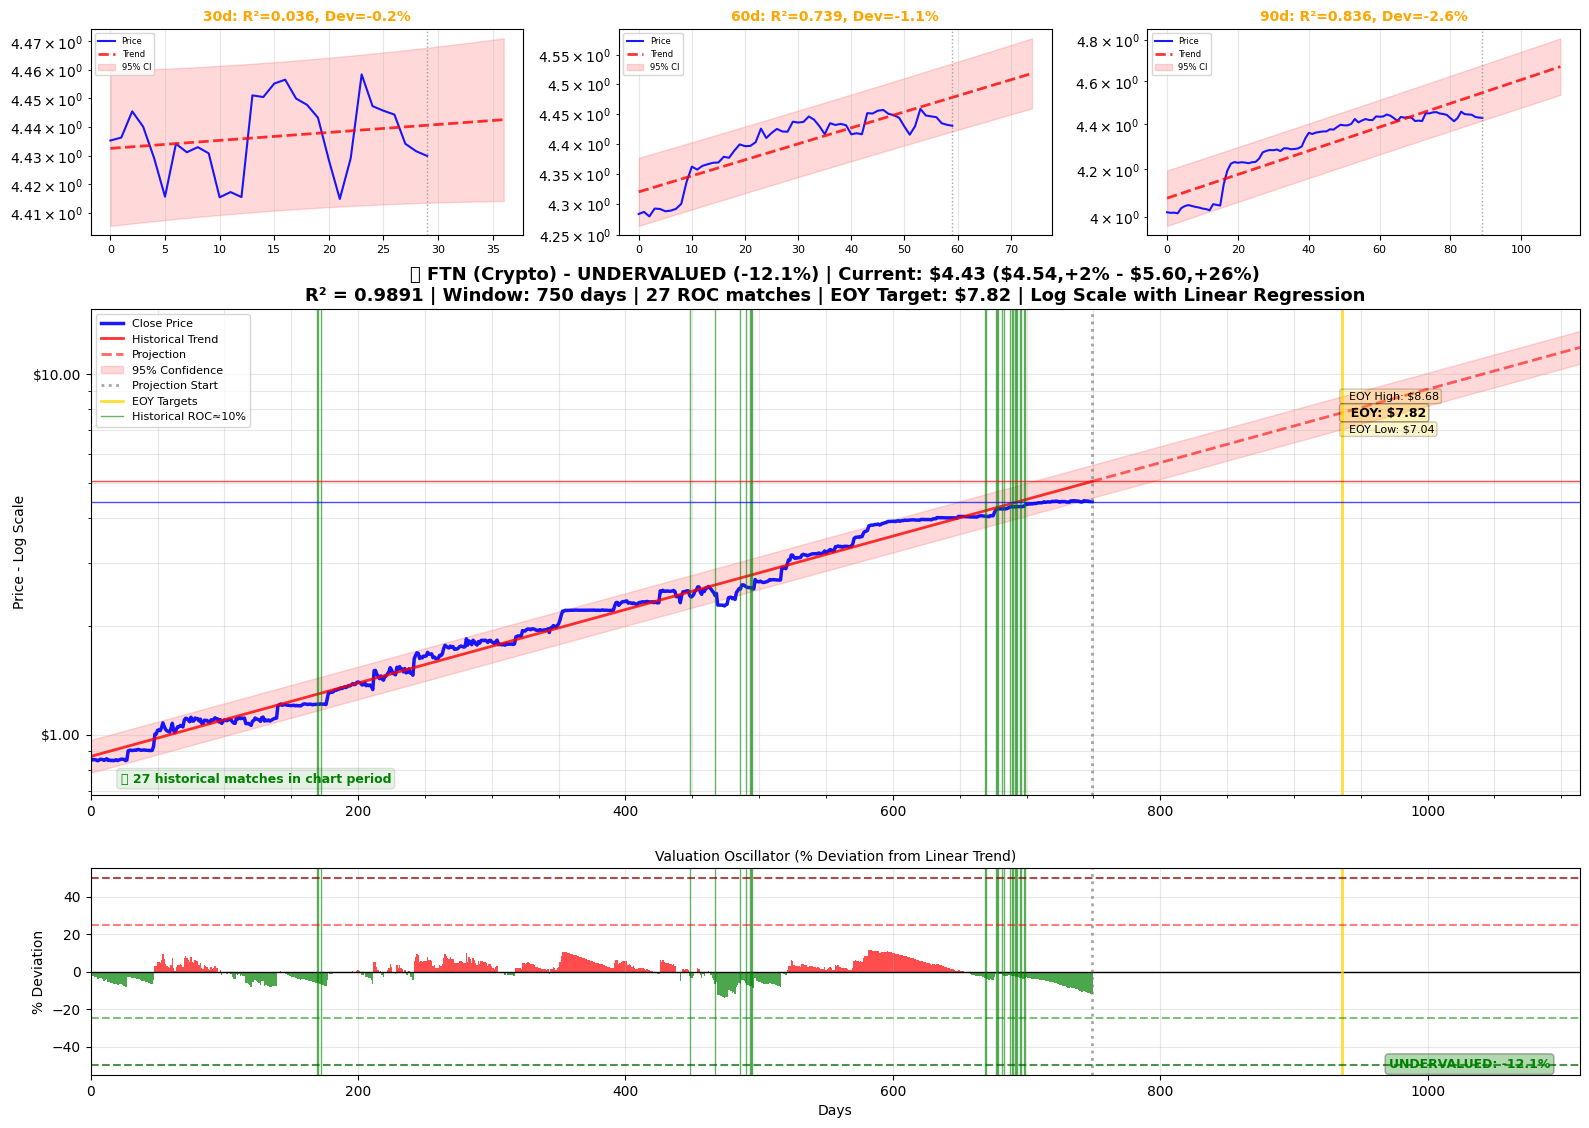


📊 PRICE PROJECTIONS (Linear Regression - 750 days):
   Current: $4.43 ($4.54,+2% - $5.60,+26%)
   +30d (1m): $5.41,+22.1% ($4.87,+10% - $6.01,+36%)
   +60d (2m): $5.80,+31.0% ($5.22,+18% - $6.44,+45%)
   +90d (3m): $6.23,+40.5% ($5.61,+27% - $6.91,+56%)
   +180d (6m): $7.69,+73.5% ($6.92,+56% - $8.54,+93%)
   +365d (1y): $11.86,+167.8% ($10.68,+141% - $13.18,+198%)
   +EOY (187d): $7.82,+76.4% ($7.04,+59% - $8.68,+96%)
   End-of-year outlook: 📈 Bullish Trend (+76.4%)
   Confidence: 98.9% | Valuation: UNDERVALUED
   🎯 Historical pattern matches: 27 periods in chart (90d ROC≈10%)
   📅 Days until EOY 2025: 187 days | EOY Target: $7.82 (+76.4%)
------------------------------------------------------------

🔮 FORWARD RETURNS ANALYSIS (Round Half Up Matching):
------------------------------------------------------------

FTN - FORWARD RETURNS ANALYSIS (ROC 30-day window)
Current 30-day ROC: -0.15%
Rounded target for matching: 0%
Similar historical periods found: 49
Matching method: Round hal

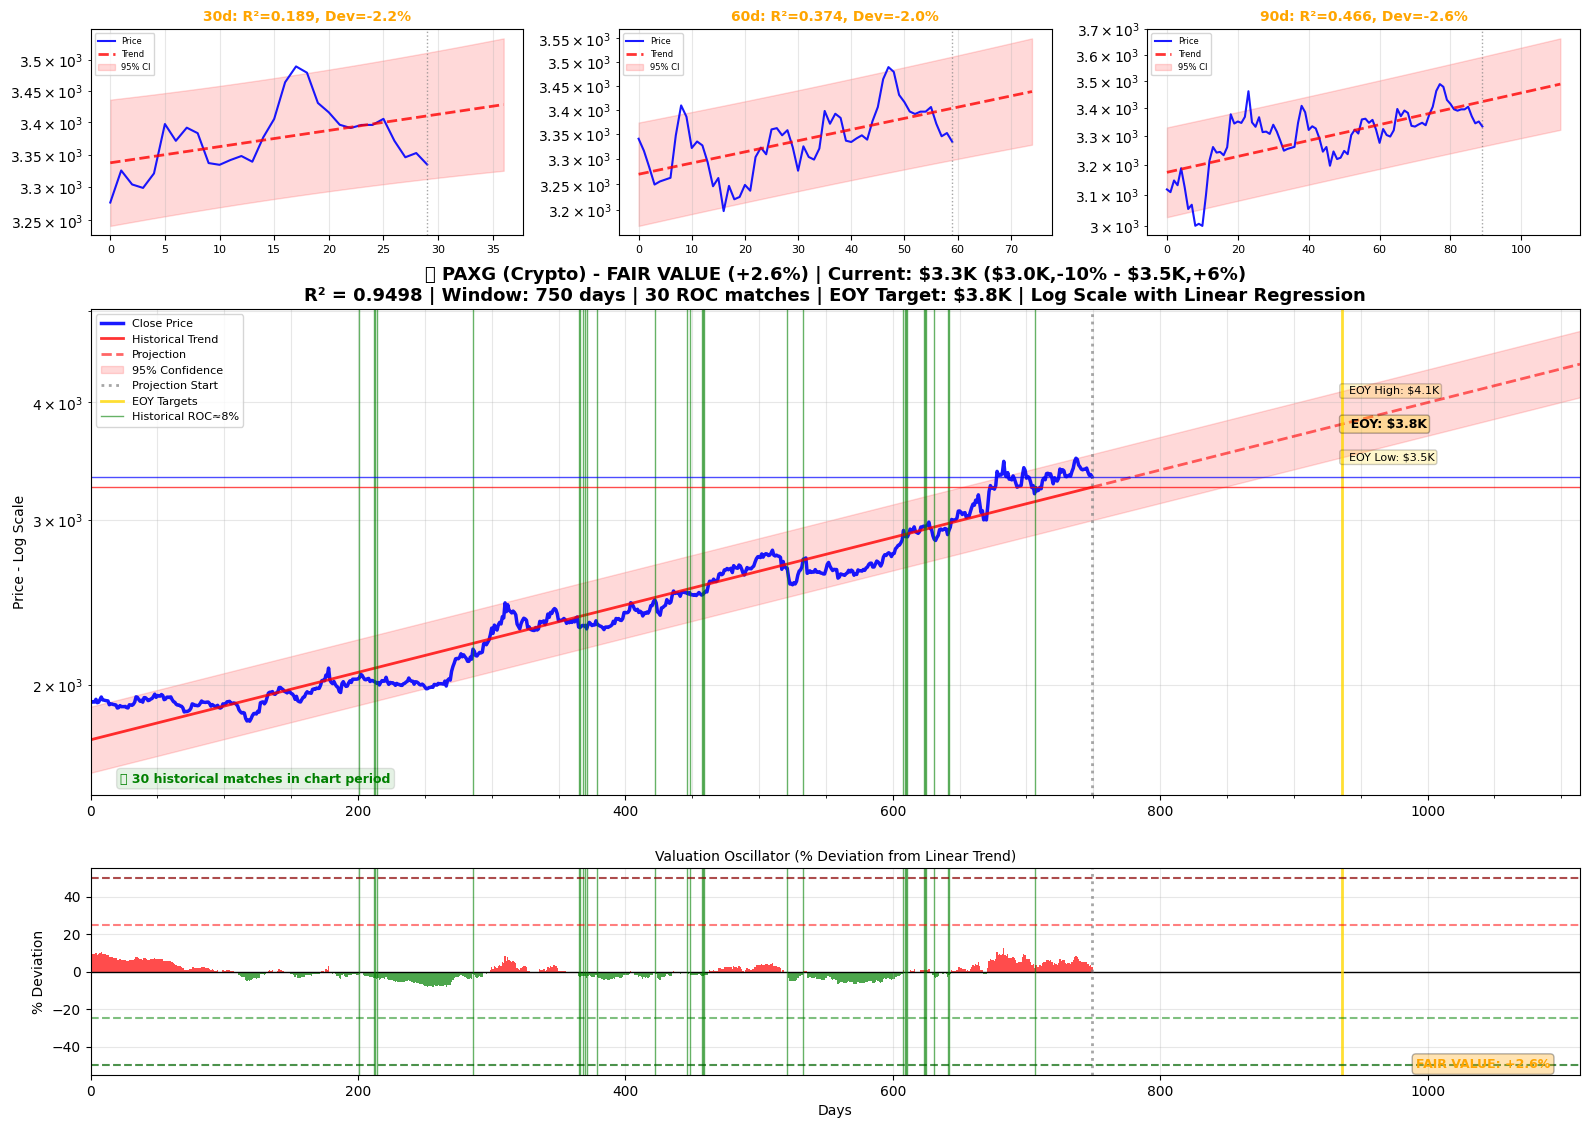


📊 PRICE PROJECTIONS (Linear Regression - 750 days):
   Current: $3.3K ($3.0K,-10% - $3.5K,+6%)
   +30d (1m): $3.3K,-0.1% ($3.1K,-8% - $3.6K,+8%)
   +60d (2m): $3.4K,+2.4% ($3.1K,-6% - $3.7K,+11%)
   +90d (3m): $3.5K,+5.0% ($3.2K,-3% - $3.8K,+14%)
   +180d (6m): $3.8K,+13.1% ($3.5K,+4% - $4.1K,+23%)
   +365d (1y): $4.4K,+31.8% ($4.1K,+21% - $4.8K,+43%)
   +EOY (187d): $3.8K,+13.7% ($3.5K,+5% - $4.1K,+23%)
   End-of-year outlook: 📈 Bullish Trend (+13.7%)
   Confidence: 95.0% | Valuation: FAIR VALUE
   🎯 Historical pattern matches: 30 periods in chart (90d ROC≈8%)
   📅 Days until EOY 2025: 187 days | EOY Target: $3.8K (+13.7%)
------------------------------------------------------------

🔮 FORWARD RETURNS ANALYSIS (Round Half Up Matching):
------------------------------------------------------------

PAXG - FORWARD RETURNS ANALYSIS (ROC 30-day window)
Current 30-day ROC: 0.34%
Rounded target for matching: 0%
Similar historical periods found: 197
Matching method: Round half up to nearest 

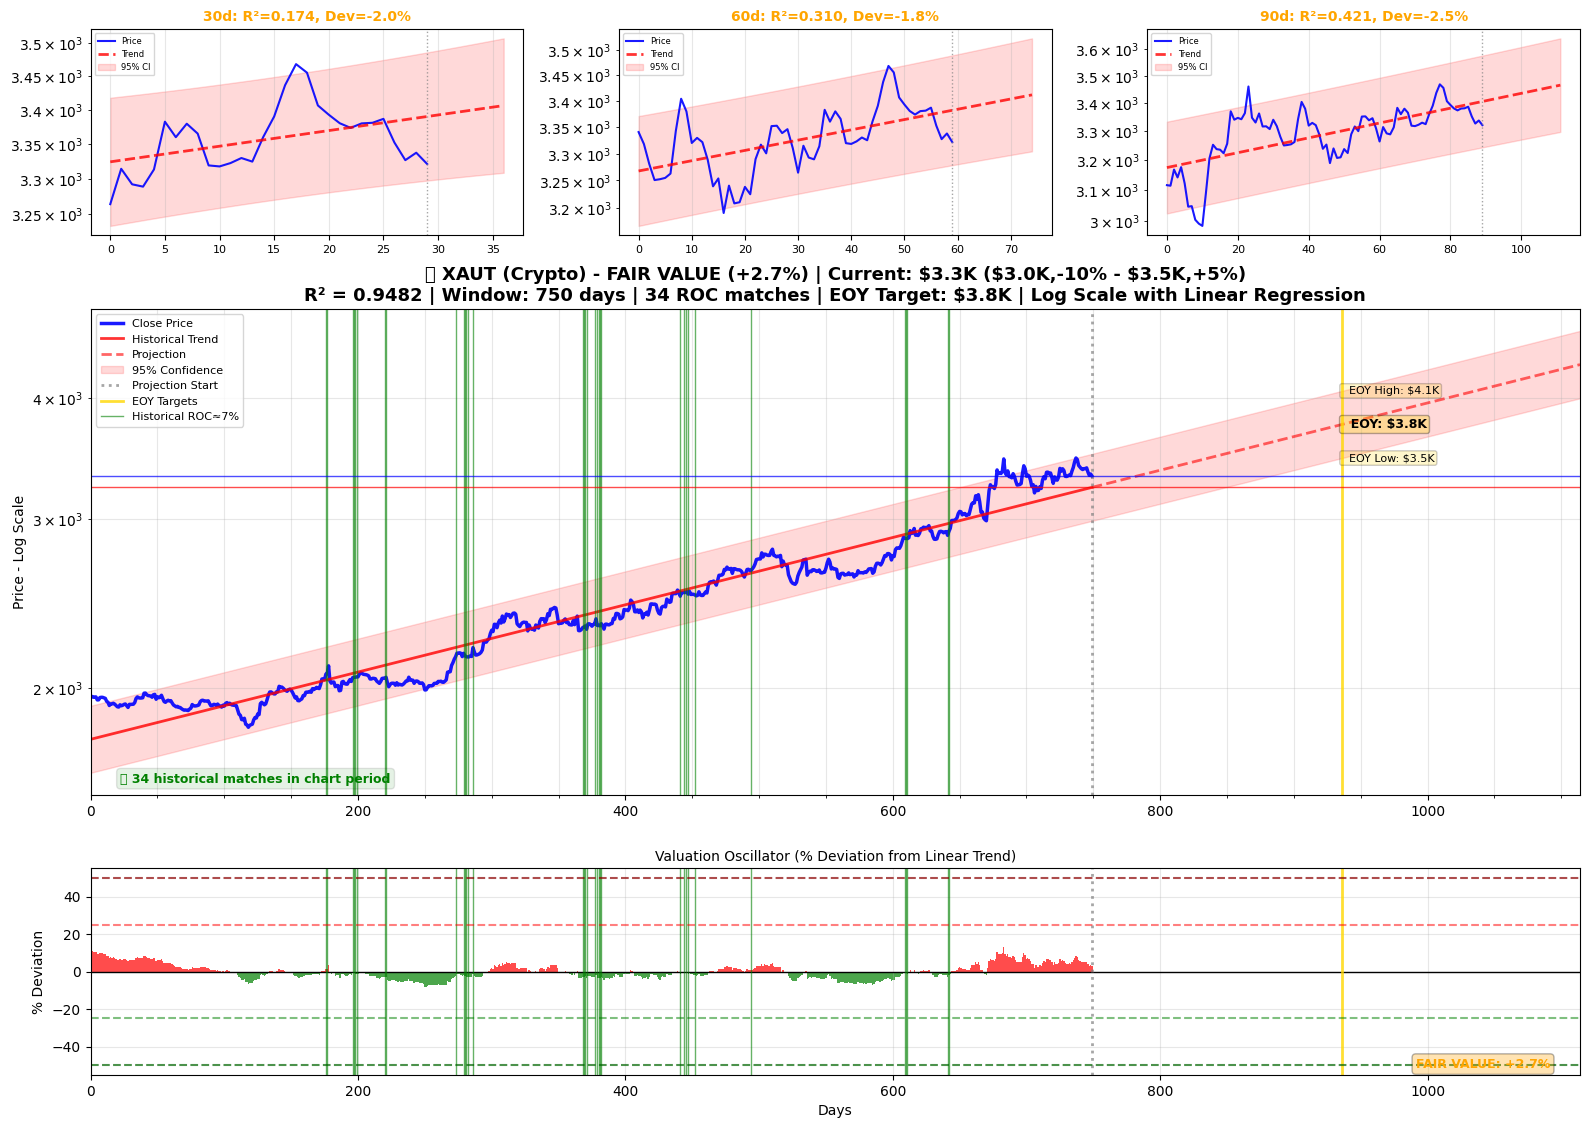


📊 PRICE PROJECTIONS (Linear Regression - 750 days):
   Current: $3.3K ($3.0K,-10% - $3.5K,+5%)
   +30d (1m): $3.3K,-0.3% ($3.1K,-8% - $3.6K,+8%)
   +60d (2m): $3.4K,+2.1% ($3.1K,-6% - $3.7K,+11%)
   +90d (3m): $3.5K,+4.6% ($3.2K,-3% - $3.8K,+13%)
   +180d (6m): $3.7K,+12.5% ($3.4K,+4% - $4.0K,+22%)
   +365d (1y): $4.3K,+30.5% ($4.0K,+20% - $4.7K,+41%)
   +EOY (187d): $3.8K,+13.1% ($3.5K,+4% - $4.1K,+23%)
   End-of-year outlook: 📈 Bullish Trend (+13.1%)
   Confidence: 94.8% | Valuation: FAIR VALUE
   🎯 Historical pattern matches: 34 periods in chart (90d ROC≈7%)
   📅 Days until EOY 2025: 187 days | EOY Target: $3.8K (+13.1%)
------------------------------------------------------------

🔮 FORWARD RETURNS ANALYSIS (Round Half Up Matching):
------------------------------------------------------------

XAUT - FORWARD RETURNS ANALYSIS (ROC 30-day window)
Current 30-day ROC: 0.34%
Rounded target for matching: 0%
Similar historical periods found: 173
Matching method: Round half up to nearest 

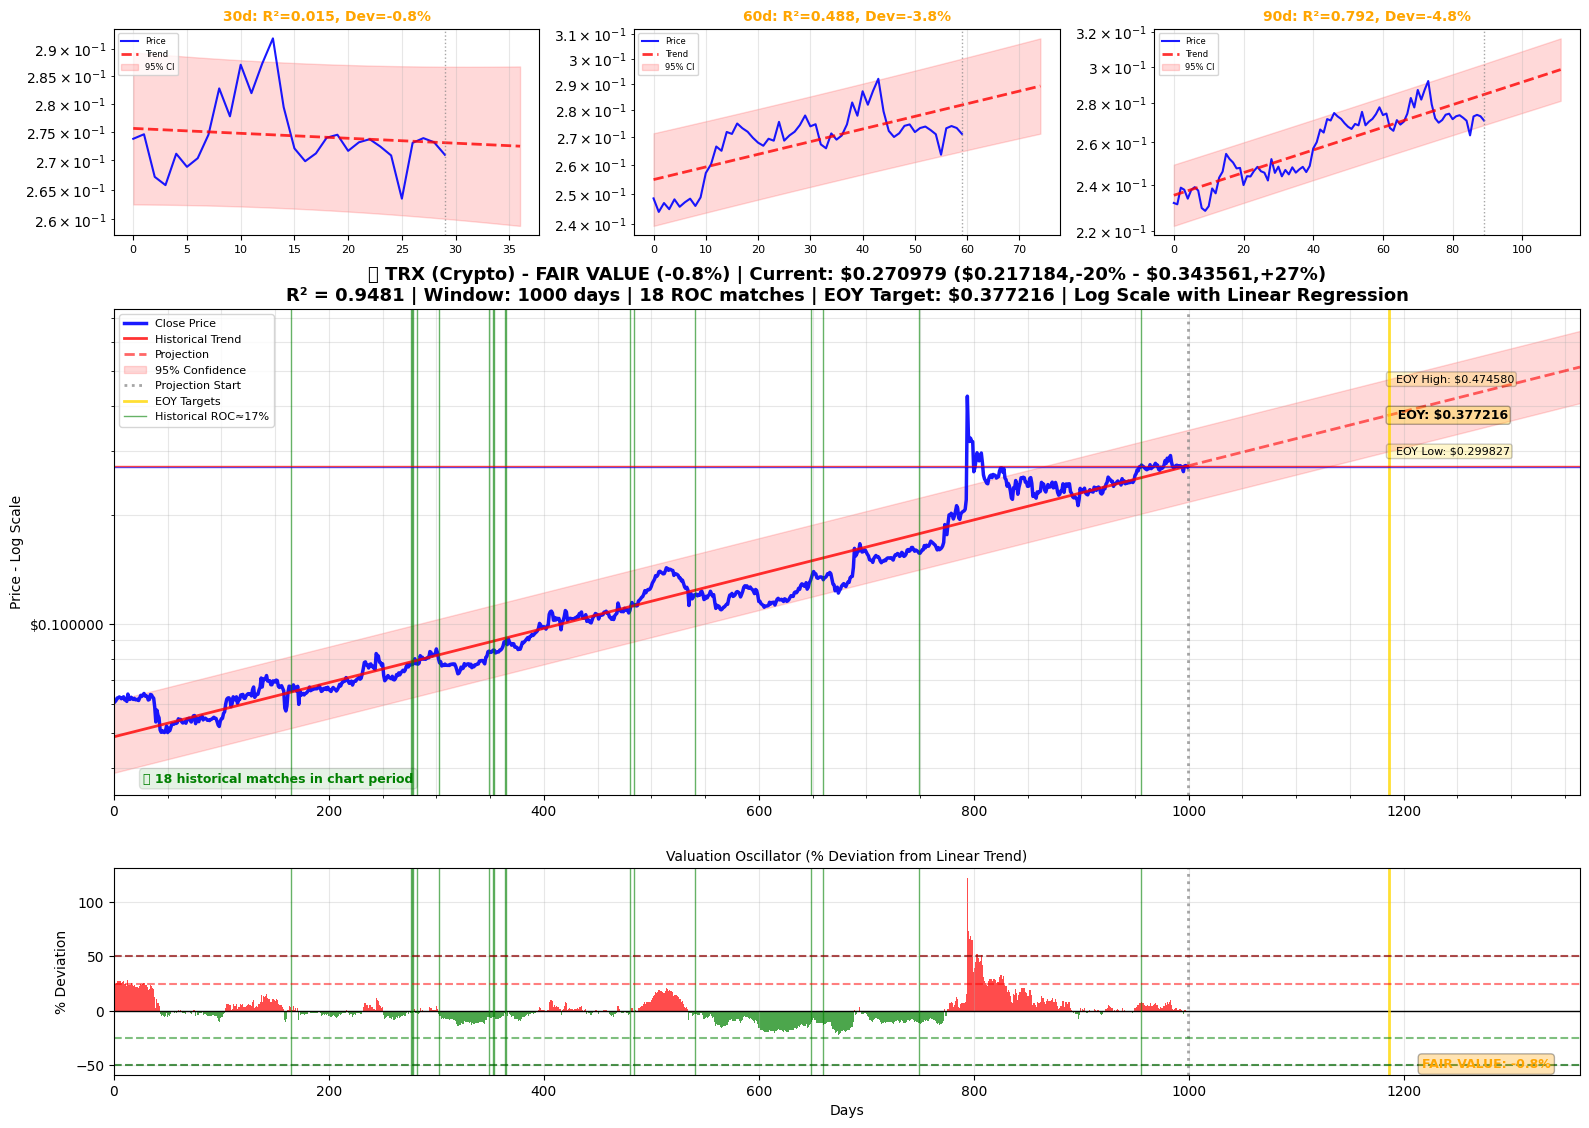


📊 PRICE PROJECTIONS (Linear Regression - 1000 days):
   Current: $0.270979 ($0.217184,-20% - $0.343561,+27%)
   +30d (1m): $0.287676,+6.2% ($0.228717,-16% - $0.361834,+34%)
   +60d (2m): $0.302964,+11.8% ($0.240861,-11% - $0.381081,+41%)
   +90d (3m): $0.319065,+17.7% ($0.253649,-6% - $0.401352,+48%)
   +180d (6m): $0.372686,+37.5% ($0.296230,+9% - $0.468875,+73%)
   +365d (1y): $0.512882,+89.3% ($0.407506,+50% - $0.645507,+138%)
   +EOY (187d): $0.377216,+39.2% ($0.299827,+11% - $0.474580,+75%)
   End-of-year outlook: 📈 Bullish Trend (+39.2%)
   Confidence: 94.8% | Valuation: FAIR VALUE
   🎯 Historical pattern matches: 18 periods in chart (90d ROC≈17%)
   📅 Days until EOY 2025: 187 days | EOY Target: $0.377216 (+39.2%)
------------------------------------------------------------

🔮 FORWARD RETURNS ANALYSIS (Round Half Up Matching):
------------------------------------------------------------

TRX - FORWARD RETURNS ANALYSIS (ROC 30-day window)
Current 30-day ROC: -2.46%
Rounded target

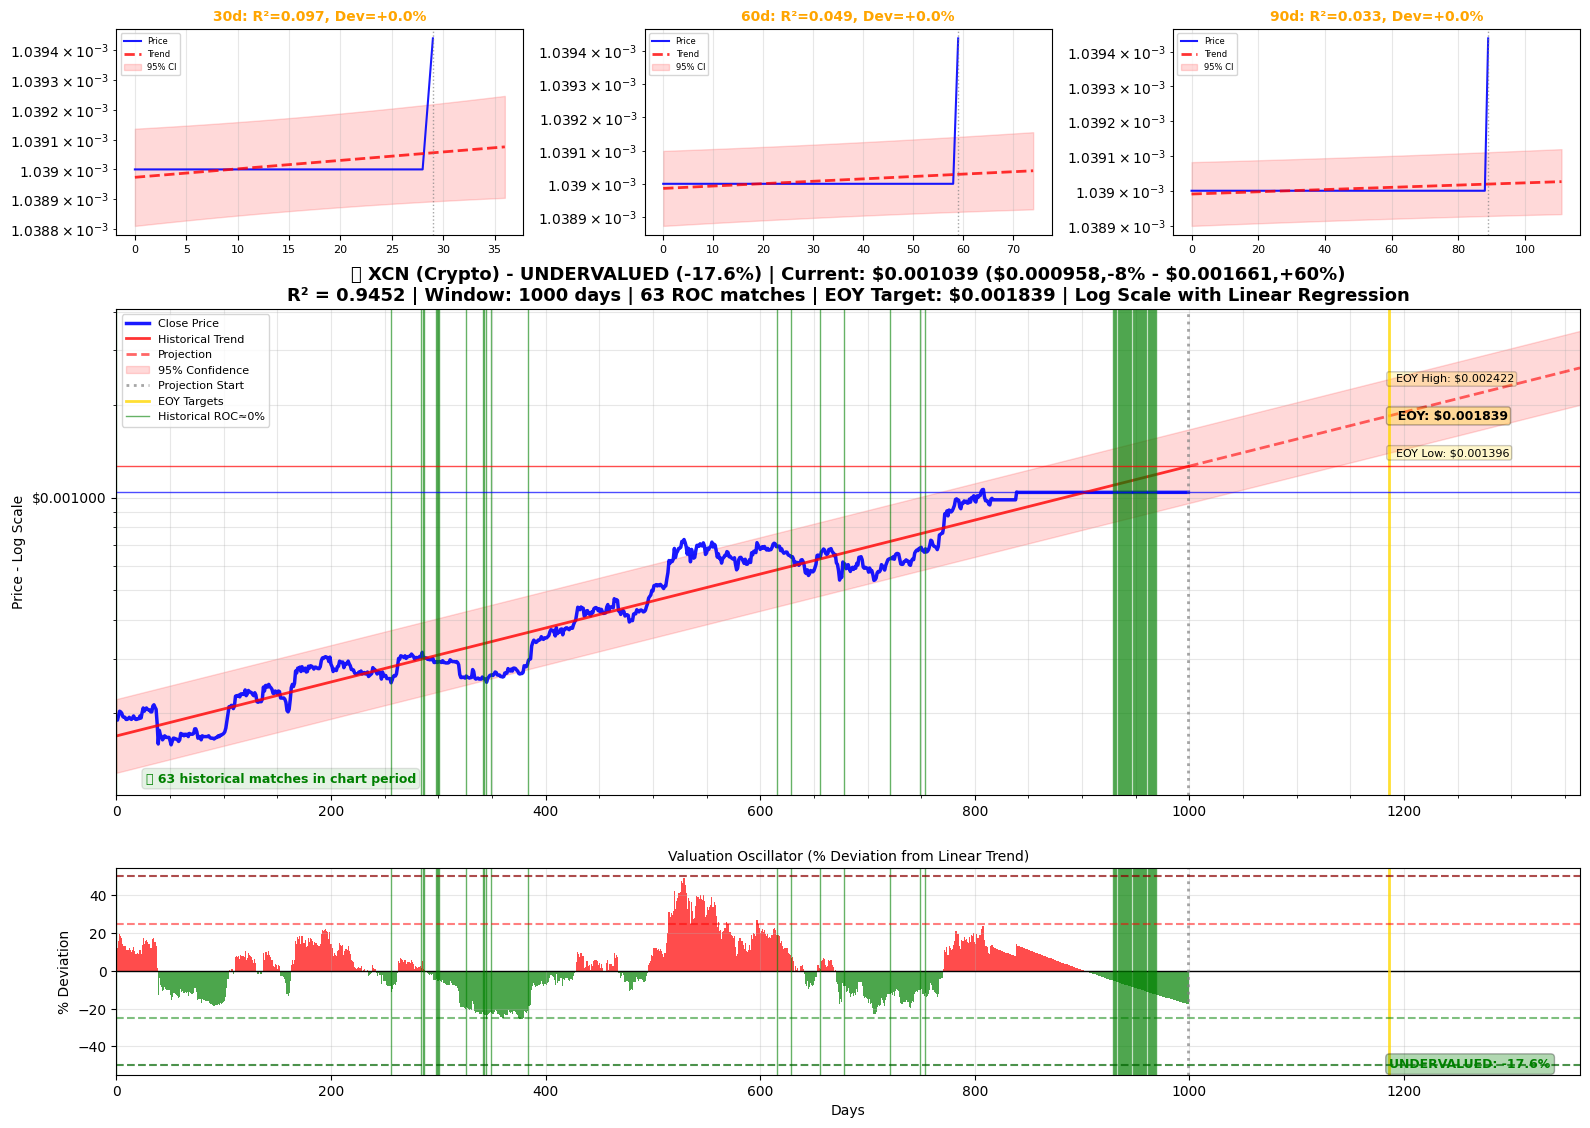


📊 PRICE PROJECTIONS (Linear Regression - 1000 days):
   Current: $0.001039 ($0.000958,-8% - $0.001661,+60%)
   +30d (1m): $0.001340,+28.9% ($0.001018,-2% - $0.001765,+70%)
   +60d (2m): $0.001424,+37.0% ($0.001081,+4% - $0.001875,+80%)
   +90d (3m): $0.001512,+45.5% ($0.001148,+10% - $0.001991,+92%)
   +180d (6m): $0.001813,+74.4% ($0.001376,+32% - $0.002388,+130%)
   +365d (1y): $0.002631,+153.1% ($0.001997,+92% - $0.003467,+234%)
   +EOY (187d): $0.001839,+76.9% ($0.001396,+34% - $0.002422,+133%)
   End-of-year outlook: 📈 Bullish Trend (+76.9%)
   Confidence: 94.5% | Valuation: UNDERVALUED
   🎯 Historical pattern matches: 63 periods in chart (90d ROC≈0%)
   📅 Days until EOY 2025: 187 days | EOY Target: $0.001839 (+76.9%)
------------------------------------------------------------

🔮 FORWARD RETURNS ANALYSIS (Round Half Up Matching):
------------------------------------------------------------

XCN - FORWARD RETURNS ANALYSIS (ROC 30-day window)
Current 30-day ROC: 0.04%
Rounded targ

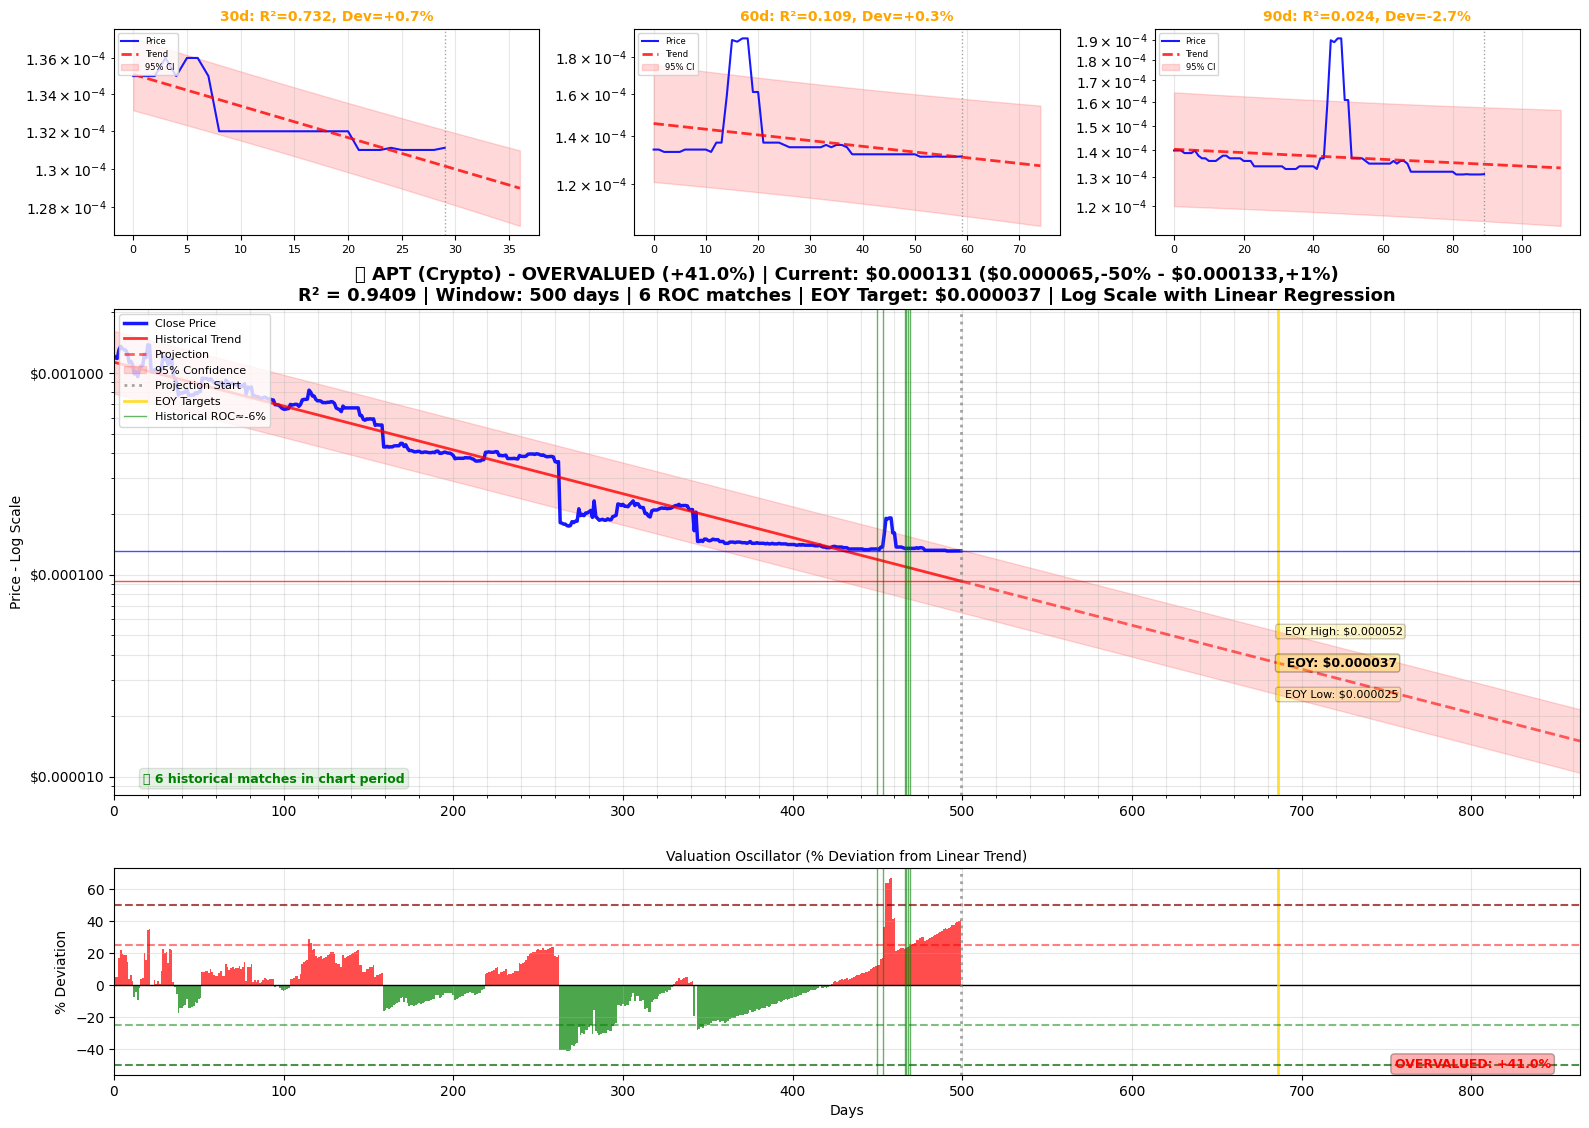


📊 PRICE PROJECTIONS (Linear Regression - 500 days):
   Current: $0.000131 ($0.000065,-50% - $0.000133,+1%)
   +30d (1m): $0.000080,-38.9% ($0.000056,-57% - $0.000114,-13%)
   +60d (2m): $0.000069,-47.5% ($0.000048,-63% - $0.000098,-25%)
   +90d (3m): $0.000059,-54.8% ($0.000041,-68% - $0.000085,-35%)
   +180d (6m): $0.000038,-71.2% ($0.000026,-80% - $0.000054,-59%)
   +365d (1y): $0.000015,-88.6% ($0.000010,-92% - $0.000022,-84%)
   +EOY (187d): $0.000037,-72.2% ($0.000025,-81% - $0.000052,-60%)
   End-of-year outlook: 📉 Bearish Trend (-72.2%)
   Confidence: 94.1% | Valuation: OVERVALUED
   🎯 Historical pattern matches: 6 periods in chart (90d ROC≈-6%)
   📅 Days until EOY 2025: 187 days | EOY Target: $0.000037 (-72.2%)
------------------------------------------------------------

🔮 FORWARD RETURNS ANALYSIS (Round Half Up Matching):
------------------------------------------------------------

APT - FORWARD RETURNS ANALYSIS (ROC 30-day window)
Current 30-day ROC: -2.88%
Rounded target 

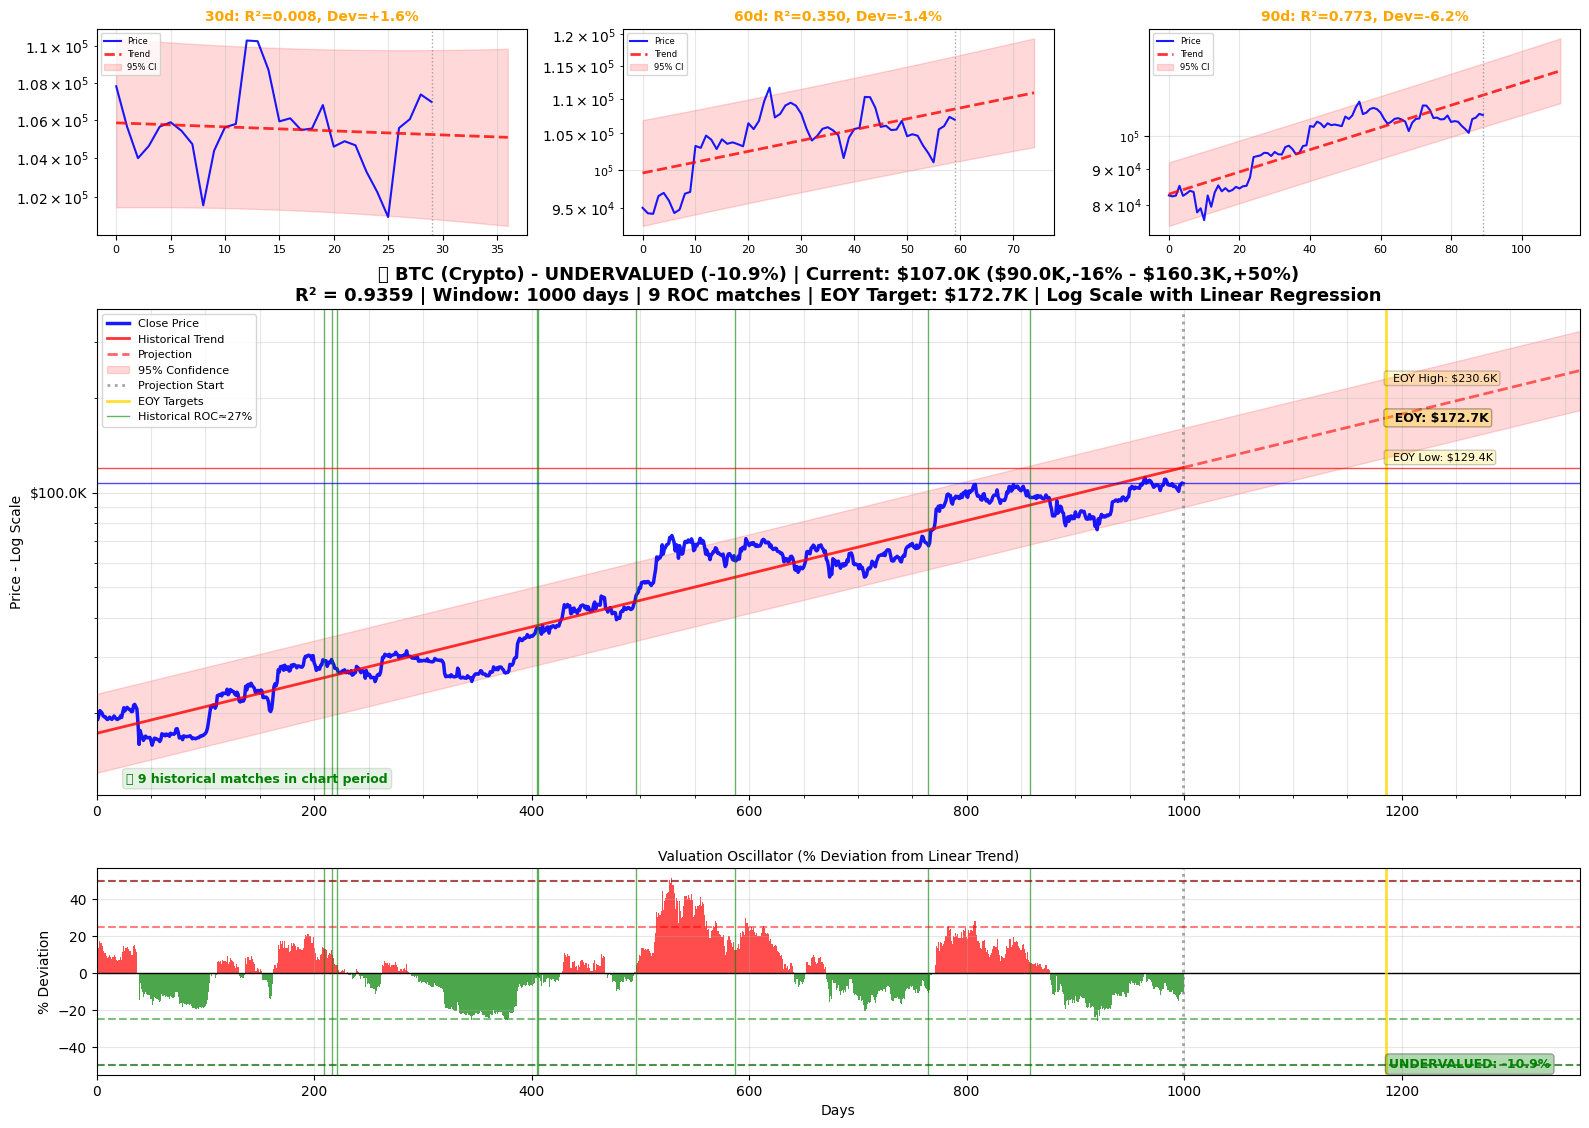


📊 PRICE PROJECTIONS (Linear Regression - 1000 days):
   Current: $107.0K ($90.0K,-16% - $160.3K,+50%)
   +30d (1m): $127.3K,+19.0% ($95.4K,-11% - $169.9K,+59%)
   +60d (2m): $134.9K,+26.2% ($101.1K,-5% - $180.1K,+68%)
   +90d (3m): $143.0K,+33.7% ($107.2K,+0% - $191.0K,+79%)
   +180d (6m): $170.4K,+59.3% ($127.6K,+19% - $227.5K,+113%)
   +365d (1y): $244.1K,+128.3% ($182.7K,+71% - $326.2K,+205%)
   +EOY (187d): $172.7K,+61.5% ($129.4K,+21% - $230.6K,+116%)
   End-of-year outlook: 📈 Bullish Trend (+61.5%)
   Confidence: 93.6% | Valuation: UNDERVALUED
   🎯 Historical pattern matches: 9 periods in chart (90d ROC≈27%)
   📅 Days until EOY 2025: 187 days | EOY Target: $172.7K (+61.5%)
------------------------------------------------------------

🔮 FORWARD RETURNS ANALYSIS (Round Half Up Matching):
------------------------------------------------------------

BTC - FORWARD RETURNS ANALYSIS (ROC 30-day window)
Current 30-day ROC: -1.87%
Rounded target for matching: -2%
Similar historical peri

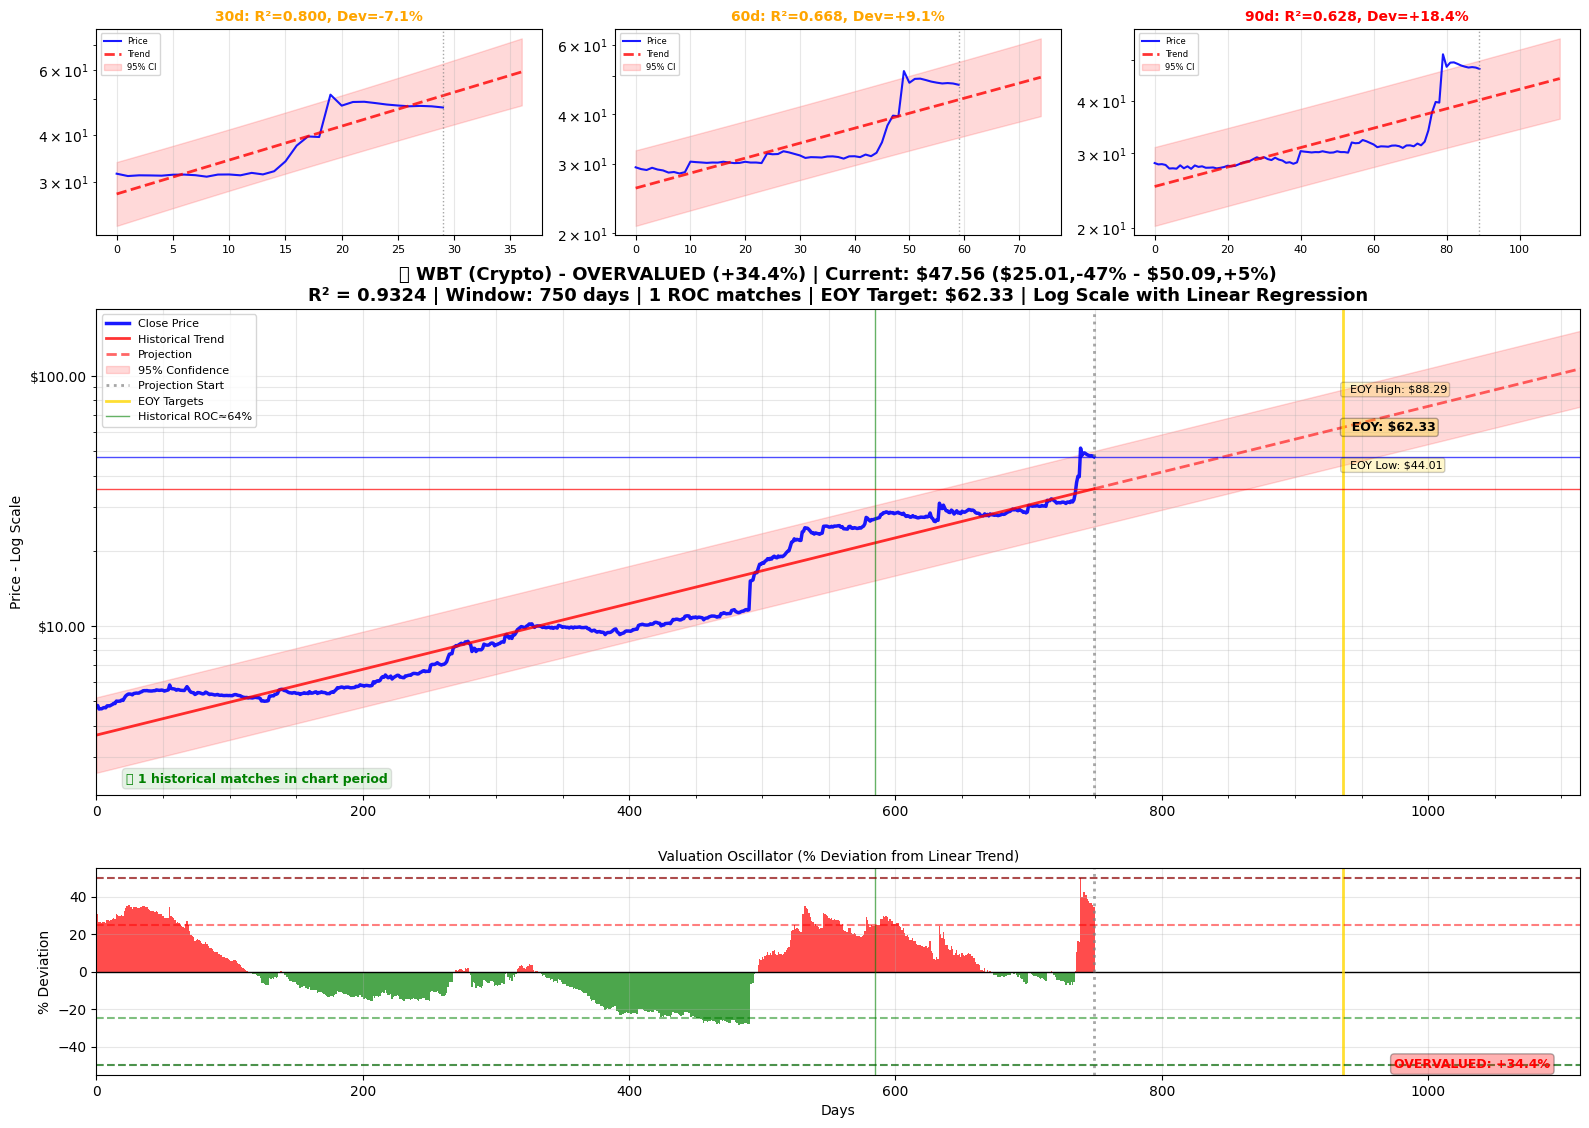


📊 PRICE PROJECTIONS (Linear Regression - 750 days):
   Current: $47.56 ($25.01,-47% - $50.09,+5%)
   +30d (1m): $38.76,-18.5% ($27.38,-42% - $54.85,+15%)
   +60d (2m): $42.44,-10.8% ($29.98,-37% - $60.08,+26%)
   +90d (3m): $46.47,-2.3% ($32.83,-31% - $65.80,+38%)
   +180d (6m): $61.03,+28.3% ($43.09,-9% - $86.43,+82%)
   +365d (1y): $106.83,+124.6% ($75.34,+58% - $151.48,+219%)
   +EOY (187d): $62.33,+31.1% ($44.01,-7% - $88.29,+86%)
   End-of-year outlook: 📈 Bullish Trend (+31.1%)
   Confidence: 93.2% | Valuation: OVERVALUED
   🎯 Historical pattern matches: 1 periods in chart (90d ROC≈64%)
   📅 Days until EOY 2025: 187 days | EOY Target: $62.33 (+31.1%)
------------------------------------------------------------

🔮 FORWARD RETURNS ANALYSIS (Round Half Up Matching):
------------------------------------------------------------
   ⚠️  Insufficient historical data for forward returns analysis
   💡 Need more historical data or try different ROC windows


Chart 9: TBTC-USD (R² = 0.9321)


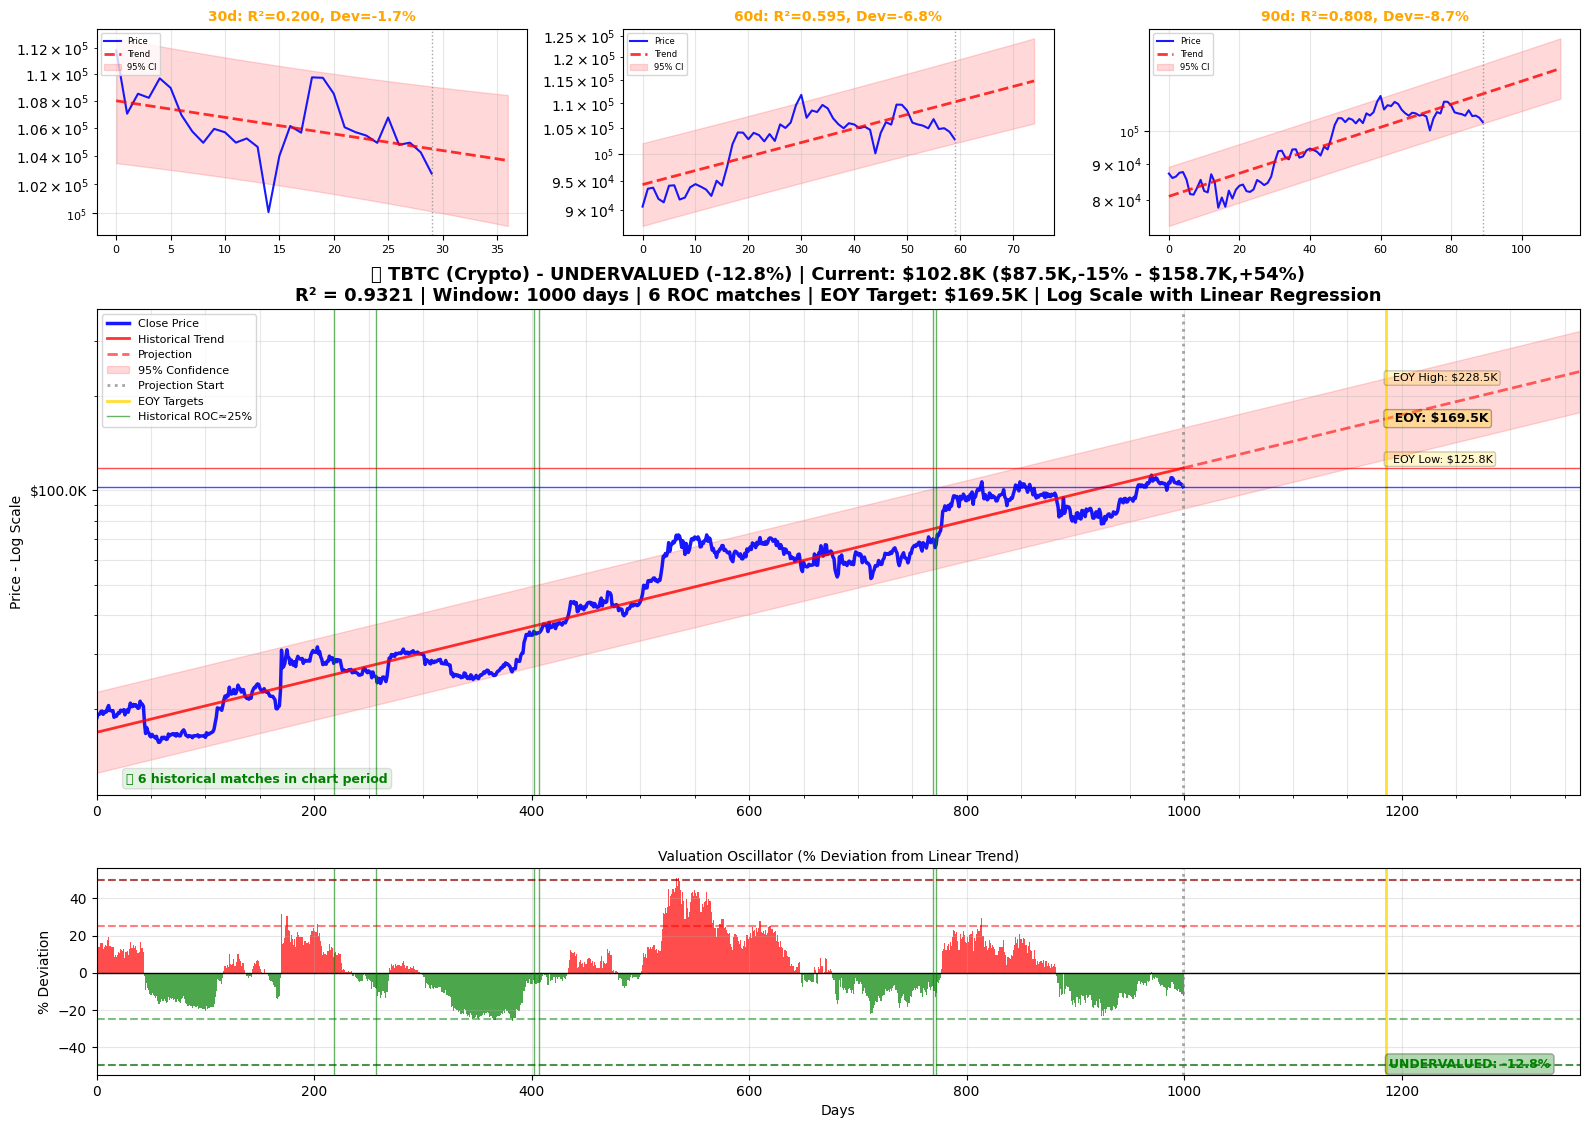


📊 PRICE PROJECTIONS (Linear Regression - 1000 days):
   Current: $102.8K ($87.5K,-15% - $158.7K,+54%)
   +30d (1m): $124.9K,+21.5% ($92.7K,-10% - $168.3K,+64%)
   +60d (2m): $132.4K,+28.8% ($98.3K,-4% - $178.4K,+74%)
   +90d (3m): $140.4K,+36.6% ($104.2K,+1% - $189.1K,+84%)
   +180d (6m): $167.2K,+62.7% ($124.1K,+21% - $225.4K,+119%)
   +365d (1y): $239.7K,+133.2% ($177.8K,+73% - $323.2K,+214%)
   +EOY (187d): $169.5K,+65.0% ($125.8K,+22% - $228.5K,+122%)
   End-of-year outlook: 📈 Bullish Trend (+65.0%)
   Confidence: 93.2% | Valuation: UNDERVALUED
   🎯 Historical pattern matches: 6 periods in chart (90d ROC≈25%)
   📅 Days until EOY 2025: 187 days | EOY Target: $169.5K (+65.0%)
------------------------------------------------------------

🔮 FORWARD RETURNS ANALYSIS (Round Half Up Matching):
------------------------------------------------------------

TBTC - FORWARD RETURNS ANALYSIS (ROC 30-day window)
Current 30-day ROC: -6.28%
Rounded target for matching: -6%
Similar historical peri

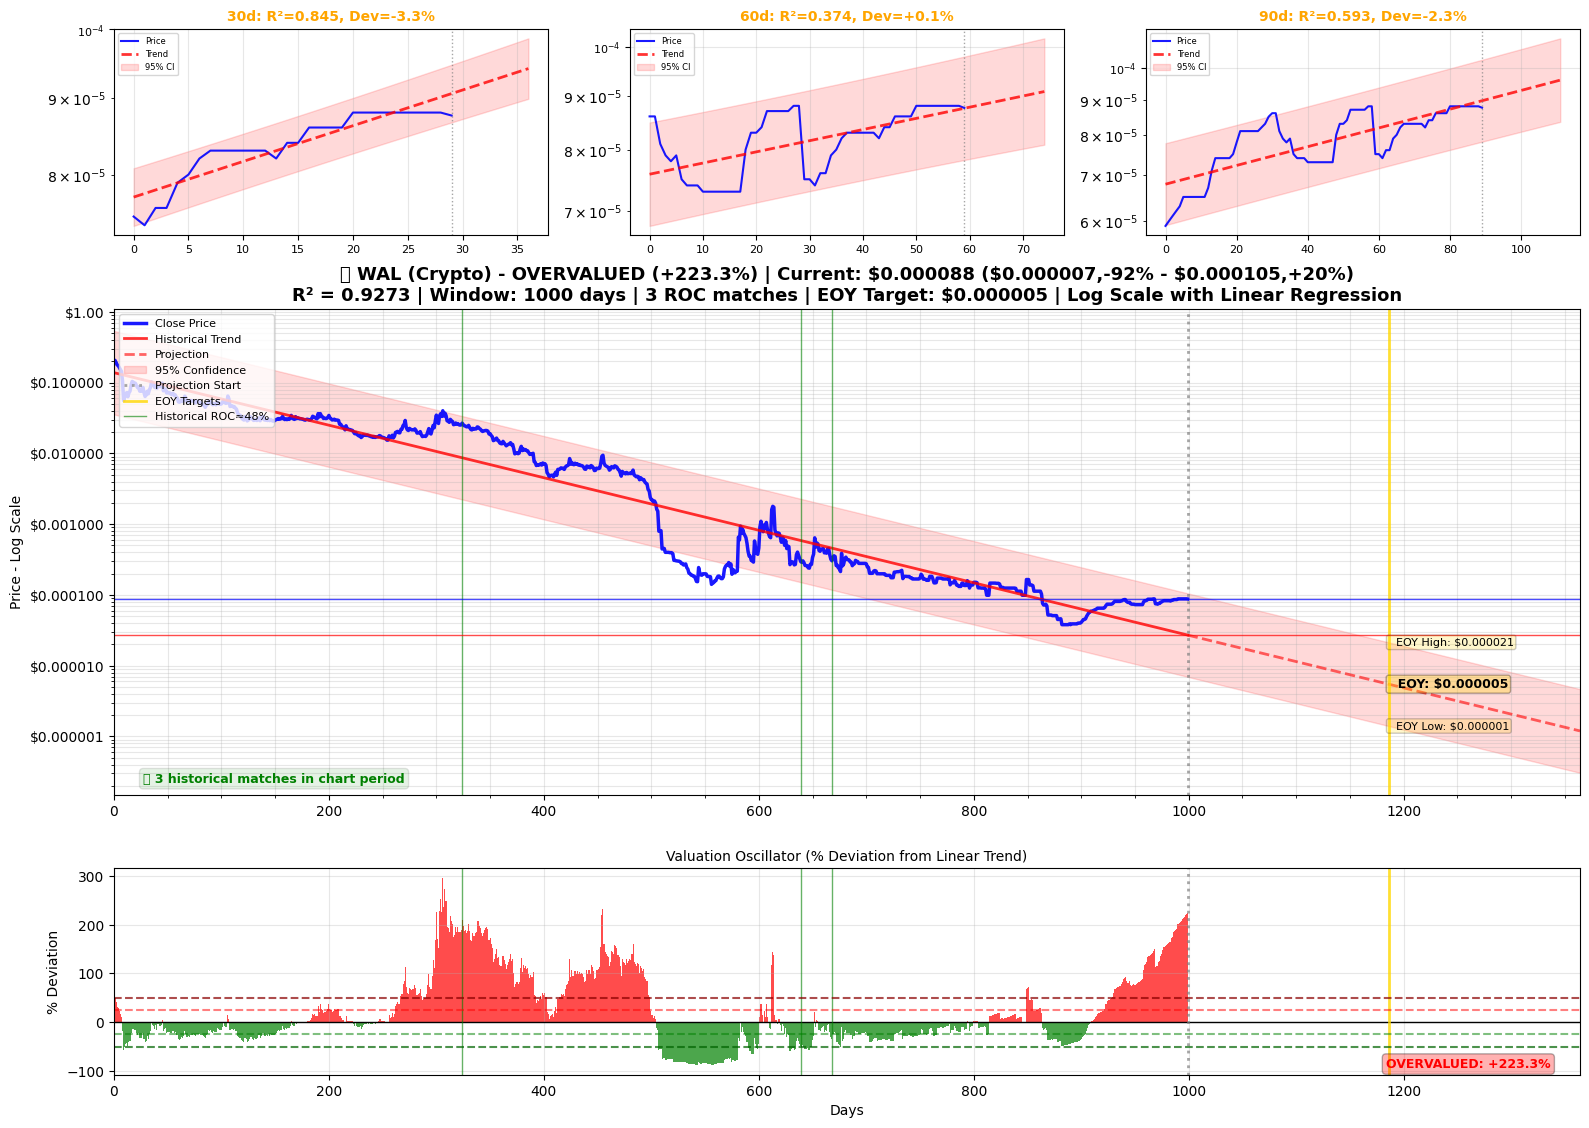


📊 PRICE PROJECTIONS (Linear Regression - 1000 days):
   Current: $0.000088 ($0.000007,-92% - $0.000105,+20%)
   +30d (1m): $0.000021,-76.1% ($0.000005,-94% - $0.000082,-7%)
   +60d (2m): $0.000016,-81.5% ($0.000004,-95% - $0.000063,-28%)
   +90d (3m): $0.000013,-85.7% ($0.000003,-96% - $0.000049,-44%)
   +180d (6m): $0.000006,-93.4% ($0.000001,-98% - $0.000023,-74%)
   +365d (1y): $0.000001,-98.6% ($0.000000,-100% - $0.000005,-95%)
   +EOY (187d): $0.000005,-93.7% ($0.000001,-98% - $0.000021,-76%)
   End-of-year outlook: 📉 Bearish Trend (-93.7%)
   Confidence: 92.7% | Valuation: OVERVALUED
   🎯 Historical pattern matches: 3 periods in chart (90d ROC≈48%)
   📅 Days until EOY 2025: 187 days | EOY Target: $0.000005 (-93.7%)
------------------------------------------------------------

🔮 FORWARD RETURNS ANALYSIS (Round Half Up Matching):
------------------------------------------------------------
   ⚠️  Insufficient historical data for forward returns analysis
   💡 Need more historical d

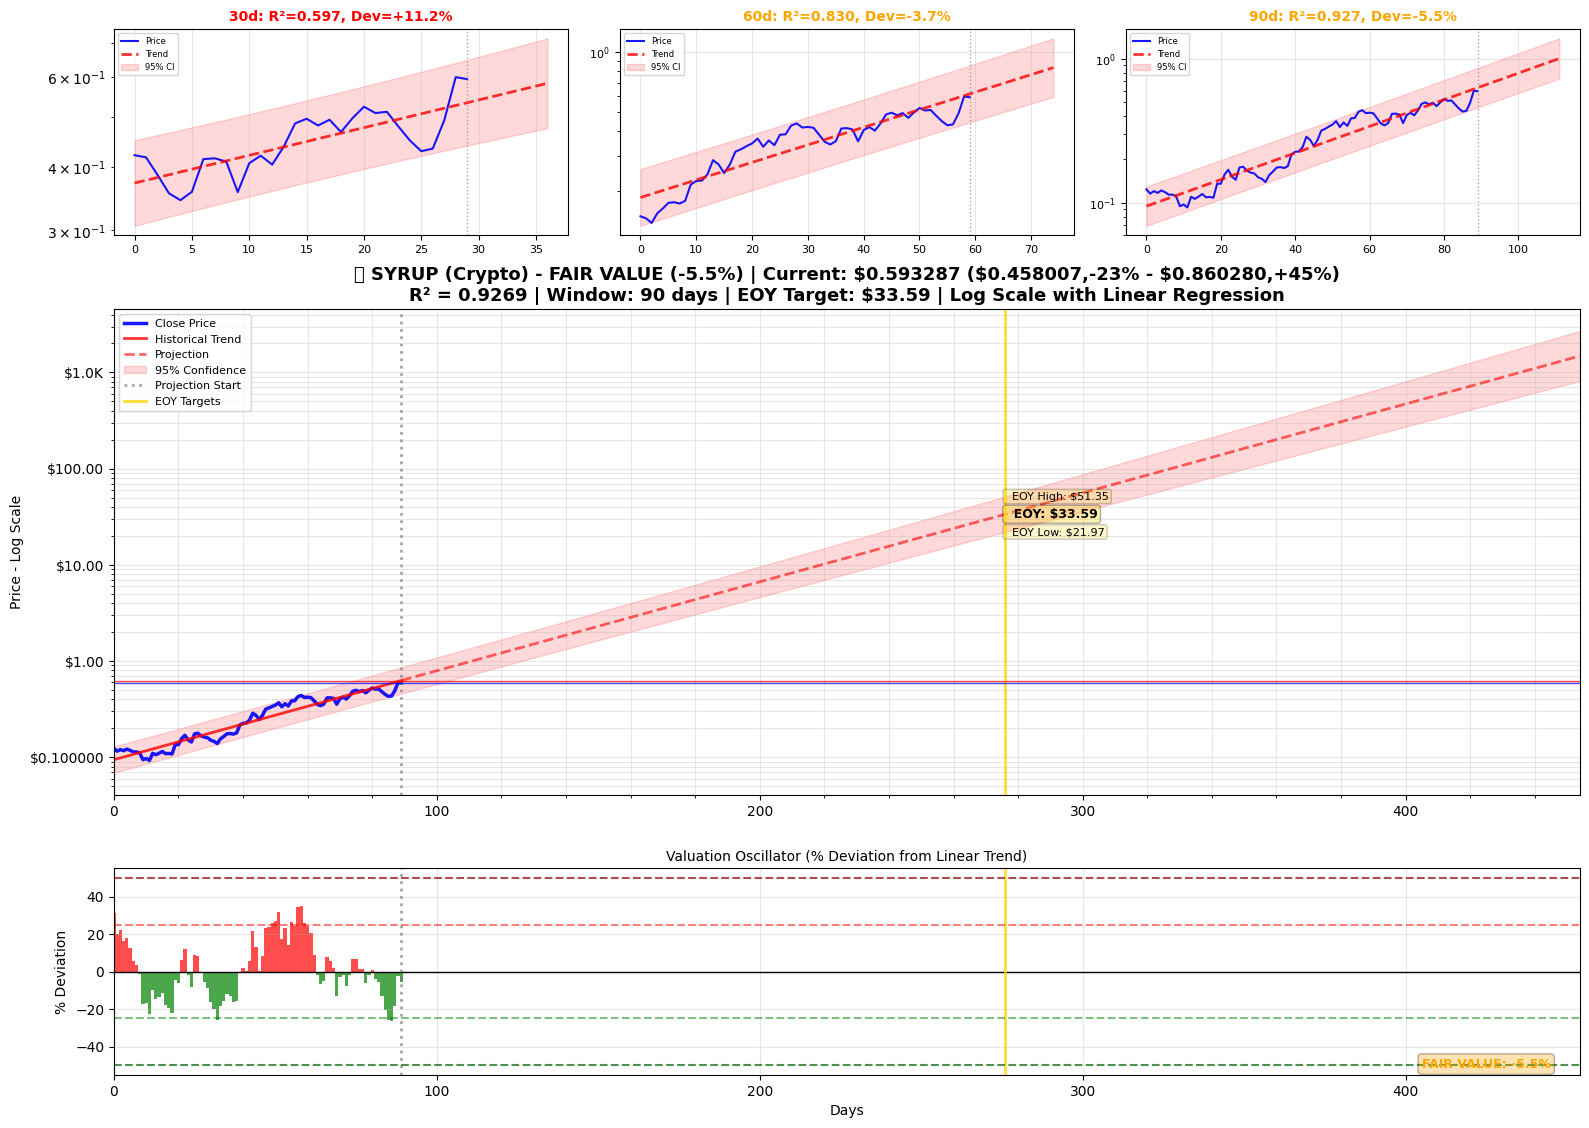


📊 PRICE PROJECTIONS (Linear Regression - 90 days):
   Current: $0.593287 ($0.458007,-23% - $0.860280,+45%)
   +30d (1m): $1.19,+100.3% ($0.859723,+45% - $1.64,+177%)
   +60d (2m): $2.25,+279.4% ($1.61,+171% - $3.15,+431%)
   +90d (3m): $4.26,+618.4% ($2.99,+405% - $6.07,+922%)
   +180d (6m): $28.94,+4777.7% ($19.04,+3109% - $43.98,+7313%)
   +365d (1y): $1.5K,+250026.8% ($815.09,+137286% - $2.7K,+455283%)
   +EOY (187d): $33.59,+5561.3% ($21.97,+3603% - $51.35,+8555%)
   End-of-year outlook: 📈 Bullish Trend (+5561.3%)
   Confidence: 92.7% | Valuation: FAIR VALUE
   📅 Days until EOY 2025: 187 days | EOY Target: $33.59 (+5561.3%)
------------------------------------------------------------

🔮 FORWARD RETURNS ANALYSIS (Round Half Up Matching):
------------------------------------------------------------
   ⚠️  Insufficient historical data for forward returns analysis
   💡 Need more historical data or try different ROC windows


Chart 12: POL-USD (R² = 0.9109)


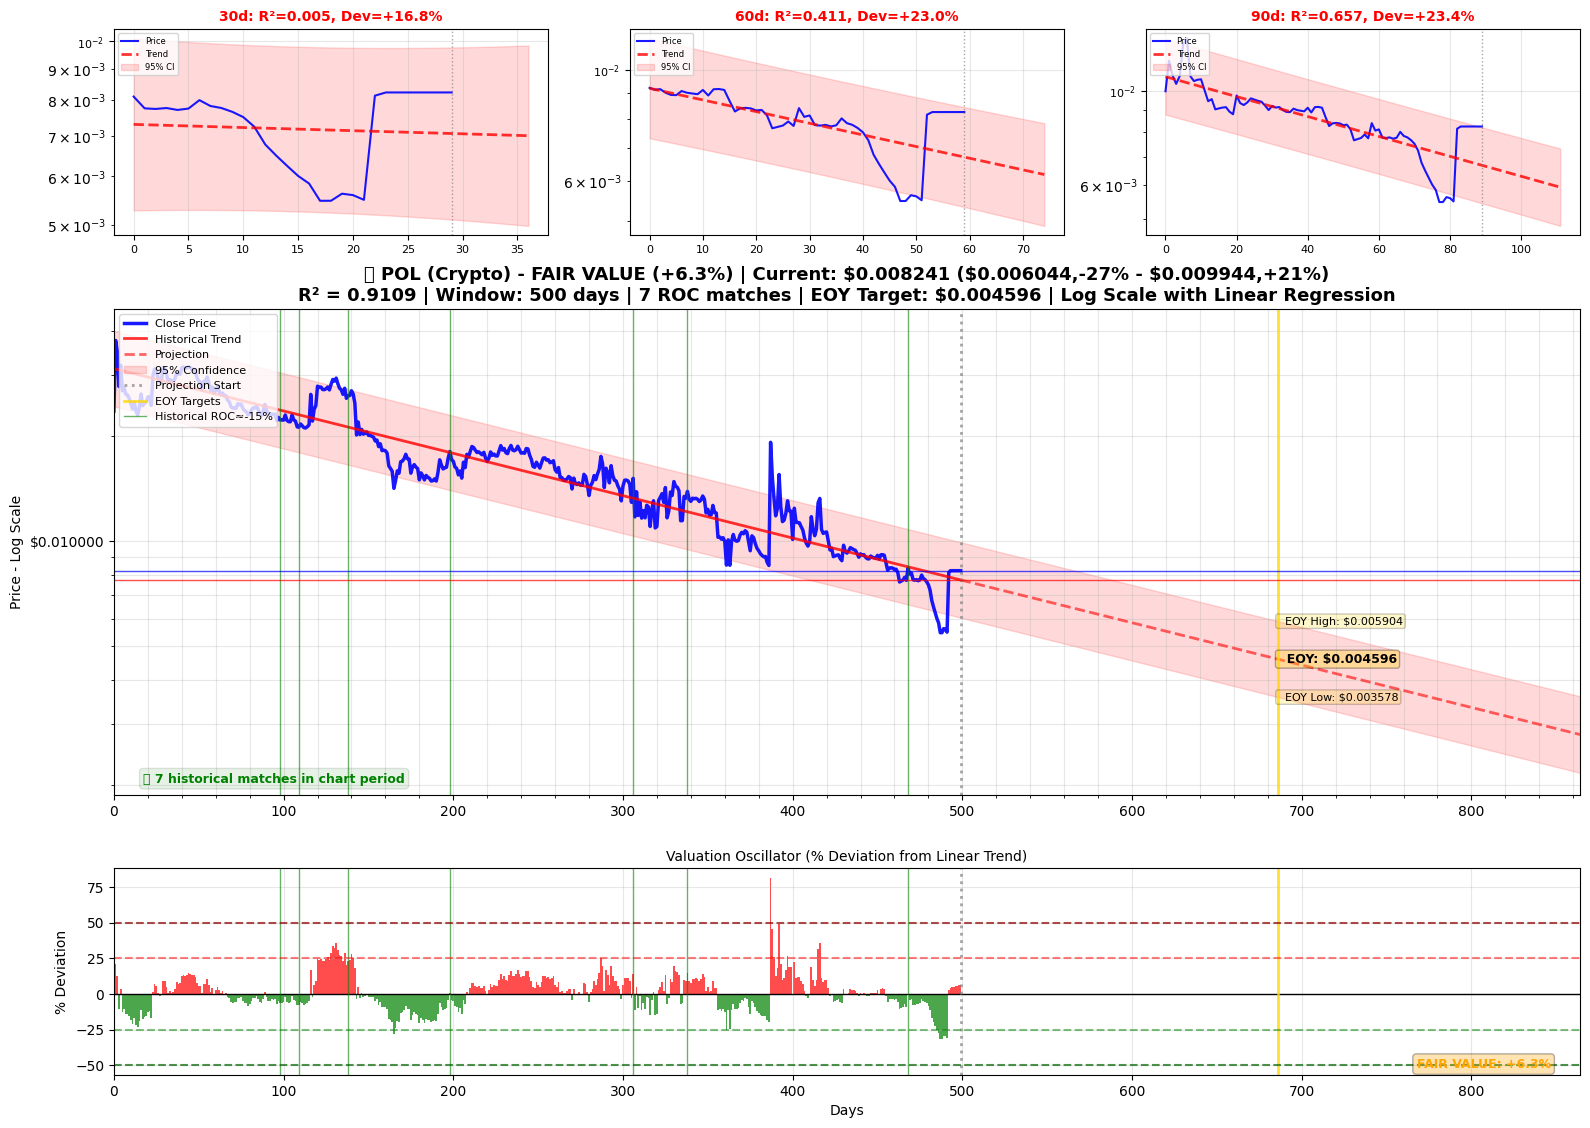


📊 PRICE PROJECTIONS (Linear Regression - 500 days):
   Current: $0.008241 ($0.006044,-27% - $0.009944,+21%)
   +30d (1m): $0.007129,-13.5% ($0.005557,-33% - $0.009145,+11%)
   +60d (2m): $0.006555,-20.5% ($0.005109,-38% - $0.008411,+2%)
   +90d (3m): $0.006028,-26.9% ($0.004697,-43% - $0.007736,-6%)
   +180d (6m): $0.004687,-43.1% ($0.003649,-56% - $0.006020,-27%)
   +365d (1y): $0.002794,-66.1% ($0.002170,-74% - $0.003597,-56%)
   +EOY (187d): $0.004596,-44.2% ($0.003578,-57% - $0.005904,-28%)
   End-of-year outlook: 📉 Bearish Trend (-44.2%)
   Confidence: 91.1% | Valuation: FAIR VALUE
   🎯 Historical pattern matches: 7 periods in chart (90d ROC≈-15%)
   📅 Days until EOY 2025: 187 days | EOY Target: $0.004596 (-44.2%)
------------------------------------------------------------

🔮 FORWARD RETURNS ANALYSIS (Round Half Up Matching):
------------------------------------------------------------

POL - FORWARD RETURNS ANALYSIS (ROC 30-day window)
Current 30-day ROC: 2.24%
Rounded target f

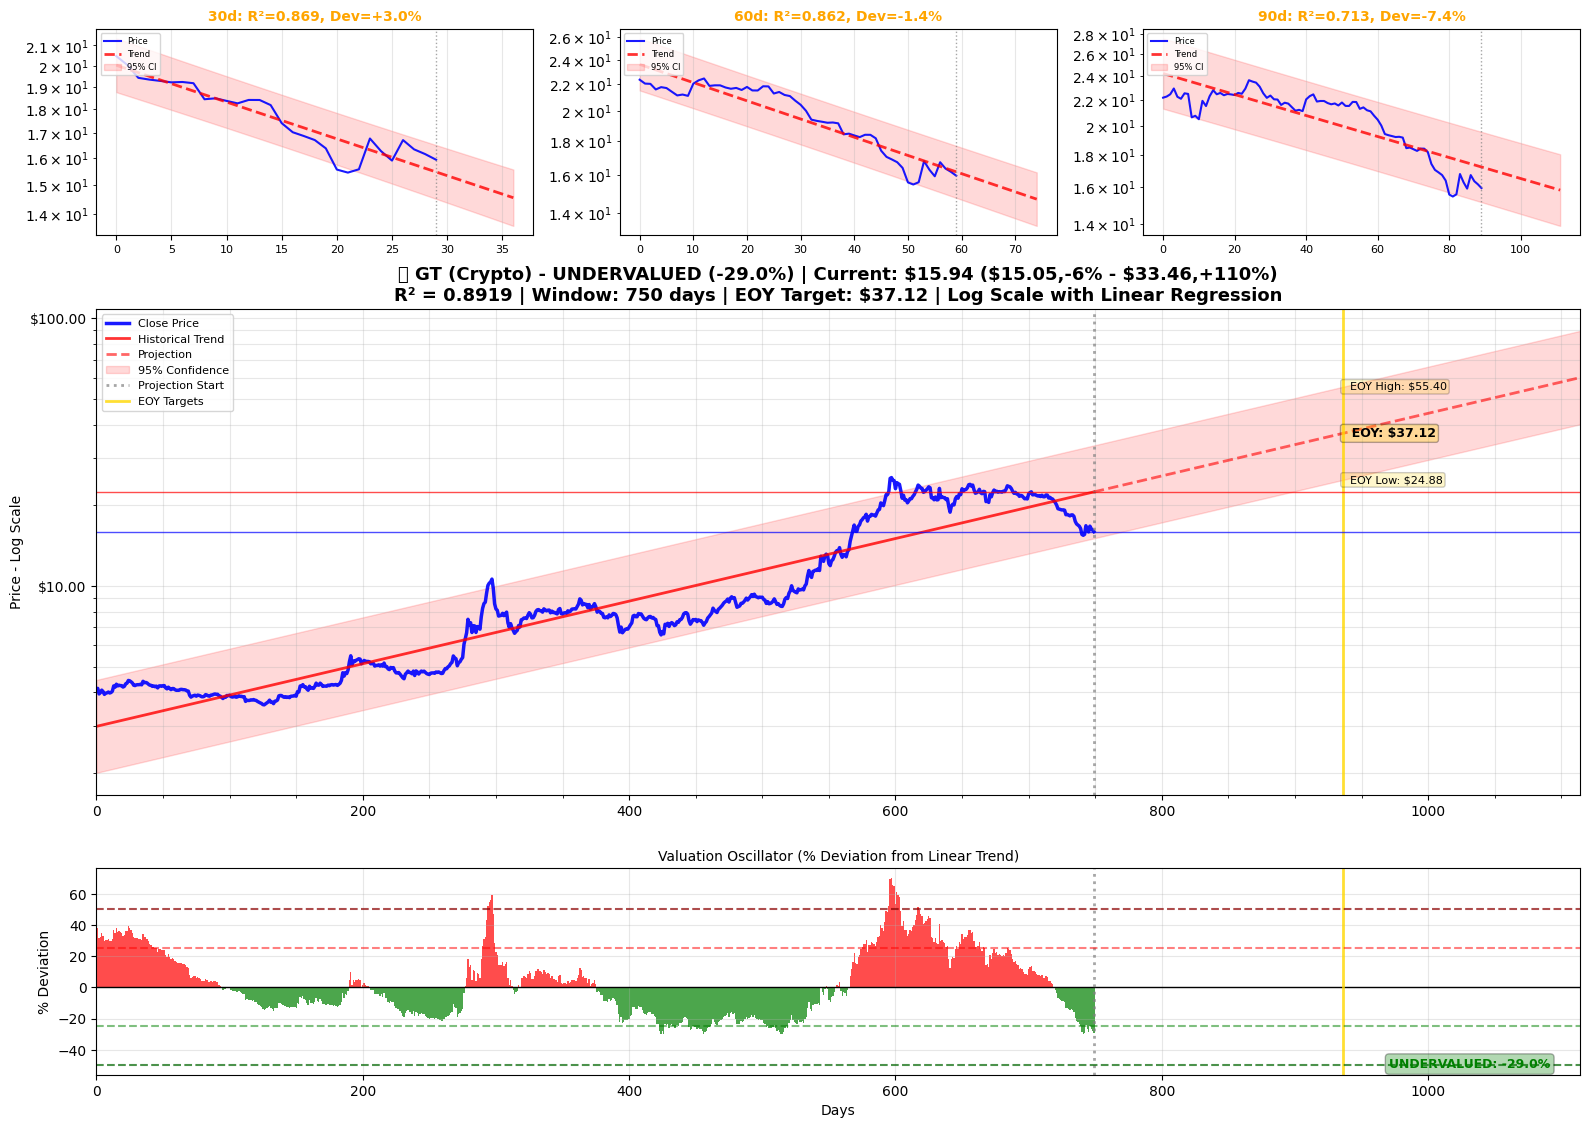


📊 PRICE PROJECTIONS (Linear Regression - 750 days):
   Current: $15.94 ($15.05,-6% - $33.46,+110%)
   +30d (1m): $24.33,+52.6% ($16.32,+2% - $36.28,+128%)
   +60d (2m): $26.38,+65.5% ($17.69,+11% - $39.33,+147%)
   +90d (3m): $28.59,+79.4% ($19.17,+20% - $42.65,+168%)
   +180d (6m): $36.43,+128.6% ($24.41,+53% - $54.37,+241%)
   +365d (1y): $59.94,+276.1% ($40.12,+152% - $89.58,+462%)
   +EOY (187d): $37.12,+132.9% ($24.88,+56% - $55.40,+248%)
   End-of-year outlook: 📈 Bullish Trend (+132.9%)
   Confidence: 89.2% | Valuation: UNDERVALUED
   📅 Days until EOY 2025: 187 days | EOY Target: $37.12 (+132.9%)
------------------------------------------------------------

🔮 FORWARD RETURNS ANALYSIS (Round Half Up Matching):
------------------------------------------------------------

GT - FORWARD RETURNS ANALYSIS (ROC 30-day window)
Current 30-day ROC: -23.24%
Rounded target for matching: -23%
Similar historical periods found: 7
Matching method: Round half up to nearest integer (2.5% → 3%, 5.

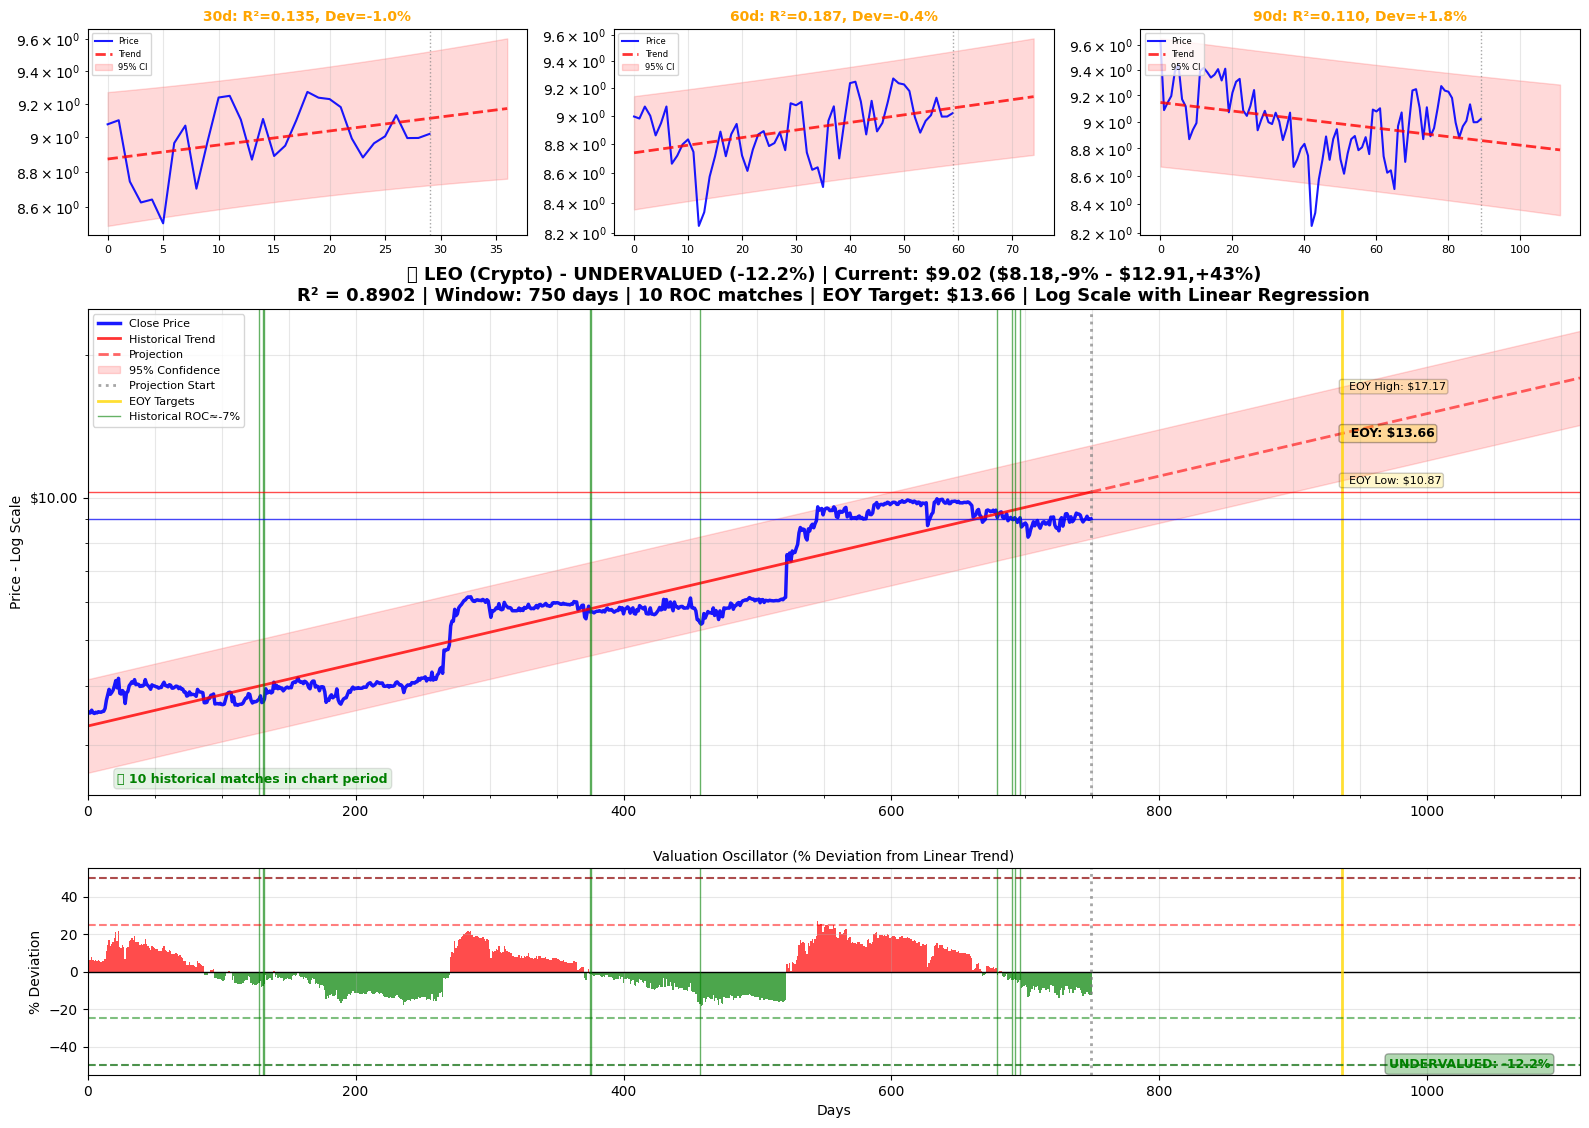


📊 PRICE PROJECTIONS (Linear Regression - 750 days):
   Current: $9.02 ($8.18,-9% - $12.91,+43%)
   +30d (1m): $10.76,+19.3% ($8.56,-5% - $13.51,+50%)
   +60d (2m): $11.26,+24.8% ($8.96,-1% - $14.14,+57%)
   +90d (3m): $11.79,+30.7% ($9.38,+4% - $14.81,+64%)
   +180d (6m): $13.52,+49.8% ($10.76,+19% - $16.98,+88%)
   +365d (1y): $17.91,+98.6% ($14.24,+58% - $22.53,+150%)
   +EOY (187d): $13.66,+51.5% ($10.87,+21% - $17.17,+90%)
   End-of-year outlook: 📈 Bullish Trend (+51.5%)
   Confidence: 89.0% | Valuation: UNDERVALUED
   🎯 Historical pattern matches: 10 periods in chart (90d ROC≈-7%)
   📅 Days until EOY 2025: 187 days | EOY Target: $13.66 (+51.5%)
------------------------------------------------------------

🔮 FORWARD RETURNS ANALYSIS (Round Half Up Matching):
------------------------------------------------------------

LEO - FORWARD RETURNS ANALYSIS (ROC 30-day window)
Current 30-day ROC: -0.78%
Rounded target for matching: -1%
Similar historical periods found: 97
Matching method:

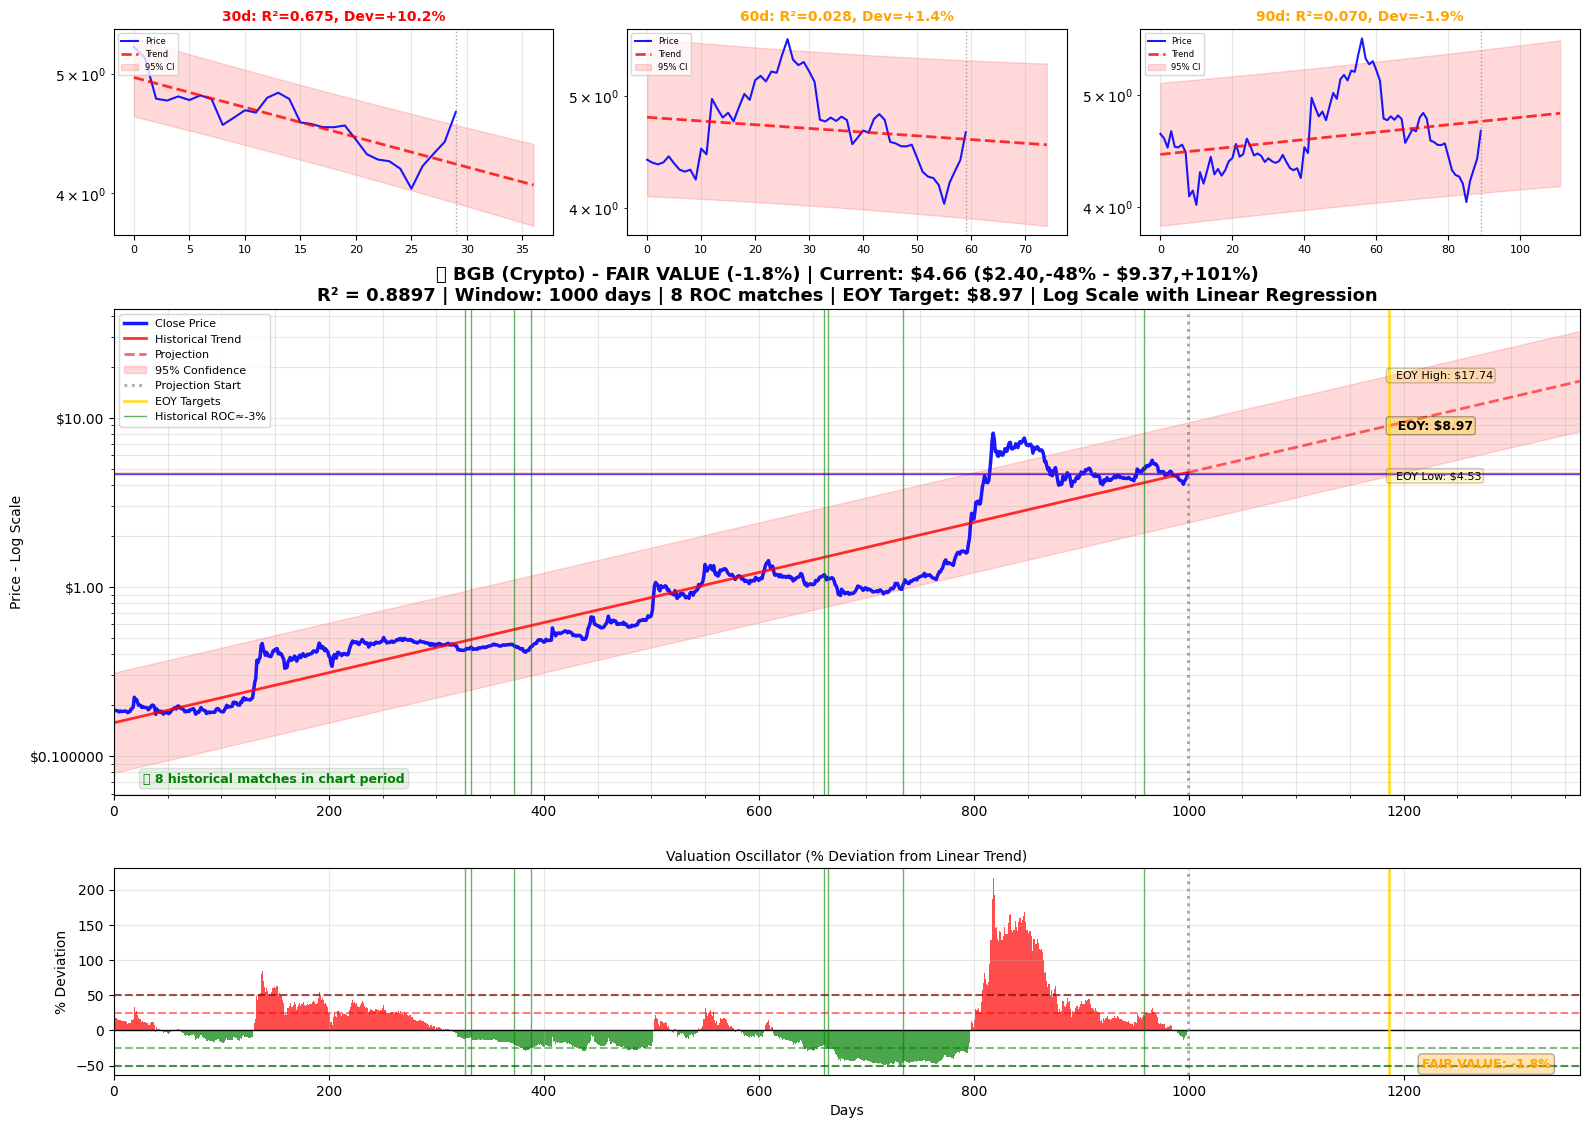


📊 PRICE PROJECTIONS (Linear Regression - 1000 days):
   Current: $4.66 ($2.40,-48% - $9.37,+101%)
   +30d (1m): $5.25,+12.8% ($2.66,-43% - $10.38,+123%)
   +60d (2m): $5.82,+25.0% ($2.94,-37% - $11.50,+147%)
   +90d (3m): $6.44,+38.4% ($3.26,-30% - $12.74,+174%)
   +180d (6m): $8.76,+88.1% ($4.43,-5% - $17.32,+272%)
   +365d (1y): $16.45,+253.4% ($8.31,+78% - $32.58,+600%)
   +EOY (187d): $8.97,+92.7% ($4.53,-3% - $17.74,+281%)
   End-of-year outlook: 📈 Bullish Trend (+92.7%)
   Confidence: 89.0% | Valuation: FAIR VALUE
   🎯 Historical pattern matches: 8 periods in chart (90d ROC≈-3%)
   📅 Days until EOY 2025: 187 days | EOY Target: $8.97 (+92.7%)
------------------------------------------------------------

🔮 FORWARD RETURNS ANALYSIS (Round Half Up Matching):
------------------------------------------------------------

BGB - FORWARD RETURNS ANALYSIS (ROC 30-day window)
Current 30-day ROC: -13.02%
Rounded target for matching: -13%
Similar historical periods found: 19
Matching method:

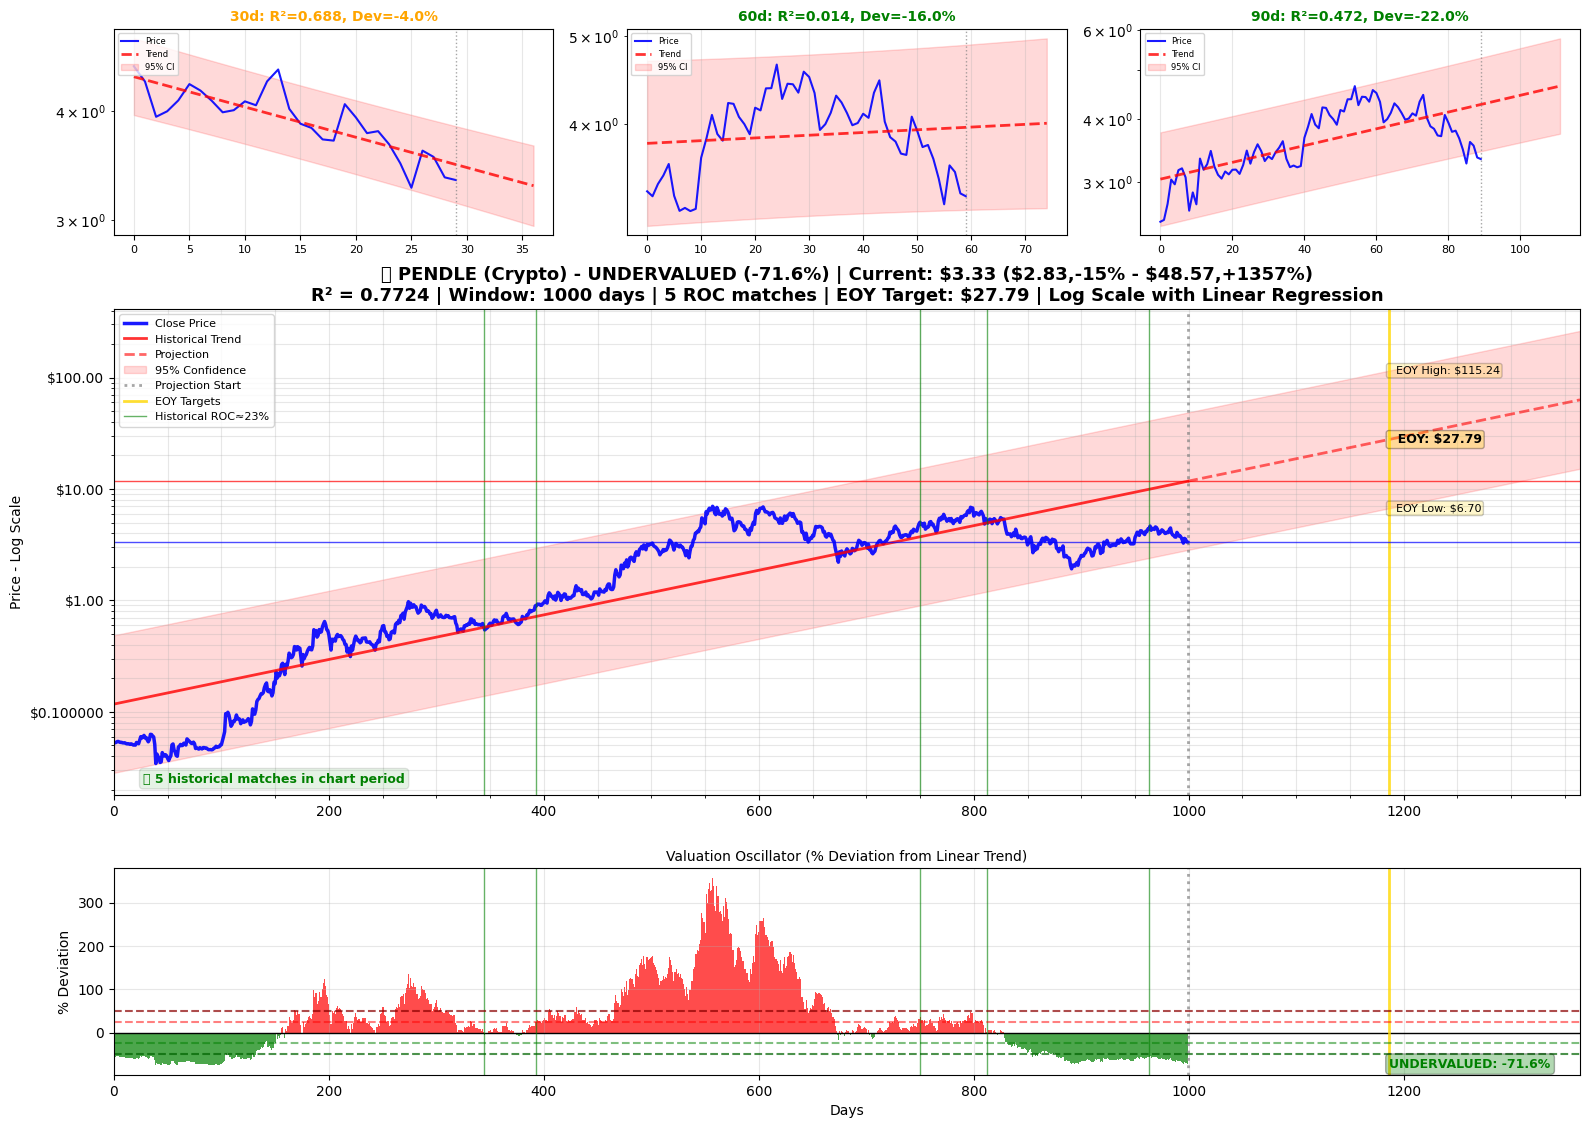


📊 PRICE PROJECTIONS (Linear Regression - 1000 days):
   Current: $3.33 ($2.83,-15% - $48.57,+1357%)
   +30d (1m): $13.47,+304.3% ($3.25,-2% - $55.79,+1574%)
   +60d (2m): $15.47,+364.3% ($3.74,+12% - $64.08,+1823%)
   +90d (3m): $17.77,+433.1% ($4.29,+29% - $73.61,+2109%)
   +180d (6m): $26.91,+707.3% ($6.49,+95% - $111.57,+3248%)
   +365d (1y): $63.13,+1794.4% ($15.19,+356% - $262.43,+7775%)
   +EOY (187d): $27.79,+733.8% ($6.70,+101% - $115.24,+3358%)
   End-of-year outlook: 📈 Bullish Trend (+733.8%)
   Confidence: 77.2% | Valuation: UNDERVALUED
   🎯 Historical pattern matches: 5 periods in chart (90d ROC≈23%)
   📅 Days until EOY 2025: 187 days | EOY Target: $27.79 (+733.8%)
------------------------------------------------------------

🔮 FORWARD RETURNS ANALYSIS (Round Half Up Matching):
------------------------------------------------------------

PENDLE - FORWARD RETURNS ANALYSIS (ROC 30-day window)
Current 30-day ROC: -27.00%
Rounded target for matching: -27%
Similar historical p

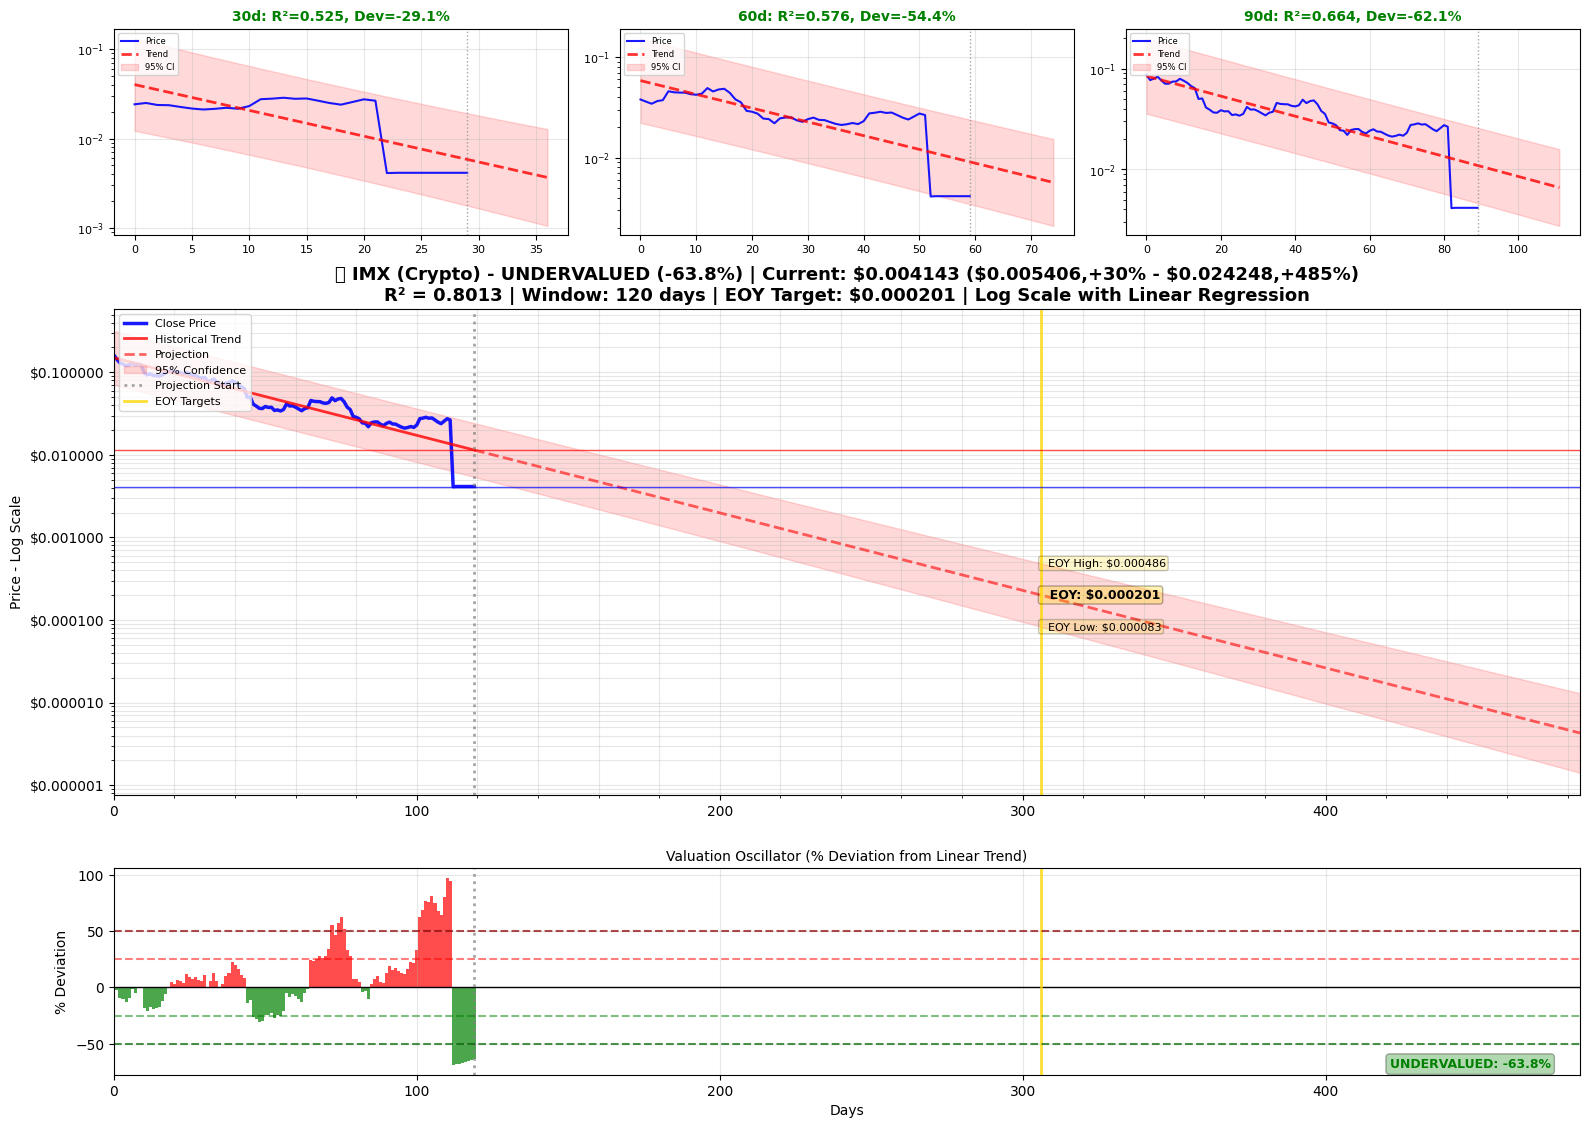


📊 PRICE PROJECTIONS (Linear Regression - 120 days):
   Current: $0.004143 ($0.005406,+30% - $0.024248,+485%)
   +30d (1m): $0.005986,+44.5% ($0.002795,-33% - $0.012820,+209%)
   +60d (2m): $0.003130,-24.5% ($0.001439,-65% - $0.006807,+64%)
   +90d (3m): $0.001636,-60.5% ($0.000738,-82% - $0.003629,-12%)
   +180d (6m): $0.000234,-94.4% ($0.000097,-98% - $0.000561,-86%)
   +365d (1y): $0.000004,-99.9% ($0.000001,-100% - $0.000013,-100%)
   +EOY (187d): $0.000201,-95.1% ($0.000083,-98% - $0.000486,-88%)
   End-of-year outlook: 📉 Bearish Trend (-95.1%)
   Confidence: 80.1% | Valuation: UNDERVALUED
   📅 Days until EOY 2025: 187 days | EOY Target: $0.000201 (-95.1%)
------------------------------------------------------------

🔮 FORWARD RETURNS ANALYSIS (Round Half Up Matching):
------------------------------------------------------------
   ⚠️  Insufficient historical data for forward returns analysis
   💡 Need more historical data or try different ROC windows


Chart 3: SOL-USD (Undervalu

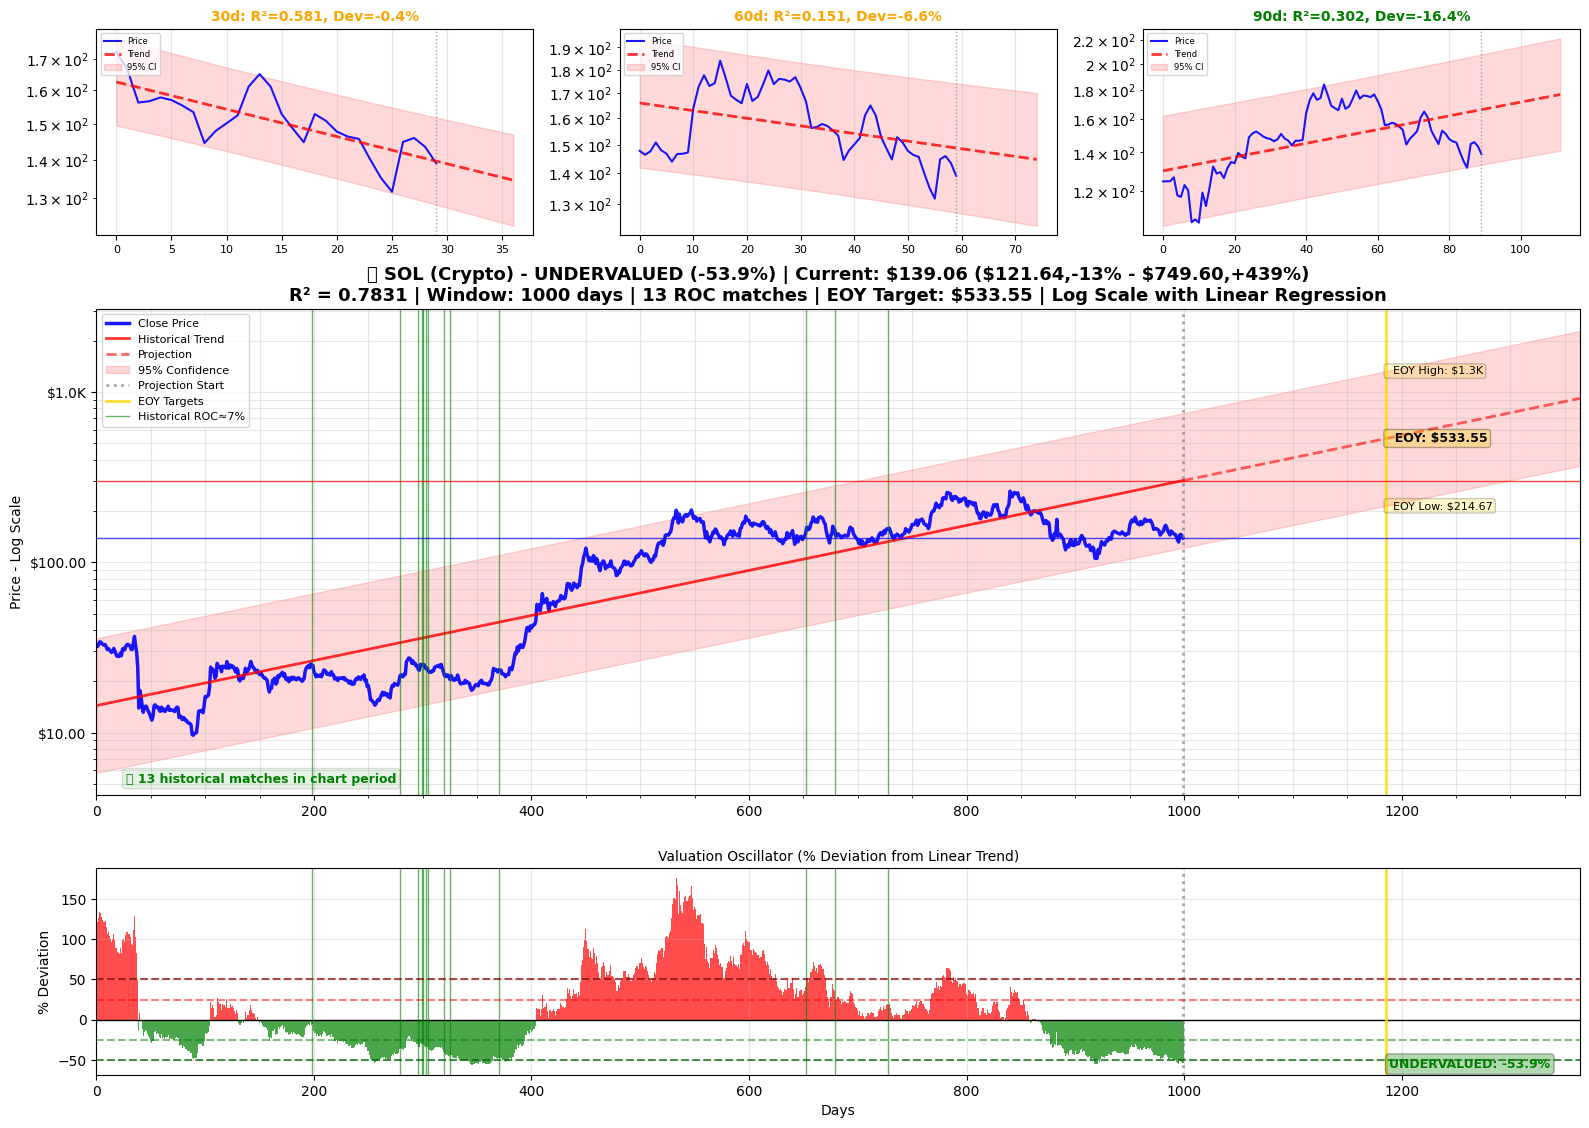


📊 PRICE PROJECTIONS (Linear Regression - 1000 days):
   Current: $139.06 ($121.64,-13% - $749.60,+439%)
   +30d (1m): $330.83,+137.9% ($133.25,-4% - $821.42,+491%)
   +60d (2m): $362.47,+160.7% ($145.96,+5% - $900.13,+547%)
   +90d (3m): $397.13,+185.6% ($159.89,+15% - $986.39,+609%)
   +180d (6m): $522.30,+275.6% ($210.15,+51% - $1.3K,+833%)
   +365d (1y): $917.27,+559.6% ($368.50,+165% - $2.3K,+1542%)
   +EOY (187d): $533.55,+283.7% ($214.67,+54% - $1.3K,+854%)
   End-of-year outlook: 📈 Bullish Trend (+283.7%)
   Confidence: 78.3% | Valuation: UNDERVALUED
   🎯 Historical pattern matches: 13 periods in chart (90d ROC≈7%)
   📅 Days until EOY 2025: 187 days | EOY Target: $533.55 (+283.7%)
------------------------------------------------------------

🔮 FORWARD RETURNS ANALYSIS (Round Half Up Matching):
------------------------------------------------------------

SOL - FORWARD RETURNS ANALYSIS (ROC 30-day window)
Current 30-day ROC: -21.35%
Rounded target for matching: -21%
Similar hist

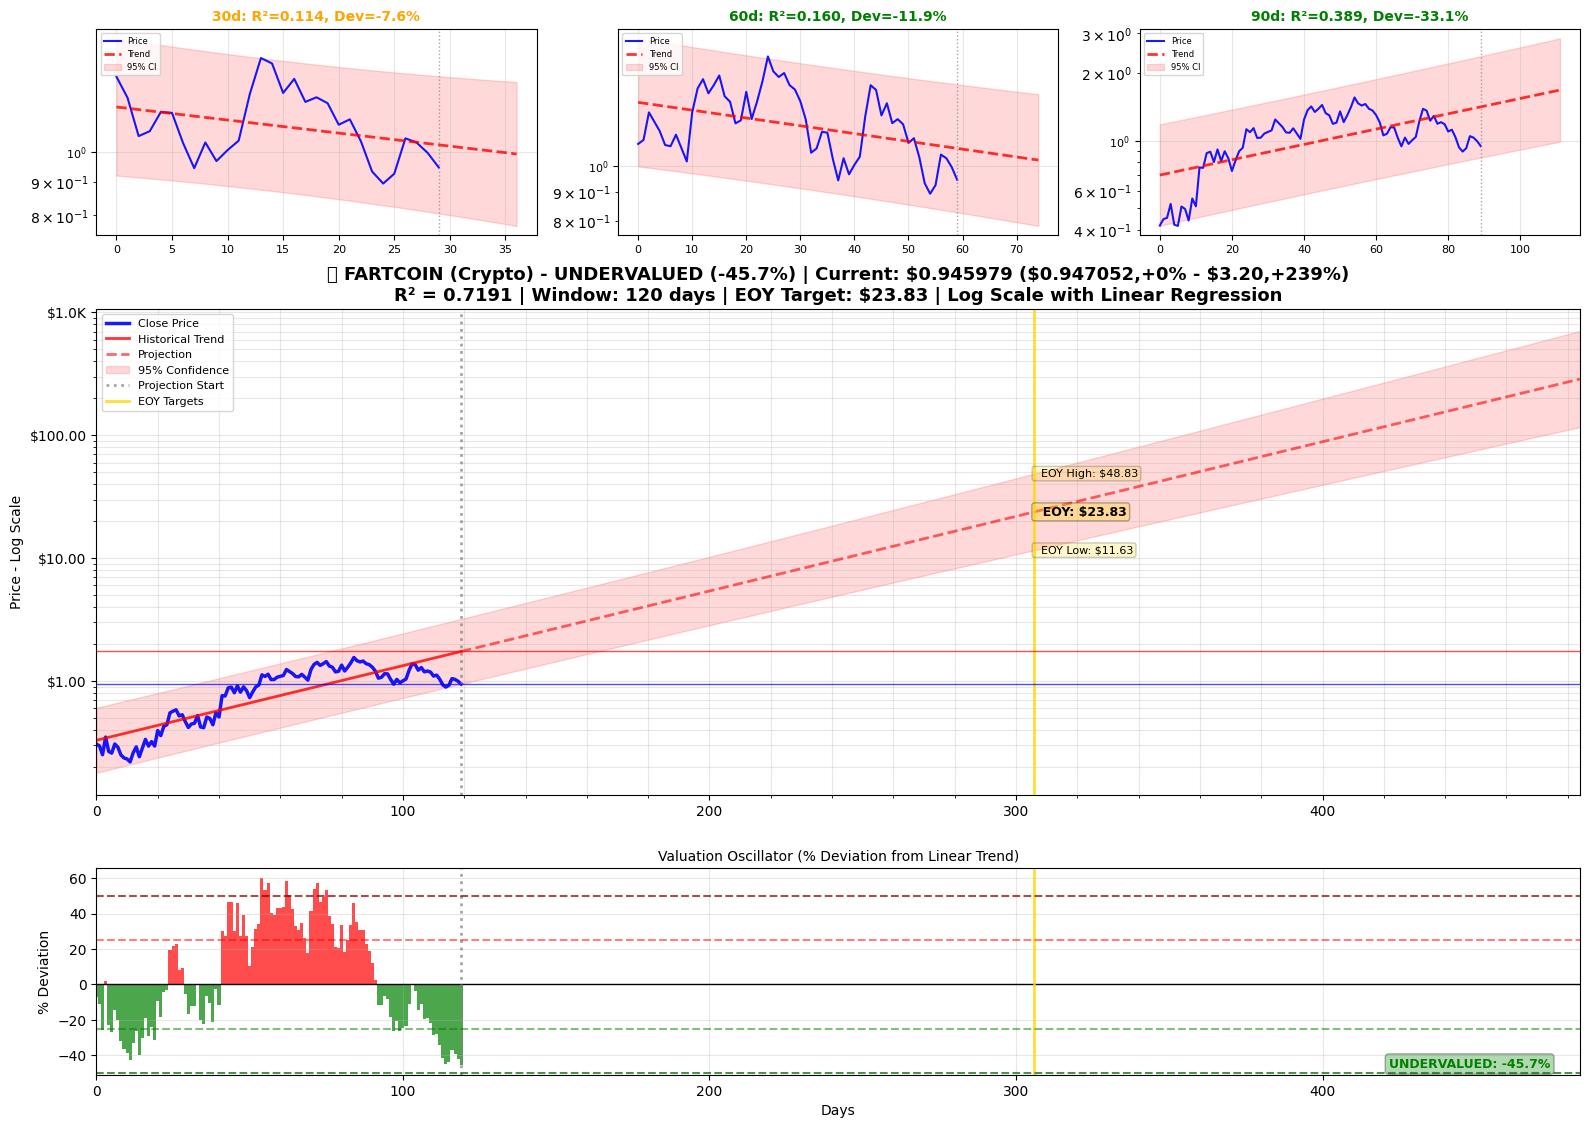


📊 PRICE PROJECTIONS (Linear Regression - 120 days):
   Current: $0.945979 ($0.947052,+0% - $3.20,+239%)
   +30d (1m): $2.65,+180.2% ($1.43,+51% - $4.92,+420%)
   +60d (2m): $4.03,+326.3% ($2.15,+127% - $7.58,+701%)
   +90d (3m): $6.14,+548.6% ($3.21,+240% - $11.72,+1139%)
   +180d (6m): $21.61,+2184.3% ($10.61,+1022% - $44.01,+4552%)
   +365d (1y): $287.45,+30286.5% ($116.69,+12235% - $708.11,+74755%)
   +EOY (187d): $23.83,+2419.3% ($11.63,+1130% - $48.83,+5062%)
   End-of-year outlook: 📈 Bullish Trend (+2419.3%)
   Confidence: 71.9% | Valuation: UNDERVALUED
   📅 Days until EOY 2025: 187 days | EOY Target: $23.83 (+2419.3%)
------------------------------------------------------------

🔮 FORWARD RETURNS ANALYSIS (Round Half Up Matching):
------------------------------------------------------------
   ⚠️  Insufficient historical data for forward returns analysis
   💡 Need more historical data or try different ROC windows


Chart 5: HYPE-USD (Undervalued by 41.2%)


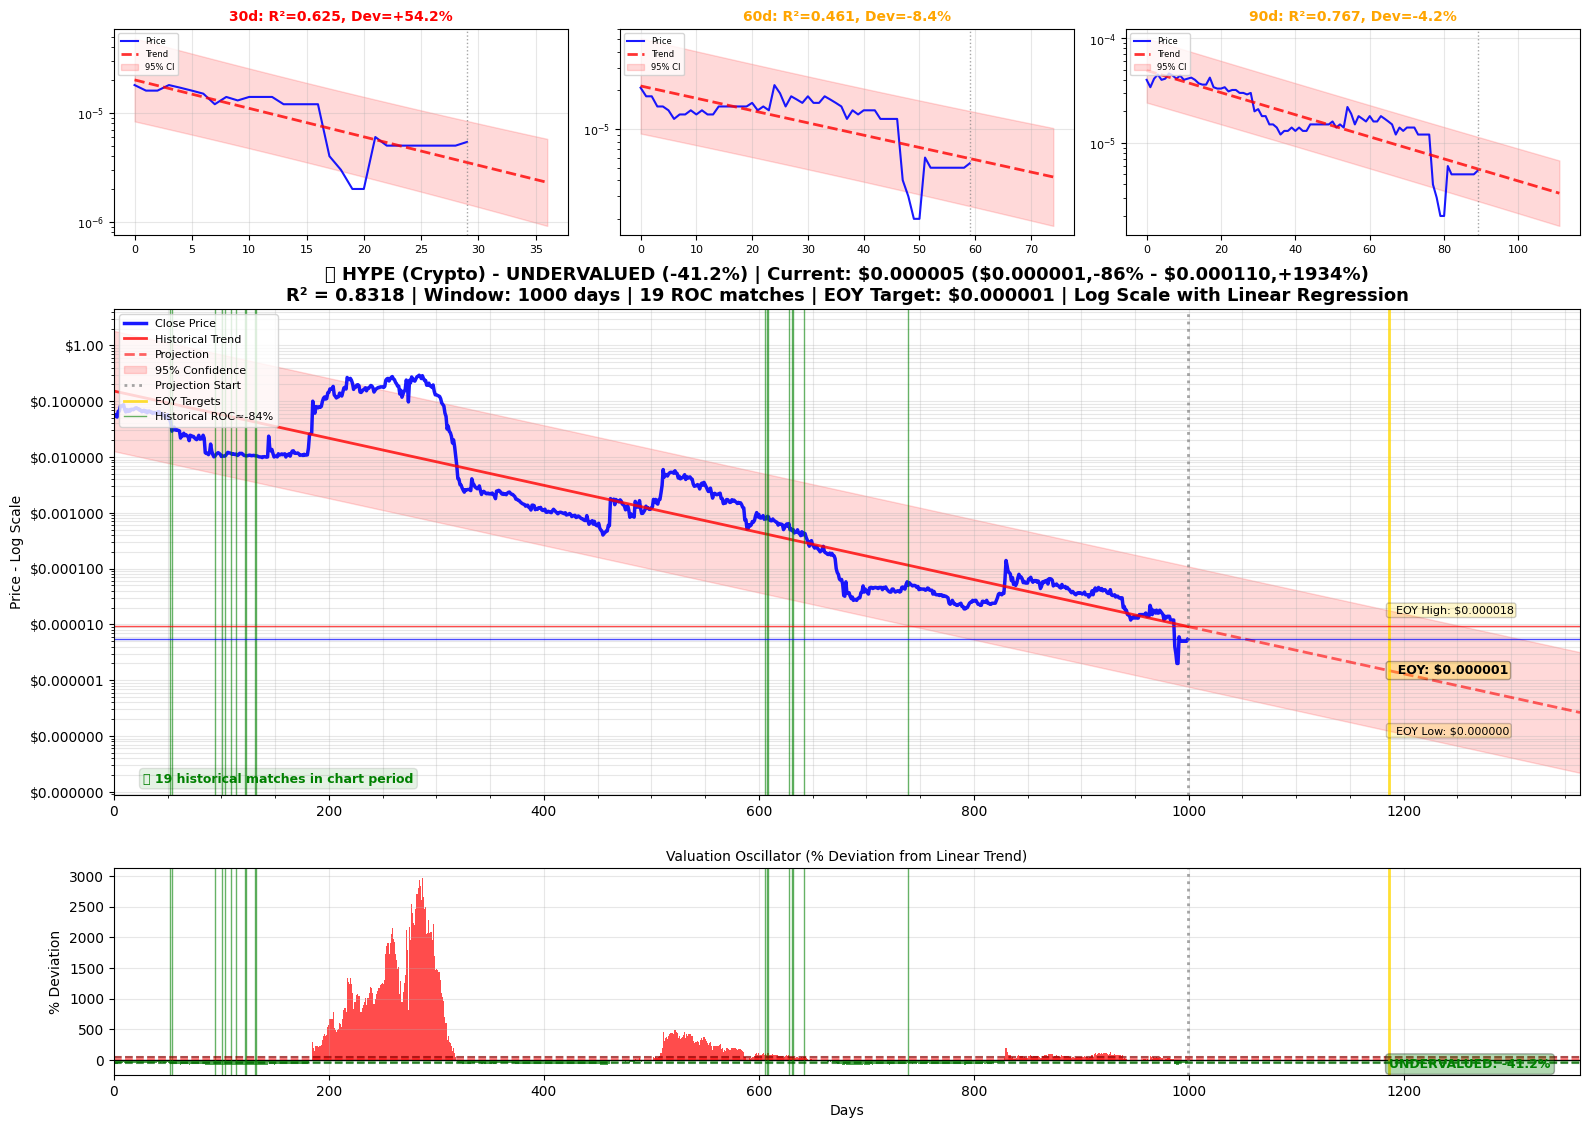


📊 PRICE PROJECTIONS (Linear Regression - 1000 days):
   Current: $0.000005 ($0.000001,-86% - $0.000110,+1934%)
   +30d (1m): $0.000007,+27.1% ($0.000001,-89% - $0.000082,+1420%)
   +60d (2m): $0.000005,-5.0% ($0.000000,-92% - $0.000061,+1036%)
   +90d (3m): $0.000004,-29.1% ($0.000000,-94% - $0.000046,+749%)
   +180d (6m): $0.000002,-70.4% ($0.000000,-98% - $0.000019,+255%)
   +365d (1y): $0.000000,-95.1% ($0.000000,-100% - $0.000003,-41%)
   +EOY (187d): $0.000001,-72.4% ($0.000000,-98% - $0.000018,+231%)
   End-of-year outlook: 📉 Bearish Trend (-72.4%)
   Confidence: 83.2% | Valuation: UNDERVALUED
   🎯 Historical pattern matches: 19 periods in chart (90d ROC≈-84%)
   📅 Days until EOY 2025: 187 days | EOY Target: $0.000001 (-72.4%)
------------------------------------------------------------

🔮 FORWARD RETURNS ANALYSIS (Round Half Up Matching):
------------------------------------------------------------

HYPE - FORWARD RETURNS ANALYSIS (ROC 30-day window)
Current 30-day ROC: -66.23%

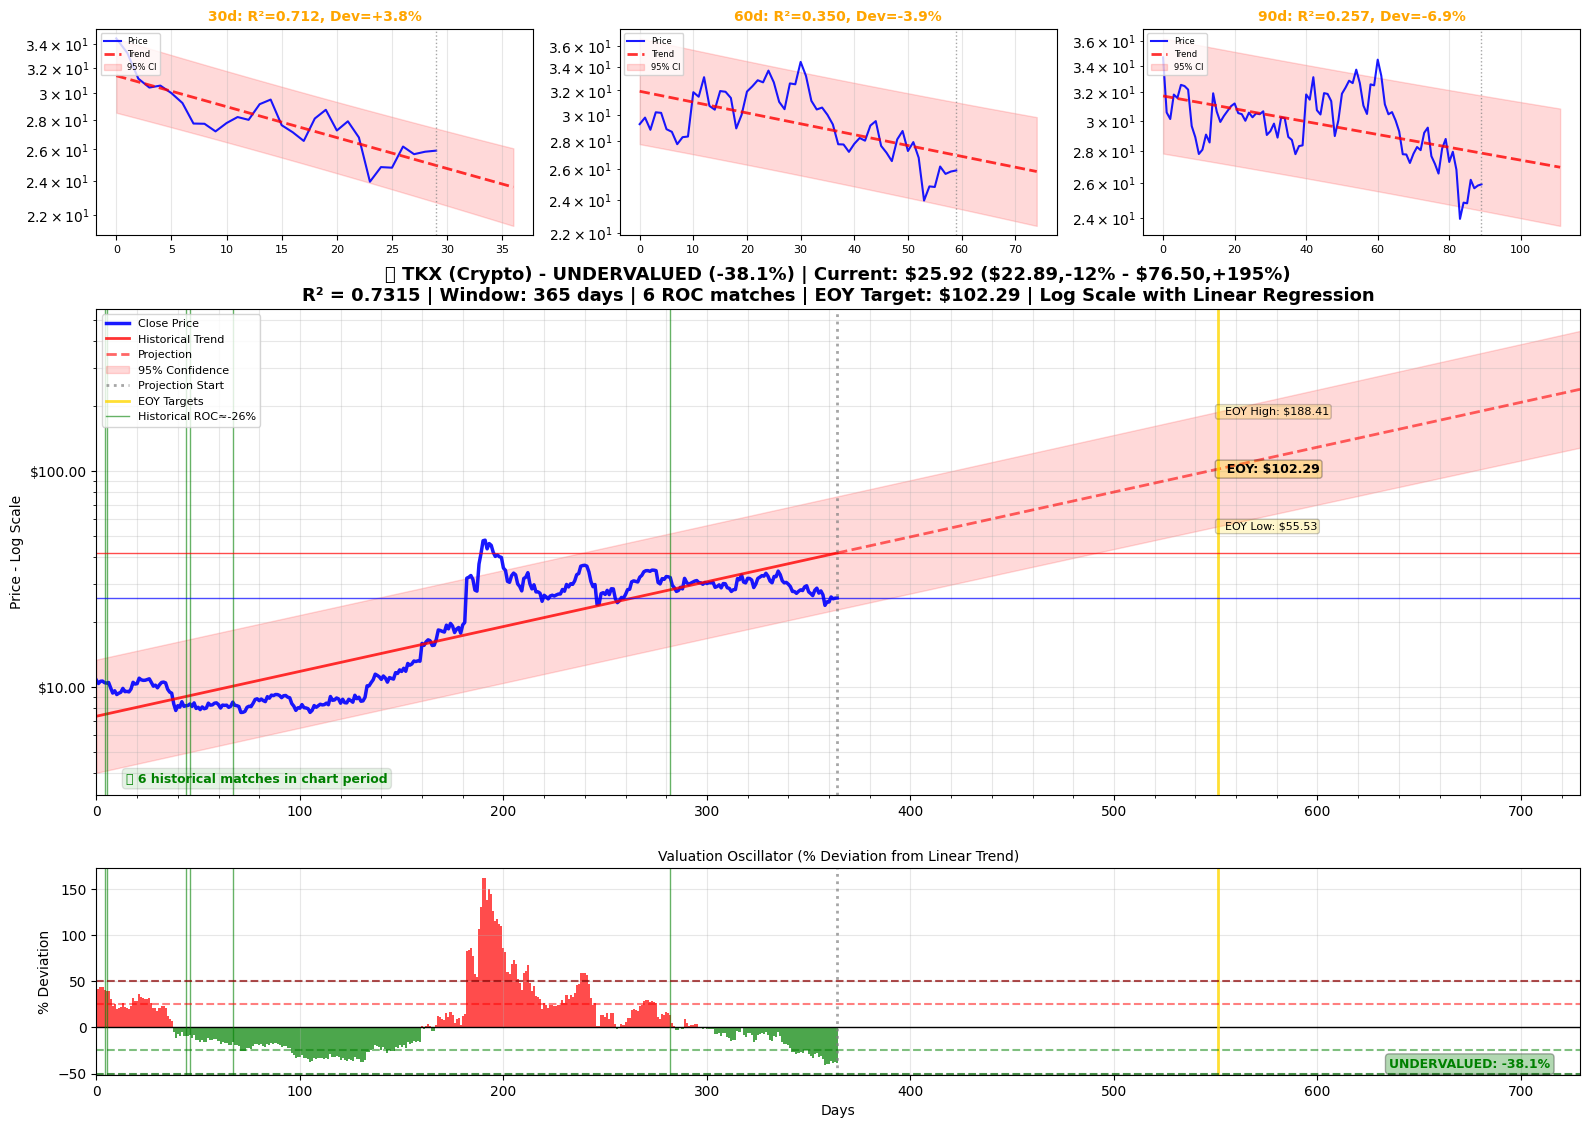


📊 PRICE PROJECTIONS (Linear Regression - 365 days):
   Current: $25.92 ($22.89,-12% - $76.50,+195%)
   +30d (1m): $48.30,+86.3% ($26.40,+2% - $88.37,+241%)
   +60d (2m): $55.75,+115.1% ($30.44,+17% - $102.10,+294%)
   +90d (3m): $64.34,+148.2% ($35.09,+35% - $117.97,+355%)
   +180d (6m): $98.92,+281.6% ($53.73,+107% - $182.14,+603%)
   +365d (1y): $239.51,+824.0% ($128.52,+396% - $446.37,+1622%)
   +EOY (187d): $102.29,+294.6% ($55.53,+114% - $188.41,+627%)
   End-of-year outlook: 📈 Bullish Trend (+294.6%)
   Confidence: 73.2% | Valuation: UNDERVALUED
   🎯 Historical pattern matches: 6 periods in chart (90d ROC≈-26%)
   📅 Days until EOY 2025: 187 days | EOY Target: $102.29 (+294.6%)
------------------------------------------------------------

🔮 FORWARD RETURNS ANALYSIS (Round Half Up Matching):
------------------------------------------------------------

TKX - FORWARD RETURNS ANALYSIS (ROC 30-day window)
Current 30-day ROC: -20.29%
Rounded target for matching: -20%
Similar historica

In [ ]:
import pandas as pd
import numpy as np
import math
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

def infer_asset_type(symbol):
    """Infer asset type from symbol patterns"""
    if symbol.endswith('-USD'):
        return 'crypto'
    elif symbol.endswith('=F'):
        return 'futures'
    elif symbol.endswith('=X') or symbol == 'DX-Y.NYB':
        return 'currency'
    elif symbol.startswith('^') or symbol.endswith('.SS') or symbol.endswith('.ME'):
        return 'indices'
    else:
        return 'stock'

def get_asset_specific_windows(asset_type):
    """Get appropriate analysis windows for different asset types"""
    if asset_type == 'crypto':
        # Crypto trades 24/7, use calendar days
        return [30, 60, 90, 120, 180, 365, 500, 750, 1000]
    elif asset_type == 'futures':
        # Futures trade extended hours, use calendar days but shorter range
        return [30, 60, 90, 120, 180, 250, 365, 500, 750, 1000]
    elif asset_type == 'currency':
        # Forex trades 24/5, use calendar days (similar to crypto but slightly more conservative)
        return [30, 60, 90, 120, 180, 250, 365, 500, 750, 1000]
    elif asset_type == 'indices':
        # Indices trade during market hours, use trading days equivalent
        return [21, 42, 63, 84, 126, 189, 252, 378, 504, 1008]  # ~1m, 2m, 3m, 4m, 6m, 9m, 1y, 1.5y, 2y
    else:  # stocks
        # Stocks trade business days, use trading days equivalent
        return [21, 42, 63, 84, 126, 189, 252, 378, 504, 1008]  # ~1m, 2m, 3m, 4m, 6m, 9m, 1y, 1.5y, 2y

def format_price(price, asset_type):
    """Format prices appropriately based on asset type and value"""
    if asset_type == 'crypto':
        if price >= 1000000:
            return f'${price/1000000:.2f}M'
        elif price >= 1000:
            return f'${price/1000:.1f}K'
        elif price >= 1:
            return f'${price:.2f}'
        else:
            return f'${price:.6f}'
    elif asset_type == 'currency':
        # Currency pairs typically show 4-5 decimal places and no dollar sign
        if price >= 100:
            return f'{price:.2f}'  # For pairs like USDJPY
        elif price >= 10:
            return f'{price:.3f}'  # For most major pairs
        else:
            return f'{price:.4f}'  # For very precise pairs
    elif asset_type == 'indices':
        # Indices are typically shown as point values without dollar signs
        if price >= 1000000:
            return f'{price/1000000:.2f}M'
        elif price >= 1000:
            return f'{price/1000:.1f}K'
        else:
            return f'{price:.2f}'
    else:  # futures and stocks
        if price >= 1000000:
            return f'${price/1000000:.2f}M'
        elif price >= 1000:
            return f'${price/1000:.1f}K'
        else:
            return f'${price:.2f}'

def calculate_roc(prices, window):
    """Calculate Rate of Change (ROC) for given window"""
    if len(prices) < window + 1:
        return np.full(len(prices), np.nan)
    
    roc = np.full(len(prices), np.nan)
    for i in range(window, len(prices)):
        if prices[i-window] != 0 and not np.isnan(prices[i-window]) and not np.isnan(prices[i]):
            roc[i] = ((prices[i] - prices[i-window]) / prices[i-window]) * 100
    
    return roc

def find_similar_periods(current_roc, historical_roc, tolerance_type='round_to_nearest'):
    """
    Find historical periods similar to current ROC using traditional round half up
    
    Parameters:
    - current_roc: Current ROC value to match
    - historical_roc: Array of historical ROC values
    - tolerance_type: 'round_to_nearest', 'round_to_half', or 'round_to_quarter'
    
    Examples:
    - 2.5% rounds to 3% (round half up)
    - 5.25% rounds to 5%
    - 9.23% rounds to 9%
    """
    if np.isnan(current_roc):
        return []
    
    if tolerance_type == 'round_to_nearest':
        target_roc = math.floor(current_roc + 0.5)
        historical_rounded = np.array([math.floor(x + 0.5) if not np.isnan(x) else np.nan for x in historical_roc])
        similar_mask = (historical_rounded == target_roc) & ~np.isnan(historical_roc)
        
    elif tolerance_type == 'round_to_half':
        target_roc = math.floor(current_roc * 2 + 0.5) / 2
        historical_rounded = np.array([math.floor(x * 2 + 0.5) / 2 if not np.isnan(x) else np.nan for x in historical_roc])
        similar_mask = (historical_rounded == target_roc) & ~np.isnan(historical_roc)
        
    elif tolerance_type == 'round_to_quarter':
        target_roc = math.floor(current_roc * 4 + 0.5) / 4
        historical_rounded = np.array([math.floor(x * 4 + 0.5) / 4 if not np.isnan(x) else np.nan for x in historical_roc])
        similar_mask = (historical_rounded == target_roc) & ~np.isnan(historical_roc)
        
    else:
        target_roc = math.floor(current_roc + 0.5)
        historical_rounded = np.array([math.floor(x + 0.5) if not np.isnan(x) else np.nan for x in historical_roc])
        similar_mask = (historical_rounded == target_roc) & ~np.isnan(historical_roc)
    
    similar_indices = np.where(similar_mask)[0]
    return similar_indices.tolist()

def calculate_forward_returns(prices, start_indices, forward_windows):
    """Calculate forward returns from given start indices"""
    forward_returns = {window: [] for window in forward_windows}
    
    for start_idx in start_indices:
        for window in forward_windows:
            end_idx = start_idx + window
            if end_idx < len(prices):
                start_price = prices[start_idx]
                end_price = prices[end_idx]
                
                if not np.isnan(start_price) and not np.isnan(end_price) and start_price != 0:
                    forward_return = ((end_price - start_price) / start_price) * 100
                    forward_returns[window].append(forward_return)
    
    return forward_returns

def analyze_forward_returns(df_data, symbol, roc_windows=[30, 90], forward_windows=[7, 14, 30, 90, 180, 365], 
                          tolerance_type='round_to_nearest', cycle_year=None, quarter=None, 
                          min_similar_periods=5, exclude_recent_days=30):
    """
    Enhanced forward returns analysis with simple rounding-based similarity
    
    Parameters:
    - df_data: DataFrame with time series data
    - symbol: Symbol to analyze
    - roc_windows: ROC calculation windows (e.g., [30, 90])
    - forward_windows: Forward return periods to analyze
    - tolerance_type: 'round_to_nearest' (default), 'round_to_half', or 'round_to_quarter'
    - cycle_year: Filter by cycle years (e.g., ['Year1', 'Year2'])
    - quarter: Filter by quarters (e.g., [1, 2, 3, 4])
    - min_similar_periods: Minimum similar periods required
    - exclude_recent_days: Days to exclude from analysis to avoid look-ahead bias
    
    Examples:
    - ROC 2.5% finds all periods that round to 3% (round half up)
    - ROC 5.25% finds all periods that round to 5%
    - ROC 9.23% finds all periods that round to 9%
    - ROC -3.67% finds all periods that round to -4%
    """
    instrument_data = df_data[df_data['symbol'] == symbol].copy()
    instrument_data = instrument_data.sort_values('time').reset_index(drop=True)
    
    if len(instrument_data) < max(forward_windows) + max(roc_windows) + exclude_recent_days:
        return None
    
    # Add date components for filtering
    instrument_data['time'] = pd.to_datetime(instrument_data['time'])
    instrument_data['year'] = instrument_data['time'].dt.year
    instrument_data['quarter'] = instrument_data['time'].dt.quarter
    instrument_data['month'] = instrument_data['time'].dt.month
    
    # Create cycle year (4-year cycles starting from first year)
    min_year = instrument_data['year'].min()
    instrument_data['cycle_year'] = ((instrument_data['year'] - min_year) % 4) + 1
    instrument_data['cycle_year_label'] = 'Year' + instrument_data['cycle_year'].astype(str)
    
    prices = instrument_data['close'].values
    results = {}
    
    for roc_window in roc_windows:
        # Calculate ROC for the entire time series
        roc_values = calculate_roc(prices, roc_window)
        
        # Get current ROC (most recent)
        current_roc = roc_values[-1]
        
        if np.isnan(current_roc):
            continue
        
        # Calculate target rounded value for similarity matching
        if tolerance_type == 'round_to_nearest':
            target_rounded = math.floor(current_roc + 0.5)
        elif tolerance_type == 'round_to_half':
            target_rounded = math.floor(current_roc * 2 + 0.5) / 2
        elif tolerance_type == 'round_to_quarter':
            target_rounded = math.floor(current_roc * 4 + 0.5) / 4
        else:
            target_rounded = math.floor(current_roc + 0.5)
        
        # Find similar historical periods (excluding recent period)
        exclude_recent = exclude_recent_days
        historical_roc = roc_values[:-exclude_recent]
        similar_indices = find_similar_periods(current_roc, historical_roc, tolerance_type=tolerance_type)
        
        # Apply cycle year filter if specified
        if cycle_year is not None:
            filtered_indices = []
            for idx in similar_indices:
                if idx < len(instrument_data) and instrument_data.iloc[idx]['cycle_year_label'] in cycle_year:
                    filtered_indices.append(idx)
            similar_indices = filtered_indices
        
        # Apply quarter filter if specified
        if quarter is not None:
            filtered_indices = []
            for idx in similar_indices:
                if idx < len(instrument_data) and instrument_data.iloc[idx]['quarter'] in quarter:
                    filtered_indices.append(idx)
            similar_indices = filtered_indices
        
        if len(similar_indices) < min_similar_periods:
            continue
        
        # Calculate forward returns from similar periods
        forward_returns = calculate_forward_returns(prices, similar_indices, forward_windows)
        
        # Calculate statistics for each forward window
        stats_data = []
        for window in forward_windows:
            returns = forward_returns[window]
            if len(returns) >= 3:
                count = len(returns)
                pct_positive = (np.sum(np.array(returns) > 0) / count) * 100
                median_return = np.median(returns)
                mean_return = np.mean(returns)
                std_return = np.std(returns)
                
                # 95% Confidence interval for mean
                se = std_return / np.sqrt(count)
                t_val = stats.t.ppf(0.975, count - 1)
                ci_lower = mean_return - t_val * se
                ci_upper = mean_return + t_val * se
                
                min_return = np.min(returns)
                max_return = np.max(returns)
                
                stats_data.append({
                    'window': window,
                    'count': count,
                    'pct_positive': pct_positive,
                    'median': median_return,
                    'mean': mean_return,
                    'std': std_return,
                    'ci_lower': ci_lower,
                    'ci_upper': ci_upper,
                    'min': min_return,
                    'max': max_return
                })
        
        # Add filtering info to results
        filter_info = {
            'target_rounded': target_rounded,
            'tolerance_type': tolerance_type,
            'cycle_year_filter': cycle_year,
            'quarter_filter': quarter,
            'exclude_recent_days': exclude_recent_days
        }
        
        results[roc_window] = {
            'current_roc': current_roc,
            'target_rounded': target_rounded,
            'similar_count': len(similar_indices),
            'stats': stats_data,
            'filter_info': filter_info
        }
    
    return results

def display_forward_returns_analysis(symbol, forward_analysis):
    """Display enhanced forward returns analysis with rounding-based similarity"""
    if not forward_analysis:
        return
    
    symbol_display = symbol.replace('-USD', '').replace('=F', '').replace('=X', '').replace('DX-Y.NYB', 'DXY').replace('^', '').replace('.SS', '').replace('.ME', '').upper()
    
    for roc_window, analysis in forward_analysis.items():
        print(f"\n{'='*120}")
        print(f"{symbol_display} - FORWARD RETURNS ANALYSIS (ROC {roc_window}-day window)")
        print(f"{'='*120}")
        print(f"Current {roc_window}-day ROC: {analysis['current_roc']:.2f}%")
        print(f"Rounded target for matching: {analysis['target_rounded']:.0f}%")
        print(f"Similar historical periods found: {analysis['similar_count']}")
        
        # Display filtering criteria
        filter_info = analysis.get('filter_info', {})
        tolerance_type = filter_info.get('tolerance_type', 'round_to_nearest')
        
        if tolerance_type == 'round_to_nearest':
            print(f"Matching method: Round half up to nearest integer (2.5% → 3%, 5.25% → 5%, 9.23% → 9%)")
        elif tolerance_type == 'round_to_half':
            print(f"Matching method: Round half up to nearest 0.5 (5.25% → 5.5%, 5.1% → 5.0%)")
        elif tolerance_type == 'round_to_quarter':
            print(f"Matching method: Round half up to nearest 0.25 (5.13% → 5.25%, 5.37% → 5.25%)")
        
        if filter_info.get('cycle_year_filter'):
            print(f"Cycle year filter: {filter_info['cycle_year_filter']}")
        if filter_info.get('quarter_filter'):
            print(f"Quarter filter: Q{filter_info['quarter_filter']}")
        
        print(f"Excluded recent {filter_info.get('exclude_recent_days', 30)} days to avoid look-ahead bias")
        print(f"{'='*120}")
        print(f"")
        print(f"Forward Returns Summary:")
        print(f"{'-'*120}")
        print(f"{'Window':<8} {'Count':<8} {'% Positive':<12} {'Median':<10} {'Mean':<10} {'Std Dev':<10} {'95% CI Lower':<12} {'95% CI Upper':<12} {'Min':<10} {'Max':<10}")
        print(f"{'-'*120}")
        
        for stat in analysis['stats']:
            print(f"{stat['window']:>3} days {stat['count']:>8} {stat['pct_positive']:>10.1f}% "
                  f"{stat['median']:>9.2f}% {stat['mean']:>9.2f}% {stat['std']:>9.2f}% "
                  f"{stat['ci_lower']:>11.2f}% {stat['ci_upper']:>11.2f}% "
                  f"{stat['min']:>9.2f}% {stat['max']:>9.2f}%")
        
        print(f"")

def calculate_undervaluation_metrics(df, asset_type, window_sizes=None):
    """Calculate undervaluation metrics for a single instrument"""
    if window_sizes is None:
        window_sizes = get_asset_specific_windows(asset_type)
    
    undervaluation_data = []
    
    for window in window_sizes:
        if window >= len(df):
            continue
            
        # Get recent data
        recent_data = df.tail(window).copy().reset_index(drop=True)
        
        if len(recent_data) < 10 or recent_data['close'].isna().any():
            continue
        
        # Fit regression on log scale
        X = np.arange(len(recent_data)).reshape(-1, 1)
        y_log = np.log(recent_data['close'].values)
        
        model = LinearRegression()
        model.fit(X, y_log)
        
        # Calculate current deviation
        y_log_pred = model.predict(X)
        fitted_prices = np.exp(y_log_pred)
        current_price = recent_data['close'].iloc[-1]
        trend_price = fitted_prices[-1]
        
        # Percentage deviation (negative = undervalued)
        deviation_pct = ((current_price - trend_price) / trend_price) * 100
        
        # R-squared for trend quality
        r2 = r2_score(y_log, y_log_pred)
        
        # Annual growth rate (adjust for asset type)
        slope = model.coef_[0]
        if asset_type in ['crypto', 'currency']:
            annual_growth = (np.exp(slope) ** 365 - 1) * 100  # 365 days
        else:  # futures, stock, indices
            annual_growth = (np.exp(slope) ** 252 - 1) * 100  # 252 trading days
        
        undervaluation_data.append({
            'window_days': window,
            'deviation_pct': deviation_pct,
            'r_squared': r2,
            'annual_growth': annual_growth,
            'current_price': current_price,
            'trend_price': trend_price,
            'window_start_price': recent_data['close'].iloc[0],
            'window_end_price': recent_data['close'].iloc[-1]
        })
    
    return undervaluation_data

def find_best_regression_channels(df, asset_type, top_n=3, window_sizes=None):
    """Find the top N best fitting linear regression channels"""
    if window_sizes is None:
        window_sizes = get_asset_specific_windows(asset_type)
    
    results = []
    
    for window in window_sizes:
        if window >= len(df):
            continue
            
        # Get the most recent 'window' days
        recent_data = df.tail(window).copy()
        recent_data = recent_data.reset_index(drop=True)
        
        # Check if we have enough valid data
        if len(recent_data) < 10 or recent_data['close'].isna().any():
            continue
        
        # Prepare data for regression (log scale)
        X = np.arange(len(recent_data)).reshape(-1, 1)
        y = np.log(recent_data['close'].values)
        
        # Fit linear regression
        model = LinearRegression()
        model.fit(X, y)
        
        # Make predictions
        y_pred = model.predict(X)
        
        # Calculate R-squared
        r2 = r2_score(y, y_pred)
        
        # Calculate other metrics (converting back from log scale)
        slope = model.coef_[0]  # This is now log slope
        intercept = model.intercept_  # This is now log intercept
        start_price = recent_data['close'].iloc[0]
        end_price = recent_data['close'].iloc[-1]
        
        # Annual growth rate based on asset type
        if asset_type in ['crypto', 'currency']:
            annual_growth_rate = (np.exp(slope) ** 365 - 1) * 100
        else:  # futures, stock, indices
            annual_growth_rate = (np.exp(slope) ** 252 - 1) * 100
        
        # Store results
        results.append({
            'window_size': window,
            'r_squared': r2,
            'log_slope': slope,
            'daily_growth_rate': np.exp(slope) - 1,
            'annual_growth_rate': annual_growth_rate,
            'log_intercept': intercept,
            'start_price': start_price,
            'end_price': end_price,
            'price_change': end_price - start_price,
            'price_change_pct': ((end_price - start_price) / start_price) * 100
        })
    
    # Sort by R-squared (best fit first)
    results_df = pd.DataFrame(results)
    if len(results_df) > 0:
        results_df = results_df.sort_values('r_squared', ascending=False)
        return results_df.head(top_n)
    else:
        return pd.DataFrame()

def analyze_single_instrument(df_data, symbol, asset_type, top_n=3, min_data_points=30):
    """Analyze a single instrument (crypto/futures/stock/currency/indices)"""
    instrument_data = df_data[df_data['symbol'] == symbol].copy()
    instrument_data = instrument_data.sort_values('time').reset_index(drop=True)
    
    if len(instrument_data) < min_data_points:
        return None
    
    # Find best regression channels
    top_channels = find_best_regression_channels(instrument_data, asset_type, top_n=top_n)
    
    if len(top_channels) == 0:
        return None
    
    # Calculate undervaluation metrics
    underval_metrics = calculate_undervaluation_metrics(instrument_data, asset_type)
    
    if not underval_metrics:
        return None
    
    # Find best reliable trend for undervaluation analysis
    valid_metrics = [m for m in underval_metrics if m['r_squared'] >= 0.7]
    
    if valid_metrics:
        best_underval = max(valid_metrics, key=lambda x: x['r_squared'])
        
        # Determine valuation status
        deviation = best_underval['deviation_pct']
        if deviation < -10:  # More than 10% below trend
            valuation_status = 'UNDERVALUED'
        elif deviation > 10:  # More than 10% above trend
            valuation_status = 'OVERVALUED'
        else:
            valuation_status = 'FAIR_VALUE'
        
        underval_info = {
            'deviation_pct': deviation,
            'valuation_status': valuation_status,
            'trend_r_squared': best_underval['r_squared'],
            'trend_window': best_underval['window_days'],
            'current_price': best_underval['current_price'],
            'trend_price': best_underval['trend_price'],
            'annual_trend_growth': best_underval['annual_growth']
        }
    else:
        underval_info = None
    
    # Add metadata to results
    for i, (idx, channel) in enumerate(top_channels.iterrows()):
        top_channels.loc[idx, 'symbol'] = symbol
        top_channels.loc[idx, 'asset_type'] = asset_type
        top_channels.loc[idx, 'rank'] = i + 1
        
        if underval_info:
            for key, value in underval_info.items():
                top_channels.loc[idx, key] = value
    
    return top_channels

def analyze_all_instruments_by_asset_type(df_data, top_n_per_symbol=1, min_data_points=30):
    """Analyze all instruments grouped by asset type"""
    
    # Add asset_type if not present
    if 'asset_type' not in df_data.columns:
        df_data['asset_type'] = df_data['symbol'].apply(infer_asset_type)
    
    # Get unique symbols by asset type
    asset_symbols = df_data.groupby('asset_type')['symbol'].unique()
    
    print(f"Analyzing instruments by asset type...")
    for asset_type, symbols in asset_symbols.items():
        print(f"  {asset_type}: {len(symbols)} instruments")
    
    all_results = []
    processed_count = 0
    successful_count = 0
    
    # Process each asset type
    for asset_type in ['crypto', 'futures', 'stock', 'currency', 'indices']:
        if asset_type not in asset_symbols:
            continue
            
        symbols = asset_symbols[asset_type]
        print(f"\nProcessing {len(symbols)} {asset_type} instruments...")
        
        for i, symbol in enumerate(symbols, 1):
            processed_count += 1
            
            try:
                result = analyze_single_instrument(df_data, symbol, asset_type, 
                                                 top_n=top_n_per_symbol, 
                                                 min_data_points=min_data_points)
                if result is not None and len(result) > 0:
                    all_results.append(result)
                    successful_count += 1
                    
            except Exception as e:
                continue  # Skip problematic symbols
            
            # Progress update
            if i % 25 == 0:
                print(f"  Progress: {i}/{len(symbols)} {asset_type} instruments processed")
    
    print(f"\nAnalysis complete: {successful_count}/{processed_count} instruments analyzed successfully")
    
    # Combine all results
    if all_results:
        combined_results = pd.concat(all_results, ignore_index=True)
        return combined_results
    else:
        return pd.DataFrame()

def calculate_vwma(prices, volumes, period=50):
    """Calculate Volume Weighted Moving Average (using only 50-period)"""
    if len(prices) != len(volumes) or len(prices) < period:
        return np.full(len(prices), np.nan)
    
    vwma = np.full(len(prices), np.nan)
    
    for i in range(period - 1, len(prices)):
        # Get the last 'period' prices and volumes
        price_window = prices[i - period + 1:i + 1]
        volume_window = volumes[i - period + 1:i + 1]
        
        # Handle missing or zero volumes
        valid_mask = (volume_window > 0) & ~np.isnan(volume_window) & ~np.isnan(price_window)
        
        if valid_mask.sum() > 0:
            valid_prices = price_window[valid_mask]
            valid_volumes = volume_window[valid_mask]
            
            # VWMA formula: Σ(Price × Volume) / Σ(Volume)
            vwma[i] = np.sum(valid_prices * valid_volumes) / np.sum(valid_volumes)
        else:
            # Fallback to simple moving average if no volume data
            vwma[i] = np.mean(price_window[~np.isnan(price_window)])
    
    return vwma

def plot_instrument_regression_chart(df_data, symbol, asset_type, window_size, r_squared):
    """Plot regression chart for a single instrument with price projections, forward returns analysis, and historical match indicators"""
    
    # Import required modules at the top
    from matplotlib.ticker import FuncFormatter
    from datetime import datetime, date
    
    # Define percentage calculation helper function first
    def calc_pct_change(future_price, current_price):
        return ((future_price - current_price) / current_price) * 100
    
    # Get instrument data
    instrument_data = df_data[df_data['symbol'] == symbol].copy()
    instrument_data = instrument_data.sort_values('time').reset_index(drop=True)
    
    # Get recent data for the specified window
    recent_data = instrument_data.tail(window_size).copy().reset_index(drop=True)
    
    if len(recent_data) < 10:
        return
    
    # Calculate days until end of year for EOY projection
    today = date.today()
    end_of_year = date(today.year, 12, 31)
    days_to_eoy = (end_of_year - today).days
    
    # Calculate ROC for historical pattern matching (using 90-day ROC for chart indicators)
    prices = instrument_data['close'].values
    roc_90d = calculate_roc(prices, 90)
    current_roc_90d = roc_90d[-1]
    
    # Find similar periods for visual indication
    historical_matches_90d = []
    if not np.isnan(current_roc_90d):
        target_rounded = math.floor(current_roc_90d + 0.5)
        exclude_recent = 30
        historical_roc = roc_90d[:-exclude_recent]
        similar_indices = find_similar_periods(current_roc_90d, historical_roc, tolerance_type='round_to_nearest')
        
        # Find which similar periods fall within the visible chart timeframe
        chart_start_idx = len(instrument_data) - window_size
        for idx in similar_indices:
            if chart_start_idx <= idx < len(instrument_data) - exclude_recent:
                # Convert to chart position (0 to window_size-1)
                chart_position = idx - chart_start_idx
                if 0 <= chart_position < len(recent_data):
                    historical_matches_90d.append(chart_position)
    
    # Regression analysis in log space
    X = np.arange(len(recent_data)).reshape(-1, 1)
    y_log = np.log(recent_data['close'].values)
    
    model = LinearRegression()
    model.fit(X, y_log)
    
    # Predictions in log space (these will be straight lines on log chart)
    y_log_pred = model.predict(X)
    
    # Extended predictions for projection (in log space) - Include EOY projection
    projection_days = max(365, days_to_eoy + 30)  # Ensure we can project to EOY and beyond
    X_extended = np.arange(len(recent_data) + projection_days).reshape(-1, 1)
    y_log_pred_extended = model.predict(X_extended)
    
    # Confidence intervals in log space
    residuals = y_log - y_log_pred
    mse = np.mean(residuals ** 2)
    n = len(recent_data)
    X_mean = np.mean(X)
    X_var = np.sum((X - X_mean) ** 2)
    se_pred = np.sqrt(mse * (1 + 1/n + (X_extended - X_mean)**2 / X_var))
    t_val = stats.t.ppf(0.975, n-2)
    
    # Confidence intervals in log space (will be straight on log chart)
    ci_lower_log = y_log_pred_extended - t_val * se_pred.flatten()
    ci_upper_log = y_log_pred_extended + t_val * se_pred.flatten()
    
    # Convert back to price space for calculations but keep log versions for display
    fitted_prices = np.exp(y_log_pred)
    ci_lower_prices = np.exp(ci_lower_log)
    ci_upper_prices = np.exp(ci_upper_log)
    y_pred_extended_prices = np.exp(y_log_pred_extended)
    
    # Calculate price projections
    def get_projection(days_ahead):
        if days_ahead >= len(y_pred_extended_prices):
            return None, None, None
        
        predicted_price = y_pred_extended_prices[len(recent_data) - 1 + days_ahead]
        lower_band = ci_lower_prices[len(recent_data) - 1 + days_ahead]
        upper_band = ci_upper_prices[len(recent_data) - 1 + days_ahead]
        
        return predicted_price, lower_band, upper_band
    
    # Calculate projections for all periods including EOY
    current_idx = len(recent_data) - 1
    current_lower = ci_lower_prices[current_idx]
    current_upper = ci_upper_prices[current_idx]
    
    proj_30d = get_projection(30)
    proj_60d = get_projection(60)
    proj_90d = get_projection(90)
    proj_180d = get_projection(180)
    proj_365d = get_projection(365)
    proj_eoy = get_projection(days_to_eoy) if days_to_eoy > 0 else None  # NEW: EOY projection
    
    # Create the plot with mini charts at the top
    fig = plt.figure(figsize=(16, 12))
    
    # Mini charts at the top - 3 side by side
    ax3 = plt.subplot2grid((4, 3), (0, 0), rowspan=1)  # 30-day
    ax4 = plt.subplot2grid((4, 3), (0, 1), rowspan=1)  # 60-day
    ax5 = plt.subplot2grid((4, 3), (0, 2), rowspan=1)  # 90-day
    
    # Main chart takes up middle section
    ax1 = plt.subplot2grid((4, 3), (1, 0), colspan=3, rowspan=2)
    # Oscillator at the bottom
    ax2 = plt.subplot2grid((4, 3), (3, 0), colspan=3, rowspan=1)
    
    # NEW: Create mini regression charts FIRST (at the top)
    mini_windows = [30, 60, 90]
    mini_axes = [ax3, ax4, ax5]
    
    for i, (mini_window, mini_ax) in enumerate(zip(mini_windows, mini_axes)):
        try:
            # Get data for mini window
            if mini_window <= len(instrument_data):
                mini_data = instrument_data.tail(mini_window).copy().reset_index(drop=True)
                
                if len(mini_data) >= 10:
                    # Mini regression analysis
                    X_mini = np.arange(len(mini_data)).reshape(-1, 1)
                    y_mini_log = np.log(mini_data['close'].values)
                    
                    mini_model = LinearRegression()
                    mini_model.fit(X_mini, y_mini_log)
                    
                    y_mini_pred = mini_model.predict(X_mini)
                    mini_r2 = r2_score(y_mini_log, y_mini_pred)
                    
                    # Calculate mini projections (extend by 25% of window)
                    extension = max(7, mini_window // 4)
                    X_mini_extended = np.arange(len(mini_data) + extension).reshape(-1, 1)
                    y_mini_pred_extended = mini_model.predict(X_mini_extended)
                    
                    # Mini confidence intervals
                    mini_residuals = y_mini_log - y_mini_pred
                    mini_mse = np.mean(mini_residuals ** 2)
                    mini_n = len(mini_data)
                    X_mini_mean = np.mean(X_mini)
                    X_mini_var = np.sum((X_mini - X_mini_mean) ** 2)
                    mini_se_pred = np.sqrt(mini_mse * (1 + 1/mini_n + (X_mini_extended - X_mini_mean)**2 / X_mini_var))
                    mini_t_val = stats.t.ppf(0.975, mini_n-2)
                    
                    mini_ci_lower_log = y_mini_pred_extended - mini_t_val * mini_se_pred.flatten()
                    mini_ci_upper_log = y_mini_pred_extended + mini_t_val * mini_se_pred.flatten()
                    
                    mini_prices = mini_data['close'].values
                    mini_fitted = np.exp(y_mini_pred)
                    mini_extended_prices = np.exp(y_mini_pred_extended)
                    mini_ci_lower_prices = np.exp(mini_ci_lower_log)
                    mini_ci_upper_prices = np.exp(mini_ci_upper_log)
                    
                    # Calculate deviation for mini chart
                    mini_current = mini_prices[-1]
                    mini_trend = mini_fitted[-1]
                    mini_deviation = ((mini_current - mini_trend) / mini_trend) * 100
                    
                    # Plot mini chart - REGRESSION WITH CONFIDENCE INTERVALS
                    mini_ax.semilogy(range(len(mini_prices)), mini_prices, 'b-', linewidth=1.5, alpha=0.9, base=10, label='Price')
                    mini_ax.semilogy(range(len(mini_extended_prices)), mini_extended_prices, 'r--', linewidth=2, alpha=0.8, base=10, label='Trend')
                    mini_ax.fill_between(range(len(mini_ci_lower_prices)), mini_ci_lower_prices, mini_ci_upper_prices, 
                                       alpha=0.15, color='red', label='95% CI')
                    mini_ax.axvline(x=len(mini_prices)-1, color='gray', linestyle=':', alpha=0.7, linewidth=1)
                    
                    # Mini chart formatting
                    mini_ax.set_title(f'{mini_window}d: R²={mini_r2:.3f}, Dev={mini_deviation:+.1f}%', fontsize=10, fontweight='bold')
                    mini_ax.grid(True, alpha=0.3)
                    mini_ax.tick_params(labelsize=8)
                    
                    # Color code title based on deviation
                    if mini_deviation < -10:
                        title_color = 'green'
                    elif mini_deviation > 10:
                        title_color = 'red'
                    else:
                        title_color = 'orange'
                    
                    mini_ax.title.set_color(title_color)
                    
                    # Add small legend
                    mini_ax.legend(fontsize=6, loc='upper left')
                    
                else:
                    mini_ax.text(0.5, 0.5, f'{mini_window}d\nInsufficient Data', 
                               ha='center', va='center', transform=mini_ax.transAxes, fontsize=9)
                    mini_ax.set_xticks([])
                    mini_ax.set_yticks([])
            else:
                mini_ax.text(0.5, 0.5, f'{mini_window}d\nNot Enough History', 
                           ha='center', va='center', transform=mini_ax.transAxes, fontsize=9)
                mini_ax.set_xticks([])
                mini_ax.set_yticks([])
                
        except Exception as e:
            mini_ax.text(0.5, 0.5, f'{mini_window}d\nError: {str(e)[:20]}', 
                       ha='center', va='center', transform=mini_ax.transAxes, fontsize=8)
            mini_ax.set_xticks([])
            mini_ax.set_yticks([])
            print(f"Mini chart error for {mini_window}d: {e}")  # Debug print
    
    # Format symbol name for display
    if asset_type == 'crypto':
        display_name = symbol.replace('-USD', '').upper()
        asset_emoji = '₿'
    elif asset_type == 'futures':
        display_name = symbol
        asset_emoji = '📈'
    elif asset_type == 'currency':
        display_name = symbol.replace('=X', '').replace('DX-Y.NYB', 'DXY')
        asset_emoji = '💱'
    elif asset_type == 'indices':
        display_name = symbol.replace('^', '').replace('.SS', '').replace('.ME', '')
        asset_emoji = '📊'
    else:  # stock
        display_name = symbol
        asset_emoji = '📊'
    
    # FIXED: Main price chart - separate historical and projection data
    actual_prices = recent_data['close'].values
    historical_length = len(actual_prices)
    
    # Plot historical price data
    ax1.semilogy(range(historical_length), actual_prices, 'b-', linewidth=2.5, label='Close Price', alpha=0.9, base=10)
    
    # Plot historical regression line (fitted to historical data only)
    historical_regression = np.exp(y_log_pred)  # Only historical period
    ax1.semilogy(range(historical_length), historical_regression, 'r-', linewidth=2, label='Historical Trend', alpha=0.8, base=10)
    
    # Plot projected regression line (from end of historical data forward)
    projection_length = len(y_pred_extended_prices) - historical_length
    if projection_length > 0:
        projection_x = range(historical_length-1, len(y_pred_extended_prices))  # Start from last historical point
        projection_y = y_pred_extended_prices[historical_length-1:]  # Projection data
        ax1.semilogy(projection_x, projection_y, 'r--', linewidth=2, label='Projection', alpha=0.6, base=10)
    
    # Plot confidence bands for entire range (historical + projection)
    full_x_range = range(len(ci_lower_prices))
    ax1.fill_between(full_x_range, ci_lower_prices, ci_upper_prices, alpha=0.15, color='red', label='95% Confidence')
    
    # Add vertical line at projection start
    ax1.axvline(x=historical_length-1, color='gray', linestyle=':', alpha=0.7, linewidth=2, label='Projection Start')
    
    # NEW: Add EOY marker on chart if projection is available
    if proj_eoy and proj_eoy[0] is not None and days_to_eoy > 0:
        eoy_chart_position = historical_length - 1 + days_to_eoy
        if eoy_chart_position < len(y_pred_extended_prices):
            # Add vertical line for EOY date only
            ax1.axvline(x=eoy_chart_position, color='gold', linestyle='-', linewidth=2, alpha=0.8, label=f'EOY Targets')
            
            # Get EOY prices
            eoy_main_price = proj_eoy[0]
            eoy_lower_price = proj_eoy[1] 
            eoy_upper_price = proj_eoy[2]
            
            # Add sideways text annotations on the vertical line at different price levels
            # Main target annotation (at the main price level)
            ax1.text(eoy_chart_position, eoy_main_price, f'  EOY: {format_price(eoy_main_price, asset_type)}', 
                    rotation=0, horizontalalignment='left', verticalalignment='center',
                    fontsize=9, fontweight='bold', color='black',
                    bbox=dict(boxstyle="round,pad=0.2", facecolor='gold', alpha=0.3))
            
            # Lower bound annotation (at the lower price level)
            ax1.text(eoy_chart_position, eoy_lower_price, f'  EOY Low: {format_price(eoy_lower_price, asset_type)}', 
                    rotation=0, horizontalalignment='left', verticalalignment='center',
                    fontsize=8, fontweight='normal', color='black',
                    bbox=dict(boxstyle="round,pad=0.2", facecolor='gold', alpha=0.2))
            
            # Upper bound annotation (at the upper price level)
            ax1.text(eoy_chart_position, eoy_upper_price, f'  EOY High: {format_price(eoy_upper_price, asset_type)}', 
                    rotation=0, horizontalalignment='left', verticalalignment='center',
                    fontsize=8, fontweight='normal', color='black',
                    bbox=dict(boxstyle="round,pad=0.2", facecolor='gold', alpha=0.2))
    
    # **NEW: Add historical match indicators**
    if historical_matches_90d and not np.isnan(current_roc_90d):
        target_rounded = math.floor(current_roc_90d + 0.5)
        for match_pos in historical_matches_90d:
            ax1.axvline(x=match_pos, color='green', linestyle='-', alpha=0.6, linewidth=1, 
                       label=f'Historical ROC≈{target_rounded:.0f}%' if match_pos == historical_matches_90d[0] else "")
        
        # Add count indicator
        ax1.text(0.02, 0.02, f'🎯 {len(historical_matches_90d)} historical matches in chart period', 
                transform=ax1.transAxes, fontsize=9, fontweight='bold',
                verticalalignment='bottom', color='green',
                bbox=dict(boxstyle="round,pad=0.3", facecolor='green', alpha=0.1))
    
    # Highlight current vs trend price
    current_price = actual_prices[-1]
    trend_price = historical_regression[-1]  # Use historical regression for trend
    
    ax1.axhline(y=current_price, color='blue', linestyle='-', alpha=0.7, linewidth=1)
    ax1.axhline(y=trend_price, color='red', linestyle='-', alpha=0.7, linewidth=1)
    
    # Calculate deviation
    deviation_pct = ((current_price - trend_price) / trend_price) * 100
    
    # Determine valuation status
    if deviation_pct < -10:
        valuation = "UNDERVALUED"
        val_color = "green"
    elif deviation_pct > 10:
        valuation = "OVERVALUED" 
        val_color = "red"
    else:
        valuation = "FAIR VALUE"
        val_color = "orange"
    
    # Enhanced title with historical match info, EOY info, and current price with bounds
    match_info = f" | {len(historical_matches_90d)} ROC matches" if historical_matches_90d else ""
    eoy_info = f" | EOY Target: {format_price(proj_eoy[0], asset_type)}" if proj_eoy and proj_eoy[0] is not None and days_to_eoy > 0 else ""
    
    # Add current price with confidence bounds to title
    current_lower_pct = calc_pct_change(current_lower, current_price)
    current_upper_pct = calc_pct_change(current_upper, current_price)
    current_info = f" | Current: {format_price(current_price, asset_type)} ({format_price(current_lower, asset_type)},{current_lower_pct:+.0f}% - {format_price(current_upper, asset_type)},{current_upper_pct:+.0f}%)"
    
    ax1.set_title(f'{asset_emoji} {display_name} ({asset_type.title()}) - {valuation} ({deviation_pct:+.1f}%){current_info}\n'
                  f'R² = {r_squared:.4f} | Window: {window_size} days{match_info}{eoy_info} | Log Scale with Linear Regression', 
                  fontsize=13, fontweight='bold')
    ax1.set_ylabel('Price - Log Scale')
    ax1.legend(fontsize=8, loc='upper left')
    ax1.grid(True, alpha=0.3, which='both')
    ax1.minorticks_on()
    
    # Format y-axis
    ax1.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: format_price(x, asset_type)))
    
    # FIXED: Enhanced oscillator - now properly aligned with main chart
    # Calculate oscillator for historical period only
    oscillator_historical = ((actual_prices - historical_regression) / historical_regression) * 100
    colors = ['green' if val < 0 else 'red' for val in oscillator_historical]
    
    # Create extended oscillator array to match main chart x-axis
    full_length = len(y_pred_extended_prices)
    oscillator_extended = np.full(full_length, np.nan)  # Fill with NaN for projection period
    oscillator_extended[:historical_length] = oscillator_historical  # Fill historical period
    
    # Plot oscillator with same x-axis as main chart
    ax2.bar(range(historical_length), oscillator_historical, color=colors, alpha=0.7, width=1.0)
    
    # Add zero line
    ax2.axhline(y=0, color='black', linestyle='-', linewidth=1)
    
    # Add projection start line to match main chart
    ax2.axvline(x=historical_length-1, color='gray', linestyle=':', alpha=0.7, linewidth=2)
    
    # Add EOY line to match main chart
    if proj_eoy and proj_eoy[0] is not None and days_to_eoy > 0:
        eoy_chart_position = historical_length - 1 + days_to_eoy
        if eoy_chart_position < full_length:
            ax2.axvline(x=eoy_chart_position, color='gold', linestyle='-', linewidth=2, alpha=0.8)
    
    # Add historical match indicators to oscillator as well
    if historical_matches_90d:
        for match_pos in historical_matches_90d:
            ax2.axvline(x=match_pos, color='green', linestyle='-', alpha=0.6, linewidth=1)
    
    # Add reference lines based on asset type
    if asset_type == 'crypto':
        thresholds = [-25, 25, -50, 50]
    elif asset_type == 'currency':
        thresholds = [-10, 10, -20, 20]  # Currency pairs are typically less volatile
    elif asset_type == 'indices':
        thresholds = [-15, 15, -30, 30]  # Indices similar to stocks
    else:
        thresholds = [-15, 15, -30, 30]
    
    ax2.axhline(y=thresholds[0], color='green', linestyle='--', alpha=0.5)
    ax2.axhline(y=thresholds[1], color='red', linestyle='--', alpha=0.5)
    ax2.axhline(y=thresholds[2], color='darkgreen', linestyle='--', alpha=0.7)
    ax2.axhline(y=thresholds[3], color='darkred', linestyle='--', alpha=0.7)
    
    current_deviation = oscillator_historical[-1]
    
    # Simplified status box moved to bottom right
    status_text = f'{valuation}: {current_deviation:+.1f}%'
    
    ax2.text(0.98, 0.02, status_text, 
            transform=ax2.transAxes, fontsize=9, fontweight='bold',
            horizontalalignment='right', verticalalignment='bottom', color=val_color,
            bbox=dict(boxstyle="round,pad=0.3", facecolor=val_color, alpha=0.3))
    
    # FIXED: Set same x-axis limits for both charts to ensure perfect alignment
    ax1.set_xlim(0, full_length - 1)
    ax2.set_xlim(0, full_length - 1)
    
    ax2.set_title('Valuation Oscillator (% Deviation from Linear Trend)', fontsize=10)
    ax2.set_xlabel('Days')
    ax2.set_ylabel('% Deviation')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.92)  # Make room for mini charts at top
    plt.show()
    
    # ENHANCED PRICE PROJECTIONS SECTION WITH NEW FEATURES
    print(f"\n📊 PRICE PROJECTIONS (Linear Regression - {window_size} days):")
    
    # Current price with confidence bounds
    current_lower_pct = calc_pct_change(current_lower, current_price)
    current_upper_pct = calc_pct_change(current_upper, current_price)
    print(f"   Current: {format_price(current_price, asset_type)} "
          f"({format_price(current_lower, asset_type)},{current_lower_pct:+.0f}% - "
          f"{format_price(current_upper, asset_type)},{current_upper_pct:+.0f}%)")
    
    # 30-day projection with percentage for main, lower, and upper
    if proj_30d[0] is not None:
        pct_change_30d = calc_pct_change(proj_30d[0], current_price)
        pct_lower_30d = calc_pct_change(proj_30d[1], current_price)
        pct_upper_30d = calc_pct_change(proj_30d[2], current_price)
        print(f"   +30d (1m): {format_price(proj_30d[0], asset_type)},{pct_change_30d:+.1f}% "
              f"({format_price(proj_30d[1], asset_type)},{pct_lower_30d:+.0f}% - "
              f"{format_price(proj_30d[2], asset_type)},{pct_upper_30d:+.0f}%)")
    
    # 60-day projection with percentage for main, lower, and upper
    if proj_60d[0] is not None:
        pct_change_60d = calc_pct_change(proj_60d[0], current_price)
        pct_lower_60d = calc_pct_change(proj_60d[1], current_price)
        pct_upper_60d = calc_pct_change(proj_60d[2], current_price)
        print(f"   +60d (2m): {format_price(proj_60d[0], asset_type)},{pct_change_60d:+.1f}% "
              f"({format_price(proj_60d[1], asset_type)},{pct_lower_60d:+.0f}% - "
              f"{format_price(proj_60d[2], asset_type)},{pct_upper_60d:+.0f}%)")
    
    # 90-day projection with percentage for main, lower, and upper
    if proj_90d[0] is not None:
        pct_change_90d = calc_pct_change(proj_90d[0], current_price)
        pct_lower_90d = calc_pct_change(proj_90d[1], current_price)
        pct_upper_90d = calc_pct_change(proj_90d[2], current_price)
        print(f"   +90d (3m): {format_price(proj_90d[0], asset_type)},{pct_change_90d:+.1f}% "
              f"({format_price(proj_90d[1], asset_type)},{pct_lower_90d:+.0f}% - "
              f"{format_price(proj_90d[2], asset_type)},{pct_upper_90d:+.0f}%)")
    
    # NEW: 180-day projection with percentage for main, lower, and upper
    if proj_180d[0] is not None:
        pct_change_180d = calc_pct_change(proj_180d[0], current_price)
        pct_lower_180d = calc_pct_change(proj_180d[1], current_price)
        pct_upper_180d = calc_pct_change(proj_180d[2], current_price)
        print(f"   +180d (6m): {format_price(proj_180d[0], asset_type)},{pct_change_180d:+.1f}% "
              f"({format_price(proj_180d[1], asset_type)},{pct_lower_180d:+.0f}% - "
              f"{format_price(proj_180d[2], asset_type)},{pct_upper_180d:+.0f}%)")
    
    # NEW: 365-day projection with percentage for main, lower, and upper
    if proj_365d[0] is not None:
        pct_change_365d = calc_pct_change(proj_365d[0], current_price)
        pct_lower_365d = calc_pct_change(proj_365d[1], current_price)
        pct_upper_365d = calc_pct_change(proj_365d[2], current_price)
        print(f"   +365d (1y): {format_price(proj_365d[0], asset_type)},{pct_change_365d:+.1f}% "
              f"({format_price(proj_365d[1], asset_type)},{pct_lower_365d:+.0f}% - "
              f"{format_price(proj_365d[2], asset_type)},{pct_upper_365d:+.0f}%)")
    
    # NEW: End of Year (EOY) projection with percentage for main, lower, and upper
    if proj_eoy and proj_eoy[0] is not None and days_to_eoy > 0:
        pct_change_eoy = calc_pct_change(proj_eoy[0], current_price)
        pct_lower_eoy = calc_pct_change(proj_eoy[1], current_price)
        pct_upper_eoy = calc_pct_change(proj_eoy[2], current_price)
        print(f"   +EOY ({days_to_eoy}d): {format_price(proj_eoy[0], asset_type)},{pct_change_eoy:+.1f}% "
              f"({format_price(proj_eoy[1], asset_type)},{pct_lower_eoy:+.0f}% - "
              f"{format_price(proj_eoy[2], asset_type)},{pct_upper_eoy:+.0f}%)")
    elif days_to_eoy <= 0:
        print(f"   +EOY: Already past end of year {today.year}")
    
    # Add summary analysis (prioritize EOY if available, otherwise use 365d)
    summary_proj = proj_eoy if proj_eoy and proj_eoy[0] is not None and days_to_eoy > 0 else proj_365d
    summary_days = days_to_eoy if proj_eoy and proj_eoy[0] is not None and days_to_eoy > 0 else 365
    summary_label = f"{summary_days}-day" if summary_proj == proj_365d else "End-of-year"
    
    if proj_30d[0] and summary_proj and summary_proj[0]:
        trend_change = calc_pct_change(summary_proj[0], current_price)
        if trend_change > 5:
            trend_direction = "📈 Bullish Trend"
        elif trend_change < -5:
            trend_direction = "📉 Bearish Trend"
        else:
            trend_direction = "➡️ Sideways Trend"
        
        print(f"   {summary_label} outlook: {trend_direction} ({trend_change:+.1f}%)")
    
    print(f"   Confidence: {r_squared:.1%} | Valuation: {valuation}")
    
    # **NEW: Add historical match summary**
    if historical_matches_90d:
        print(f"   🎯 Historical pattern matches: {len(historical_matches_90d)} periods in chart (90d ROC≈{math.floor(current_roc_90d + 0.5):.0f}%)")
    
    # **NEW: Add EOY summary**
    if proj_eoy and proj_eoy[0] is not None and days_to_eoy > 0:
        print(f"   📅 Days until EOY {today.year}: {days_to_eoy} days | EOY Target: {format_price(proj_eoy[0], asset_type)} ({calc_pct_change(proj_eoy[0], current_price):+.1f}%)")
    
    print(f"{'-'*60}")
    
    # **NEW: Add Enhanced Forward Returns Analysis with Simple Rounding**
    print(f"\n🔮 FORWARD RETURNS ANALYSIS (Round Half Up Matching):")
    print(f"{'-'*60}")
    
    try:
        # Default analysis with traditional round half up
        forward_analysis = analyze_forward_returns(
            df_data, 
            symbol, 
            roc_windows=[30, 90], 
            forward_windows=[7, 14, 30, 90, 180, 365],
            tolerance_type='round_to_nearest',  # Traditional: 2.5% → 3%, 5.25% → 5%, 9.23% → 9%
            cycle_year=None,  # No cycle filter (use all years)
            quarter=None,  # No quarter filter (use all quarters)
            min_similar_periods=5,  # Need at least 5 similar periods
            exclude_recent_days=30  # Exclude last 30 days
        )
        
        if forward_analysis:
            display_forward_returns_analysis(symbol, forward_analysis)
        else:
            print(f"   ⚠️  Insufficient historical data for forward returns analysis")
            print(f"   💡 Need more historical data or try different ROC windows")
            
    except Exception as e:
        print(f"   ❌ Error in forward returns analysis: {e}")
    
    print(f"\n{'='*120}")
def display_results_with_charts(results_df, df_data, top_n=10, show_charts=True, charts_per_asset=5):
    """Display analysis results grouped by asset type with optional charts"""
    
    if results_df is None or len(results_df) == 0:
        print("No results to display")
        return
    
    # Get unique asset types
    asset_types = results_df['asset_type'].unique()
    
    for asset_type in sorted(asset_types):
        asset_data = results_df[results_df['asset_type'] == asset_type].copy()
        
        if len(asset_data) == 0:
            continue
        
        # === SECTION 1: TOP TREND ANALYSIS ===
        top_performers = asset_data.nlargest(top_n, 'r_squared')
        
        print(f"\n{'='*120}")
        print(f"🔥 TOP {len(top_performers)} {asset_type.upper()} INSTRUMENTS - BEST TREND ANALYSIS")
        print(f"{'='*120}")
        
        print(f"{'Rank':<4} {'Symbol':<15} {'R²':<10} {'Window':<8} {'Growth%':<12} {'Price':<15} {'Valuation':<12} {'Deviation%':<10}")
        print(f"{'-'*120}")
        
        for i, (_, row) in enumerate(top_performers.iterrows(), 1):
            valuation = row.get('valuation_status', 'N/A')
            deviation = row.get('deviation_pct', 0)
            
            # Color coding for valuation
            if valuation == 'UNDERVALUED':
                val_display = '🟢 UNDER'
            elif valuation == 'OVERVALUED':
                val_display = '🔴 OVER'
            else:
                val_display = '🟡 FAIR'
            
            print(f"{i:<4} {row['symbol']:<15} {row['r_squared']:.6f} "
                  f"{int(row['window_size']):<4}d    {row['annual_growth_rate']:>8.1f}%   "
                  f"{format_price(row['end_price'], asset_type):<15} {val_display:<12} "
                  f"{deviation:>7.1f}%")
        
        # Show charts for top performers
        if show_charts and len(top_performers) > 0:
            chart_count = min(charts_per_asset, len(top_performers))
            print(f"\n📊 DISPLAYING ALL {chart_count} {asset_type.upper()} TREND LEADER CHARTS:")
            print(f"{'-'*80}")
            
            for i, (_, row) in enumerate(top_performers.head(chart_count).iterrows(), 1):
                print(f"\nChart {i}: {row['symbol']} (R² = {row['r_squared']:.4f})")
                
                try:
                    plot_instrument_regression_chart(
                        df_data, 
                        row['symbol'], 
                        asset_type, 
                        int(row['window_size']), 
                        row['r_squared']
                    )
                except Exception as e:
                    print(f"Error plotting {row['symbol']}: {e}")
        
        # === SECTION 2: UNDERVALUED ANALYSIS ===
        undervalued_data = asset_data[
            (asset_data.get('valuation_status') == 'UNDERVALUED') & 
            (asset_data['r_squared'] >= 0.7)
        ].copy()
        
        if len(undervalued_data) > 0:
            # Sort by most undervalued (most negative deviation)
            undervalued_performers = undervalued_data.nsmallest(top_n, 'deviation_pct')
            
            print(f"\n{'='*120}")
            print(f"🟢 TOP {len(undervalued_performers)} {asset_type.upper()} INSTRUMENTS - UNDERVALUED OPPORTUNITIES")
            print(f"{'='*120}")
            
            print(f"{'Rank':<4} {'Symbol':<15} {'Under%':<8} {'R²':<10} {'Growth%':<12} {'Price':<15} {'Upside%':<10} {'Window':<8}")
            print(f"{'-'*120}")
            
            for i, (_, row) in enumerate(undervalued_performers.iterrows(), 1):
                undervalued_pct = abs(row.get('deviation_pct', 0))
                upside_potential = ((row.get('trend_price', row['end_price']) - row['end_price']) / row['end_price']) * 100
                
                print(f"{i:<4} {row['symbol']:<15} {undervalued_pct:>5.1f}%  "
                      f"{row['r_squared']:.6f} {row['annual_growth_rate']:>8.1f}%   "
                      f"{format_price(row['end_price'], asset_type):<15} {upside_potential:>7.1f}%  "
                      f"{int(row['window_size']):<4}d")
            
            # Show charts for undervalued instruments
            if show_charts and len(undervalued_performers) > 0:
                chart_count = min(charts_per_asset, len(undervalued_performers))
                print(f"\n📊 DISPLAYING ALL {chart_count} UNDERVALUED {asset_type.upper()} OPPORTUNITY CHARTS:")
                print(f"{'-'*80}")
                
                for i, (_, row) in enumerate(undervalued_performers.head(chart_count).iterrows(), 1):
                    undervalued_pct = abs(row.get('deviation_pct', 0))
                    print(f"\nChart {i}: {row['symbol']} (Undervalued by {undervalued_pct:.1f}%)")
                    
                    try:
                        plot_instrument_regression_chart(
                            df_data, 
                            row['symbol'], 
                            asset_type, 
                            int(row['window_size']), 
                            row['r_squared']
                        )
                    except Exception as e:
                        print(f"Error plotting {row['symbol']}: {e}")
        
        # === SECTION 3: OVERVALUED ANALYSIS ===
        overvalued_data = asset_data[
            (asset_data.get('valuation_status') == 'OVERVALUED') & 
            (asset_data['r_squared'] >= 0.7)
        ].copy()
        
        if len(overvalued_data) > 0:
            # Sort by most overvalued (most positive deviation)
            overvalued_performers = overvalued_data.nlargest(top_n, 'deviation_pct')
            
            print(f"\n{'='*120}")
            print(f"🔴 TOP {len(overvalued_performers)} {asset_type.upper()} INSTRUMENTS - OVERVALUED WARNINGS")
            print(f"{'='*120}")
            
            print(f"{'Rank':<4} {'Symbol':<15} {'Over%':<8} {'R²':<10} {'Growth%':<12} {'Price':<15} {'Risk%':<10} {'Window':<8}")
            print(f"{'-'*120}")
            
            for i, (_, row) in enumerate(overvalued_performers.iterrows(), 1):
                overvalued_pct = row.get('deviation_pct', 0)
                downside_risk = ((row['end_price'] - row.get('trend_price', row['end_price'])) / row['end_price']) * 100
                
                print(f"{i:<4} {row['symbol']:<15} {overvalued_pct:>5.1f}%  "
                      f"{row['r_squared']:.6f} {row['annual_growth_rate']:>8.1f}%   "
                      f"{format_price(row['end_price'], asset_type):<15} {downside_risk:>7.1f}%  "
                      f"{int(row['window_size']):<4}d")
            
            # Show charts for overvalued instruments
            if show_charts and len(overvalued_performers) > 0:
                chart_count = min(charts_per_asset, len(overvalued_performers))
                print(f"\n📊 DISPLAYING ALL {chart_count} OVERVALUED {asset_type.upper()} WARNING CHARTS:")
                print(f"{'-'*80}")
                
                for i, (_, row) in enumerate(overvalued_performers.head(chart_count).iterrows(), 1):
                    overvalued_pct = row.get('deviation_pct', 0)
                    print(f"\nChart {i}: {row['symbol']} (Overvalued by {overvalued_pct:.1f}%)")
                    
                    try:
                        plot_instrument_regression_chart(
                            df_data, 
                            row['symbol'], 
                            asset_type, 
                            int(row['window_size']), 
                            row['r_squared']
                        )
                    except Exception as e:
                        print(f"Error plotting {row['symbol']}: {e}")
        
        # === SECTION 4: ASSET-SPECIFIC STATISTICS ===
        print(f"\n{asset_type.upper()} STATISTICS:")
        print(f"{'-'*60}")
        print(f"Total {asset_type} instruments analyzed: {len(asset_data)}")
        print(f"Average R-squared: {asset_data['r_squared'].mean():.4f}")
        print(f"Best R-squared: {asset_data['r_squared'].max():.6f}")
        print(f"Average annual growth: {asset_data['annual_growth_rate'].mean():.1f}%")
        
        # Valuation breakdown
        if 'valuation_status' in asset_data.columns:
            val_counts = asset_data['valuation_status'].value_counts()
            print(f"\nValuation breakdown:")
            for status, count in val_counts.items():
                pct = (count / len(asset_data)) * 100
                if status == 'UNDERVALUED':
                    print(f"  🟢 {status}: {count} ({pct:.1f}%) - Buy Opportunities")
                elif status == 'OVERVALUED':
                    print(f"  🔴 {status}: {count} ({pct:.1f}%) - Sell Warnings")
                else:
                    print(f"  🟡 {status}: {count} ({pct:.1f}%) - Hold/Monitor")
        
        # Window size distribution
        window_dist = asset_data['window_size'].value_counts().sort_index()
        print(f"\nOptimal window distribution:")
        for window, count in window_dist.head(5).items():
            pct = (count / len(asset_data)) * 100
            if asset_type in ['crypto', 'currency']:
                period_desc = f"{window} days"
            elif asset_type in ['stock', 'indices']:
                period_desc = f"{window} days (~{window//21:.0f}m)"
            else:
                period_desc = f"{window} days"
            print(f"  {period_desc}: {count} instruments ({pct:.1f}%)")
        
        # Summary for this asset class
        undervalued_count = len(undervalued_data) if len(undervalued_data) > 0 else 0
        overvalued_count = len(overvalued_data) if len(overvalued_data) > 0 else 0
        
        print(f"\n📊 {asset_type.upper()} TRADING SUMMARY:")
        print(f"  🟢 High-quality undervalued opportunities: {undervalued_count}")
        print(f"  🔴 High-quality overvalued warnings: {overvalued_count}")
        print(f"  📈 Top trend performers displayed: {min(charts_per_asset, len(top_performers))}")
        
        if undervalued_count > 0:
            print(f"  💡 Consider buying undervalued {asset_type}s with strong trends")
        if overvalued_count > 0:
            print(f"  ⚠️  Consider reducing overvalued {asset_type} positions")

def find_best_opportunities_by_asset_type(results_df, top_n=5):
    """Find the best opportunities (undervalued with high R-squared) by asset type"""
    
    if results_df is None or len(results_df) == 0:
        print("No results to analyze")
        return
    
    print(f"\n{'='*120}")
    print(f"🎯 BEST INVESTMENT OPPORTUNITIES BY ASSET CLASS")
    print(f"{'='*120}")
    
    asset_types = results_df['asset_type'].unique()
    
    for asset_type in sorted(asset_types):
        asset_data = results_df[results_df['asset_type'] == asset_type].copy()
        
        # Filter for undervalued instruments with good trend reliability
        undervalued = asset_data[
            (asset_data.get('valuation_status') == 'UNDERVALUED') & 
            (asset_data['r_squared'] >= 0.8)
        ].copy()
        
        if len(undervalued) == 0:
            print(f"\n🔍 {asset_type.upper()}: No high-quality undervalued opportunities found")
            continue
        
        # Sort by combination of undervaluation and trend quality
        undervalued['opportunity_score'] = (
            abs(undervalued.get('deviation_pct', 0)) * 0.6 +  # 60% weight on undervaluation
            (undervalued['r_squared'] * 100) * 0.4  # 40% weight on trend reliability
        )
        
        top_opportunities = undervalued.nlargest(top_n, 'opportunity_score')
        
        print(f"\n🟢 TOP {len(top_opportunities)} {asset_type.upper()} OPPORTUNITIES")
        print(f"{'-'*100}")
        print(f"{'Rank':<4} {'Symbol':<15} {'Under%':<8} {'R²':<10} {'Growth%':<12} {'Score':<8} {'Price':<15}")
        print(f"{'-'*100}")
        
        for i, (_, row) in enumerate(top_opportunities.iterrows(), 1):
            print(f"{i:<4} {row['symbol']:<15} {abs(row.get('deviation_pct', 0)):>5.1f}%  "
                  f"{row['r_squared']:.6f} {row['annual_growth_rate']:>8.1f}%   "
                  f"{row['opportunity_score']:>6.1f}  {format_price(row['end_price'], asset_type):<15}")

# Custom analysis function with simple rounding approach
def run_custom_forward_analysis(df_data, symbol, window=30, rolling_window=30, 
                               cycle_year=None, quarter=None, tolerance_type='round_to_nearest',
                               forward_windows=[7, 14, 30, 90, 180, 365]):
    """
    Run custom forward returns analysis with simple rounding-based similarity
    
    Parameters:
    - df_data: DataFrame with OHLC data
    - symbol: Symbol to analyze 
    - window: Display window for chart
    - rolling_window: ROC calculation window
    - cycle_year: Filter by cycle years (e.g., ['Year1', 'Year2'])
    - quarter: Filter by quarters (e.g., [1, 2, 3, 4])
    - tolerance_type: 'round_to_nearest' (default), 'round_to_half', or 'round_to_quarter'
    - forward_windows: Forward return periods to analyze
    
    Examples:
    # Standard analysis - finds ROC periods that round to same integer
    run_custom_forward_analysis(df, 'BTC-USD', rolling_window=30)
    
    # Seasonal analysis - Q2 only
    run_custom_forward_analysis(df, 'AAPL', quarter=[2])
    
    # Cycle analysis - Year 1 of 4-year cycles
    run_custom_forward_analysis(df, 'SPY', cycle_year=['Year1'])
    
    # Higher precision - round to nearest 0.5%
    run_custom_forward_analysis(df, 'TSLA', tolerance_type='round_to_half')
    
    # Ultra precision - round to nearest 0.25%
    run_custom_forward_analysis(df, 'NVDA', tolerance_type='round_to_quarter')
    """
    
    print(f"\n🔬 CUSTOM FORWARD RETURNS ANALYSIS")
    print(f"{'='*80}")
    print(f"Symbol: {symbol}")
    print(f"Display window: {window} days")
    print(f"ROC rolling window: {rolling_window} days") 
    
    if tolerance_type == 'round_to_nearest':
        print(f"Matching method: Round half up to nearest integer (2.5% → 3%, 5.25% → 5%, 9.23% → 9%)")
    elif tolerance_type == 'round_to_half':
        print(f"Matching method: Round half up to nearest 0.5 (5.25% → 5.5%, 9.1% → 9.0%)")
    elif tolerance_type == 'round_to_quarter':
        print(f"Matching method: Round half up to nearest 0.25 (5.13% → 5.25%, 5.37% → 5.25%)")
    
    if cycle_year:
        print(f"Cycle year filter: {cycle_year}")
    if quarter:
        print(f"Quarter filter: Q{quarter}")
    print(f"Forward windows: {forward_windows}")
    print(f"{'='*80}")
    
    # Run the analysis
    forward_analysis = analyze_forward_returns(
        df_data, 
        symbol, 
        roc_windows=[rolling_window],
        forward_windows=forward_windows,
        tolerance_type=tolerance_type,
        cycle_year=cycle_year,
        quarter=quarter,
        min_similar_periods=3,
        exclude_recent_days=30
    )
    
    if forward_analysis:
        display_forward_returns_analysis(symbol, forward_analysis)
        
        # Summary insights
        print(f"\n💡 INSIGHTS:")
        print(f"{'-'*40}")
        
        for roc_window, analysis in forward_analysis.items():
            current_roc = analysis['current_roc']
            target_rounded = analysis['target_rounded']
            similar_count = analysis['similar_count']
            
            print(f"Current {roc_window}d ROC: {current_roc:+.2f}% → Target: {target_rounded:+.0f}%")
            print(f"Historical matches: {similar_count} periods")
            
            # Find best performing forward window
            if analysis['stats']:
                best_window = max(analysis['stats'], key=lambda x: x['mean'])
                worst_window = min(analysis['stats'], key=lambda x: x['mean'])
                most_reliable = max(analysis['stats'], key=lambda x: x['pct_positive'])
                
                print(f"Best avg performance: {best_window['window']}d (+{best_window['mean']:.1f}%)")
                print(f"Worst avg performance: {worst_window['window']}d ({worst_window['mean']:+.1f}%)")
                print(f"Most reliable: {most_reliable['window']}d ({most_reliable['pct_positive']:.0f}% success rate)")
                
                # Risk assessment
                high_risk_windows = [s for s in analysis['stats'] if s['std'] > 10]
                if high_risk_windows:
                    print(f"High volatility periods: {[w['window'] for w in high_risk_windows]} days")
                
                # Quick recommendation
                reliable_profitable = [s for s in analysis['stats'] if s['pct_positive'] >= 70 and s['mean'] > 0]
                if reliable_profitable:
                    best_opportunity = max(reliable_profitable, key=lambda x: x['mean'] * x['pct_positive'])
                    print(f"💰 Best opportunity: {best_opportunity['window']}d window "
                          f"(+{best_opportunity['mean']:.1f}% avg, {best_opportunity['pct_positive']:.0f}% success)")
        
        return forward_analysis
    else:
        print(f"❌ No analysis possible - insufficient similar periods found")
        print(f"💡 Suggestions:")
        print(f"   • Try round_to_half for more matches")
        print(f"   • Remove cycle_year or quarter filters")
        print(f"   • Use longer rolling_window for more data")
        print(f"   • Check if symbol has sufficient historical data")
        return None

def analyze_all_assets_comprehensive(df_data, top_n_display=15, top_opportunities=5, show_charts=True, charts_per_section=15):
    """Comprehensive analysis of all assets grouped by type with charts and forward returns"""
    
    print("🔬 COMPREHENSIVE MULTI-ASSET REGRESSION ANALYSIS WITH FORWARD RETURNS")
    print("="*80)
    print("Analyzing trend quality, growth rates, valuation, and predictive analytics...")
    
    # Analyze all instruments
    results = analyze_all_instruments_by_asset_type(df_data, top_n_per_symbol=1, min_data_points=30)
    
    if results is None or len(results) == 0:
        print("❌ No results found")
        return None
    
    # Display results by asset type WITH CHARTS and FORWARD RETURNS
    display_results_with_charts(results, df_data, top_n=top_n_display, 
                               show_charts=show_charts, charts_per_asset=charts_per_section)
    
    # Find best opportunities
    find_best_opportunities_by_asset_type(results, top_n=top_opportunities)
    
    # Overall summary
    print(f"\n{'='*120}")
    print(f"📊 OVERALL PORTFOLIO SUMMARY")
    print(f"{'='*120}")
    
    total_instruments = len(results)
    avg_r_squared = results['r_squared'].mean()
    best_r_squared = results['r_squared'].max()
    
    print(f"Total instruments analyzed: {total_instruments}")
    print(f"Average trend reliability (R²): {avg_r_squared:.4f}")
    print(f"Best trend reliability: {best_r_squared:.6f}")
    
    # Asset type breakdown
    asset_breakdown = results['asset_type'].value_counts()
    print(f"\nAsset distribution:")
    for asset_type, count in asset_breakdown.items():
        pct = (count / total_instruments) * 100
        avg_growth = results[results['asset_type'] == asset_type]['annual_growth_rate'].mean()
        print(f"  {asset_type.title()}: {count} instruments ({pct:.1f}%) - Avg Growth: {avg_growth:.1f}%")
    
    # Valuation summary
    if 'valuation_status' in results.columns:
        print(f"\nOverall valuation summary:")
        val_summary = results['valuation_status'].value_counts()
        for status, count in val_summary.items():
            pct = (count / total_instruments) * 100
            if status == 'UNDERVALUED':
                print(f"  🟢 {status.replace('_', ' ').title()}: {count} ({pct:.1f}%) - Buy Opportunities")
            elif status == 'OVERVALUED':
                print(f"  🔴 {status.replace('_', ' ').title()}: {count} ({pct:.1f}%) - Sell Warnings")
            else:
                print(f"  🟡 {status.replace('_', ' ').title()}: {count} ({pct:.1f}%) - Hold/Monitor")
    
    if show_charts:
        total_charts = charts_per_section * 3 * len(asset_breakdown)  # 3 sections per asset class
        print(f"\n📊 Total charts displayed: UP TO {total_charts} (ALL available per section per asset class)")
        print(f"💡 Sections: Best Trends | Undervalued Opportunities | Overvalued Warnings")
        print(f"📈 Chart type: Linear Regression on Log Scale with Forward Returns Analysis")
        print(f"🔮 New Feature: Historical pattern-based forward returns predictions")
    
    print(f"\n{'='*120}")
    print(f"✅ COMPREHENSIVE ANALYSIS WITH FORWARD RETURNS COMPLETE")
    print(f"{'='*120}")
    
    return results

# Example usage function
def run_multi_asset_analysis(master_data_df, show_charts=True, charts_per_section=15):
    """
    Run the complete multi-asset analysis with forward returns on your master dataset
    
    Parameters:
    master_data_df: Your master dataframe with columns: time, symbol, open, high, low, close, asset_type
    show_charts: Whether to display regression charts with forward returns (default True)
    charts_per_section: Number of charts to show per section per asset class (default 15)
                       Total charts = charts_per_section × 3 sections × asset_classes
    """
    
    # Ensure time column is datetime
    if 'time' in master_data_df.columns:
        master_data_df['time'] = pd.to_datetime(master_data_df['time'])
    
    # Run comprehensive analysis with charts and forward returns
    results = analyze_all_assets_comprehensive(
        master_data_df, 
        top_n_display=15,  # Show top 15 per asset class
        top_opportunities=10,  # Show top 10 opportunities per asset class
        show_charts=show_charts,
        charts_per_section=charts_per_section
    )
    
    return results

# Main execution
if __name__ == "__main__":
    print("Enhanced Multi-Asset Analysis with Traditional Round Half Up Forward Returns")
    print("="*80)
    print("🔮 FORWARD RETURNS FEATURES:")
    print("• Traditional round half up (2.5% → 3%, 5.25% → 5%, 9.23% → 9%)")
    print("• Optional round-to-half precision (5.25% → 5.5%, 5.1% → 5.0%)")
    print("• Optional round-to-quarter precision (5.13% → 5.25%, 5.37% → 5.25%)")
    print("• Cycle year filtering (4-year market cycles)")
    print("• Seasonal analysis (quarter filtering)")
    print("• Custom analysis function: run_custom_forward_analysis()")
    print("• Clear confidence levels and insights")
    print("• 🆕 Historical pattern matching indicators on charts (90-day ROC)")
    print("• 💱 Currency pairs support (EURUSD, USDJPY, DXY, etc.)")
    print("• 📊 Indices support (S&P 500, FTSE, DAX, Nikkei, etc.)")
    print("="*80)
    
    # Check if 'df' exists (your master dataset)
    try:
        if 'df' in globals() and df is not None and len(df) > 0:
            print(f"Found master dataset with {len(df):,} rows and {df['symbol'].nunique()} symbols")
            print("Starting automatic analysis with round-to-nearest forward returns...")
            print("📊 Will display ALL available charts per section per asset class (up to 15)")
            print("💡 Sections: Best Trends | Undervalued Opportunities | Overvalued Warnings")
            print("📈 Chart type: Linear Regression on Log Scale")
            print("🔮 FORWARD RETURNS: Traditional round half up ROC matching")
            print("🎯 NEW: Green vertical lines show historical 90-day ROC matches in chart period")
            print("💱 NEW: Currency pairs support with proper formatting")
            print("📊 NEW: Global indices support (S&P 500, FTSE, DAX, Nikkei, etc.)")
            print("="*80)
            
            # Run the analysis automatically with traditional round half up forward returns
            results = run_multi_asset_analysis(df, show_charts=True, charts_per_section=15)
            
            if results is not None:
                print(f"\n🎉 Enhanced analysis completed successfully!")
                print(f"Results stored in 'results' variable with {len(results)} instrument analyses")
                print(f"📊 Charts displayed for ALL available instruments per section per asset class")
                print(f"💡 Total sections analyzed: Best Trends + Undervalued + Overvalued")
                print(f"📈 Chart type: Linear Regression on Log Scale with straight trend lines")
                print(f"🔮 Forward Returns: Traditional round half up ROC matching:")
                print(f"   • 2.5% ROC → finds all historical ~3% periods")
                print(f"   • 5.25% ROC → finds all historical ~5% periods") 
                print(f"   • 9.23% ROC → finds all historical ~9% periods")
                print(f"   • -3.67% ROC → finds all historical ~-4% periods")
                print(f"🎯 Historical matches shown as green vertical lines on charts (90-day ROC)")
                print(f"💱 Currency pairs analyzed: EURUSD, USDJPY, GBPUSD, DXY, etc.")
                print(f"📊 Global indices analyzed: S&P 500, FTSE 100, DAX, Nikkei 225, etc.")
                
                # Store results globally for user access
                globals()['multi_asset_results'] = results
                
                # Show example of custom analysis
                print(f"\n🛠️  CUSTOM ANALYSIS EXAMPLES:")
                print(f"# Standard round half up analysis:")
                print(f"run_custom_forward_analysis(df, 'BTC-USD', rolling_window=30)")
                print(f"run_custom_forward_analysis(df, 'EURUSD=X', rolling_window=30)")
                print(f"run_custom_forward_analysis(df, '^GSPC', rolling_window=30)  # S&P 500")
                print(f"")
                print(f"# Higher precision (round to 0.5%):")
                print(f"run_custom_forward_analysis(df, 'AAPL', tolerance_type='round_to_half')")
                print(f"run_custom_forward_analysis(df, '^FTSE', tolerance_type='round_to_half')  # FTSE 100")
                print(f"")
                print(f"# Ultra precision (round to 0.25%):")
                print(f"run_custom_forward_analysis(df, 'NVDA', tolerance_type='round_to_quarter')")
                print(f"run_custom_forward_analysis(df, '^N225', tolerance_type='round_to_quarter')  # Nikkei")
                print(f"")
                print(f"# Seasonal analysis (Q2 only):")
                print(f"run_custom_forward_analysis(df, 'ES=F', quarter=[2])")
                print(f"run_custom_forward_analysis(df, '^DJI', quarter=[2])  # Dow Jones")
                print(f"")
                print(f"# Cycle analysis (Year 1 of 4-year cycles):")
                print(f"run_custom_forward_analysis(df, 'DX-Y.NYB', cycle_year=['Year1'])")
                print(f"run_custom_forward_analysis(df, '^GDAXI', cycle_year=['Year1'])  # DAX")
                
            else:
                print("❌ Analysis failed - no results generated")
                
        else:
            print("❌ Master dataset 'df' not found or empty")
            print("Please ensure you have loaded your master dataset into variable 'df'")
            print("Then run: results = run_multi_asset_analysis(df, show_charts=True, charts_per_section=15)")
            print("Or try custom analysis: run_custom_forward_analysis(df, 'SYMBOL')")
            
    except Exception as e:
        print(f"❌ Error during analysis: {e}")
        print("Manual execution available:")
        print("results = run_multi_asset_analysis(df, show_charts=True, charts_per_section=15)")
        print("run_custom_forward_analysis(df, 'SYMBOL')")
    
    print("="*80)

In [ ]:
import os
import subprocess
import shutil
from datetime import datetime

def run_command(command, cwd=None):
    """Run a command and return the result"""
    try:
        result = subprocess.run(command, shell=True, cwd=cwd, 
                              capture_output=True, text=True, check=True)
        print(f"✓ Success: {command}")
        if result.stdout:
            print(f"  Output: {result.stdout.strip()}")
        return True
    except subprocess.CalledProcessError as e:
        print(f"✗ Error: {command}")
        print(f"  Error: {e.stderr.strip()}")
        return False

def deploy_multi_asset_analysis():
    """Deploy multi-asset analysis to GitHub Pages"""
    
    # Define paths
    python_dir = r"C:\Users\Chris\Python"
    git_repo_dir = r"C:\Users\Chris\my-jupyter-notebooks-multi-asset"
    notebook_file = "multi-asset.ipynb"
    html_file = "multi-asset.html"
    
    print("🚀 Starting Multi-Asset Analysis Deployment")
    print("=" * 50)
    
    # Step 1: Change to Python directory and convert notebook
    print("\n📊 Step 1: Converting notebook to HTML...")
    os.chdir(python_dir)
    print(f"Current directory: {os.getcwd()}")
    
    # Convert notebook to HTML
    convert_success = run_command(f"jupyter nbconvert --to html --no-input {notebook_file}")
    
    if not convert_success:
        print("❌ Failed to convert notebook. Stopping deployment.")
        return False
    
    # Step 2: Copy files to git repository
    print("\n📁 Step 2: Copying files to repository...")
    
    # Copy notebook file
    try:
        src_notebook = os.path.join(python_dir, notebook_file)
        dst_notebook = os.path.join(git_repo_dir, notebook_file)
        shutil.copy2(src_notebook, dst_notebook)
        print(f"✓ Copied {notebook_file} to repository")
    except Exception as e:
        print(f"✗ Error copying notebook: {e}")
        return False
    
    # Copy HTML file as index.html
    try:
        src_html = os.path.join(python_dir, html_file)
        dst_html = os.path.join(git_repo_dir, "index.html")
        shutil.copy2(src_html, dst_html)
        print(f"✓ Copied {html_file} as index.html to repository")
    except Exception as e:
        print(f"✗ Error copying HTML file: {e}")
        return False
    
    # Step 3: Git operations
    print("\n🔄 Step 3: Git operations...")
    os.chdir(git_repo_dir)
    print(f"Current directory: {os.getcwd()}")
    
    # Git pull
    if not run_command("git pull origin main"):
        print("⚠️ Git pull failed, continuing anyway...")
    
    # Git status
    run_command("git status")
    
    # Git add
    if not run_command("git add ."):
        print("❌ Failed to add files to git")
        return False
    
    # Git commit with timestamp
    timestamp = datetime.now().strftime("%Y-%m-%d %H:%M")
    commit_message = f"Update multi-asset analysis with latest data - {timestamp}"
    
    if not run_command(f'git commit -m "{commit_message}"'):
        print("⚠️ Nothing to commit or commit failed")
    
    # Git push
    if not run_command("git push origin main"):
        print("❌ Failed to push to GitHub")
        return False
    
    print("\n🎉 Deployment completed successfully!")
    print(f"📊 Your multi-asset analysis is now live!")
    return True

# Alternative function with more error handling and logging
def deploy_with_logging():
    """Enhanced version with detailed logging"""
    
    import logging
    
    # Set up logging
    logging.basicConfig(level=logging.INFO, 
                       format='%(asctime)s - %(levelname)s - %(message)s')
    logger = logging.getLogger(__name__)
    
    try:
        # Check if directories exist
        python_dir = r"C:\Users\Chris\Python"
        git_repo_dir = r"C:\Users\Chris\my-jupyter-notebooks-multi-asset"
        
        if not os.path.exists(python_dir):
            logger.error(f"Python directory not found: {python_dir}")
            return False
            
        if not os.path.exists(git_repo_dir):
            logger.error(f"Git repository directory not found: {git_repo_dir}")
            return False
        
        # Check if notebook exists
        notebook_path = os.path.join(python_dir, "multi-asset.ipynb")
        if not os.path.exists(notebook_path):
            logger.error(f"Notebook not found: {notebook_path}")
            return False
        
        logger.info("All prerequisites checked - starting deployment")
        return deploy_multi_asset_analysis()
        
    except Exception as e:
        logger.error(f"Unexpected error during deployment: {e}")
        return False

# Quick deployment function (minimal output)
def quick_deploy():
    """Quick deployment with minimal output"""
    python_dir = r"C:\Users\Chris\Python"
    git_repo_dir = r"C:\Users\Chris\my-jupyter-notebooks-multi-asset"
    
    # Convert notebook
    os.chdir(python_dir)
    subprocess.run("jupyter nbconvert --to html --no-input multi-asset.ipynb", shell=True)
    
    # Copy files
    shutil.copy2("multi-asset.ipynb", os.path.join(git_repo_dir, "multi-asset.ipynb"))
    shutil.copy2("multi-asset.html", os.path.join(git_repo_dir, "index.html"))
    
    # Git operations
    os.chdir(git_repo_dir)
    subprocess.run("git pull origin main", shell=True)
    subprocess.run("git add .", shell=True)
    subprocess.run('git commit -m "Update multi-asset analysis with latest data"', shell=True)
    subprocess.run("git push origin main", shell=True)
    
    print("✅ Quick deployment completed!")

if __name__ == "__main__":
    # Run the deployment
    deploy_multi_asset_analysis()